/opt/conda/conda-4.12.0/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:239: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


图已保存至 /home/shuoz/outfig/pair_only_20251113T134634Z.png


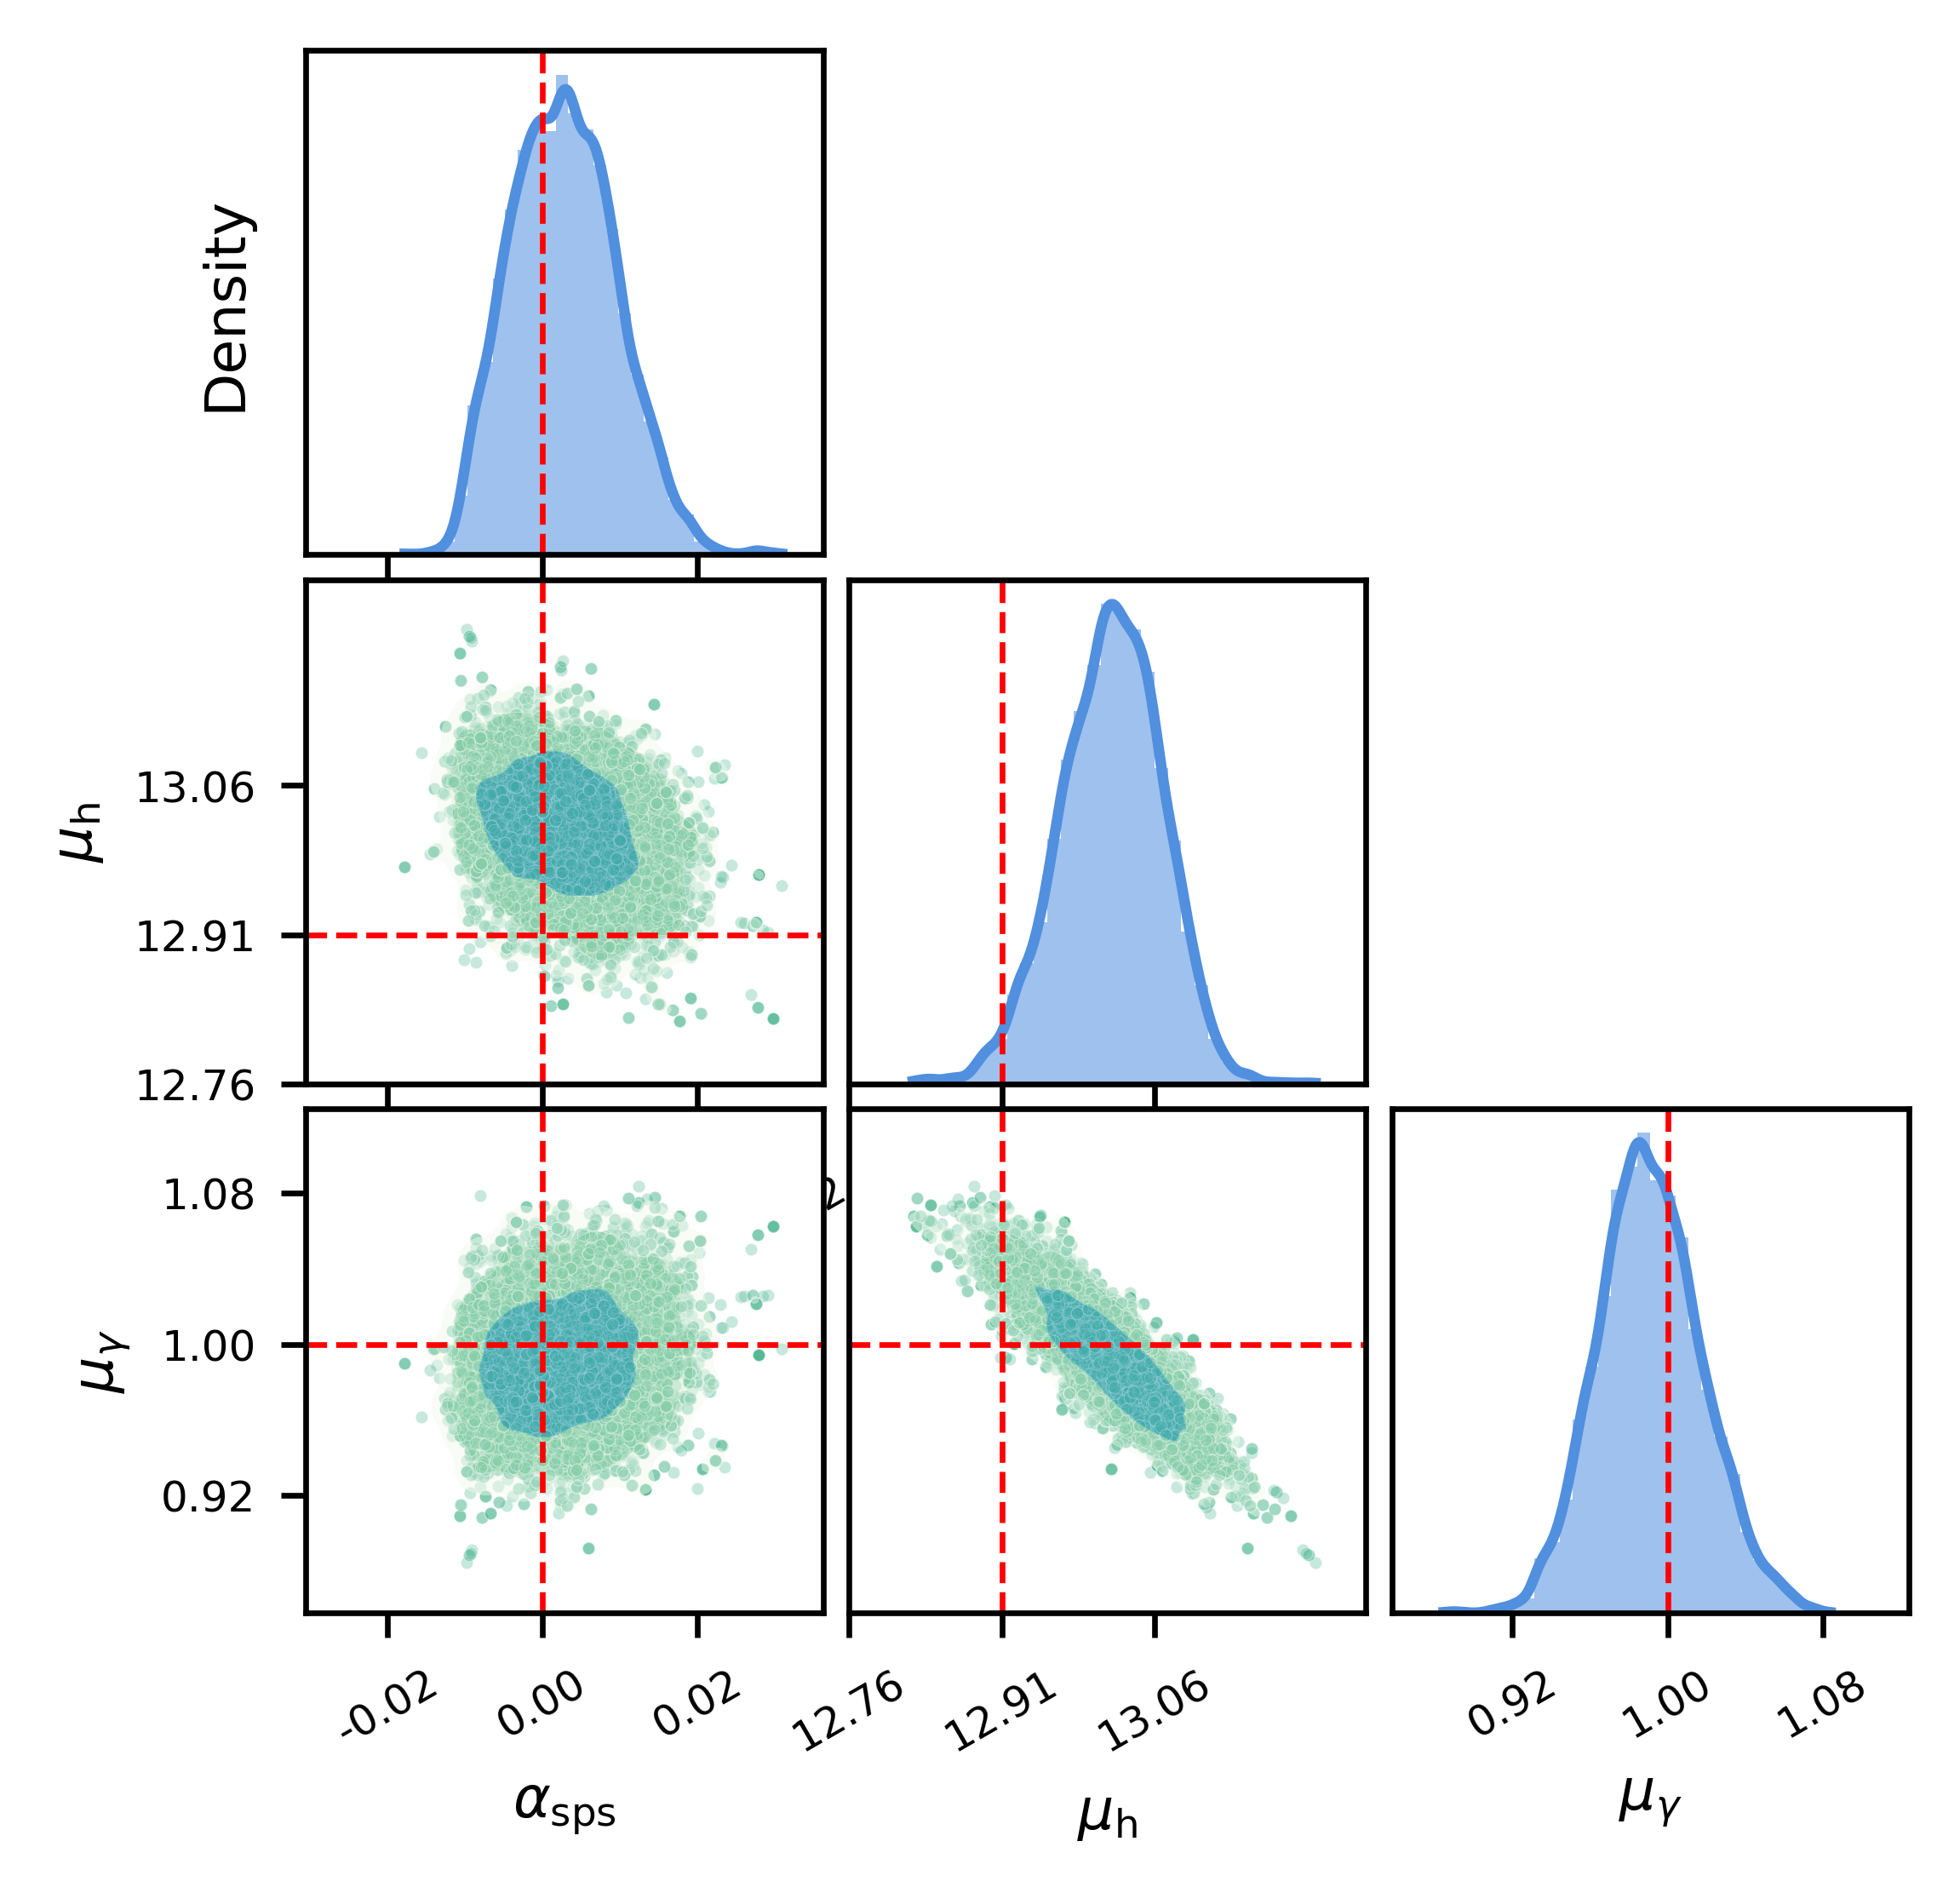

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
from emcee.backends import HDFBackend
from pathlib import Path
import os
from typing import Iterable, Optional, Tuple, List
from matplotlib.lines import Line2D


def read_run_metadata(path: str):
    lens_num = None
    scatter_mag = None
    scatter_star = None
    n_galaxy = None
    eta = None
    try:
        with h5py.File(path, "r") as f:
            if "metadata" in f:
                md = f["metadata"].attrs
                for k in ("lens_number", "n_lens", "lens_count"):
                    if k in md:
                        lens_num = int(md[k])
                        break
                if "scatter_mag" in md:
                    scatter_mag = float(md["scatter_mag"])
                if "scatter_star" in md:
                    scatter_star = float(md["scatter_star"])
                if "n_galaxy" in md:
                    n_galaxy = int(md["n_galaxy"])
                if "eta" in md:
                    eta = bool(md["eta"])
    except Exception:
        pass
    if lens_num is None:
        m = re.search(r"(\d+)\s*lens", path, re.IGNORECASE)
        if m:
            lens_num = int(m.group(1))
    return lens_num, scatter_mag, scatter_star, n_galaxy, eta


def open_backend_from_runfile(path: str) -> HDFBackend:
    with h5py.File(path, "r") as f:
        for g in ("chains/mcmc", "chains", "mcmc"):
            if g in f:
                return HDFBackend(path, name=g, read_only=True)
    return HDFBackend(path, read_only=True)


def plot_pair_only(
    hdf5_file: str,
    discard: int = 1000,
    thin: int = 10,
    labels: Optional[Iterable[str]] = None,
    truths: Optional[Iterable[float]] = None,
    width_factor: float = 2.5,
    first_dim_factor: float = 16.0,          # ✅ 第一维度单独放大范围
    dead_thr: float = 1e-6,
    figsize: Optional[Tuple[float, float]] = None,
    cmap: str = "Blues",
    savepath: Optional[str] = None,
    bins: int = 60,
    show_dead: bool = False
):
    """绘制 MCMC 采样的 Pair 图（下三角 + 对角线），带统一图例。"""

    backend = open_backend_from_runfile(hdf5_file)
    chain = backend.get_chain(discard=discard, thin=thin, flat=False)
    nsteps, nwalkers, ndim = chain.shape

    # 自动 labels
    if labels is None:
        labels = [fr'$\theta_{{{i}}}$' for i in range(ndim)]
    else:
        labels = list(labels)
        if len(labels) != ndim:
            raise ValueError(f"labels 长度 {len(labels)} 与参数维度 {ndim} 不一致")

    # 可选 truths
    if truths is not None:
        truths = list(truths)
        if len(truths) != ndim:
            raise ValueError(f"truths 长度 {len(truths)} 与参数维度 {ndim} 不一致")

    # 判定死链
    stds_per_walker = np.std(chain, axis=0)
    dead_mask = np.all(stds_per_walker < dead_thr, axis=1)
    live_idx = np.where(~dead_mask)[0].tolist()
    if len(live_idx) == 0:
        live_idx = list(range(nwalkers))

    # 展开活链
    chain_live = chain[:, live_idx, :] if (len(live_idx) and not show_dead) else chain
    samples = chain_live.reshape(-1, ndim)
    df = pd.DataFrame(samples, columns=labels)
    means, stds = df.mean(), df.std()

    # MAP 估计（KDE mode）
    from scipy.stats import gaussian_kde
    map_point = []
    for d in range(ndim):
        kde = gaussian_kde(samples[:, d])
        xg = np.linspace(samples[:, d].min(), samples[:, d].max(), 600)
        map_val = xg[np.argmax(kde(xg))]
        map_point.append(map_val)
    map_point = np.array(map_point)

    # ✅ 各维度显示范围（第一维度单独放宽）
    xlims = {}
    for i, lab in enumerate(labels):
        mx, sx = means[lab], stds[lab]
        fac = width_factor 
        xlims[lab] = (mx - fac * sx, mx + fac * sx)

        # if i == 0 and truths is not None:
        #     xlims[lab] =  (-0.06, 0.04)

    # ---------- Pair 图 ----------
    if figsize is None:
        cell = 1.35
        fig_w = ndim * cell
        fig_h = ndim * cell
        figsize = (fig_w, fig_h)

    fig = plt.figure(figsize=figsize, dpi=600)
    gs = fig.add_gridspec(ndim, ndim, wspace=0.05, hspace=0.05)

    color_kde_all = "#46B48E"         # KDE / scatter (Galaxy)
    color_kde_lens_line = "#518FDF"   # Hist line (Lens)

    for i in range(ndim):
        for j in range(ndim):
            if j > i:
                continue
            ax = fig.add_subplot(gs[i, j])
            xlab = labels[j]

            if i == j:
                # sns.histplot(df[xlab], bins=bins, kde=True, edgecolor="none",
                #              alpha=0.55, color=color_kde_lens_line, ax=ax)
                sns.histplot(df[xlab], bins=bins, kde=True, edgecolor="none",
                               alpha=0.55, color=color_kde_lens_line, ax=ax, stat="density")

                ax.set_xlim(xlims[xlab])
                # ax.axvline(map_point[i], color="orange", ls="-", lw=1.0)
                if truths is not None:
                    ax.axvline(truths[i], color="red", ls="--", lw=0.8)
                ax.set_yticks([])

            else:
                ylab = labels[i]
                sns.scatterplot(x=df[xlab], y=df[ylab], s=3, alpha=0.30,
                                color=color_kde_all, ax=ax)
                sns.kdeplot(x=df[xlab], y=df[ylab], fill=True, thresh=1,
                            levels=[0.01, 0.05, 0.35, 1.0],
                            cmap=cmap, alpha=0.45, ax=ax)
                # if truths is not None:
                #     ax.plot(truths[j], truths[i], "r+", markersize=4, markeredgewidth=0.9)
                if truths is not None:
                    # ✅ 真值改为横竖交叉红线
                    ax.axvline(truths[j], color="red", ls="--", lw=0.8)
                    ax.axhline(truths[i], color="red", ls="--", lw=0.8)

                ax.set_xlim(xlims[xlab])
                ax.set_ylim(xlims[ylab])

            # 坐标标签控制
            if i < ndim - 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(xlab)
            if j > 0:
                ax.set_yticklabels([])
                ax.set_ylabel("")
                ax.tick_params(axis="y", left=False)
            else:
                if i != j:
                    ax.set_ylabel(labels[i])

    # # ✅ 美观微调
    # for ax in fig.axes:
    #     ax.set_aspect('auto', adjustable='box')
    #     ax.tick_params(axis='both', which='major', labelsize=6)
    #     ax.tick_params(axis='both', which='minor', labelsize=5)
    #     ax.xaxis.label.set_size(8)
    #     ax.yaxis.label.set_size(8)



    # ✅ 美观微调 + 设置 tick（truth ± 3σ）
    for i, ax in enumerate(fig.axes):
        ax.set_aspect('auto', adjustable='box')
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.tick_params(axis='both', which='minor', labelsize=5)
        ax.xaxis.label.set_size(8)
        ax.yaxis.label.set_size(8)

    # ✅ 设置每个参数的 xtick, ytick = truth ± 3σ
    if truths is not None:
        for d, lab in enumerate(labels):
            sigma = stds[lab]
            truth = truths[d]
            tick_vals = [truth - 3*sigma, truth, truth + 3*sigma]
            tick_labels = [f"{tick_vals[0]:.2f}", f"{tick_vals[1]:.2f}", f"{tick_vals[2]:.2f}"]

            # 遍历所有子图，凡是涉及该参数，就改 tick
            for ax in fig.axes:
                # x 轴是该参数
                if ax.get_xlabel() == lab:
                    ax.set_xticks(tick_vals)
                    ax.set_xticklabels(tick_labels, rotation=30)
                # y 轴是该参数
                if ax.get_ylabel() == lab:
                    ax.set_yticks(tick_vals)
                    ax.set_yticklabels(tick_labels)




    # # ✅ 添加统一 Legend
    # legend_elements = [
    #     Line2D([0], [0], color=color_kde_lens_line, lw=2, label="Lens population"),
    #     Line2D([0], [0], marker='s', color='w', label="Galaxy population",
    #            markerfacecolor=color_kde_all, markersize=10)
    # ]
    # fig.legend(
    #     handles=legend_elements,
    #     loc="upper right",
    #     bbox_to_anchor=(0.96, 0.96),
    #     fontsize=14,
    #     frameon=False,
    #     borderpad=1.2,
    #     labelspacing=0.8
    # )

    plt.tight_layout()

    if savepath is not None:
        save_dir = Path(os.path.expanduser(savepath))
        save_dir.mkdir(parents=True, exist_ok=True)
        timestamp = re.search(r"(\d{8}T\d{6}Z)", hdf5_file)
        if timestamp:
            fname = save_dir / f"pair_only_{timestamp.group(0)}"
        else:
            fname = save_dir / "pair_only"
        out_png = fname.with_suffix(".png")
        plt.savefig(out_png, dpi=300)
        print(f"图已保存至 {out_png}")

    plt.show()



plot_pair_only(
    hdf5_file="../chains/chains_415lens_20251113T134634Z.h5",
    discard=600,
    thin=10,
    labels=[
        r'$\alpha_{\mathrm{sps}}$',
        r'$\mu_{\mathrm{h}}$',
        # r'$\beta_{\mathrm{h}}$',
        # r'$\sigma_{\mathrm{h}}$',
        r'$\mu_{\gamma}$',
    ],
    truths=[0., 12.91, 1.0],
    width_factor=5,
    first_dim_factor=12,
    cmap="GnBu",
    savepath="~/outfig",
    bins=30,
)


In [ ]:
def plot_chain_with_prior(
    hdf5_file: str,
    labels: Optional[List[str]] = None,
    truths: Optional[List[float]] = None,
    priors: Optional[List[Tuple[float, float]]] = None,
    discard: int = 0,
    thin: int = 1,
    figsize: Tuple[float, float] = (8, 6),
    alpha: float = 0.5,
    savepath: Optional[str] = None
):
    """
    绘制 MCMC chain (trace plot)，并显示先验范围。
    priors: list of (min, max) for each parameter
    """
    backend = open_backend_from_runfile(hdf5_file)
    chain = backend.get_chain(discard=discard, thin=thin, flat=False)
    nsteps, nwalkers, ndim = chain.shape

    if labels is None:
        labels = [fr'$\theta_{{{i}}}$' for i in range(ndim)]

    fig, axes = plt.subplots(ndim, 1, figsize=figsize, sharex=True, dpi=600)

    if ndim == 1:
        axes = [axes]

    for i in range(ndim):
        ax = axes[i]
        for w in range(nwalkers):
            ax.plot(chain[:, w, i], alpha=alpha, lw=0.8)

        # 真值
        if truths is not None:
            ax.axhline(truths[i], color="red", ls="--", lw=1.0, label="Truth")

        # 先验范围
        if priors is not None and priors[i] is not None:
            pmin, pmax = priors[i]
            ax.axhspan(pmin, pmax, color="gray", alpha=0.2, label="Prior range")

        ax.set_ylabel(labels[i])
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Step")

    # 图例
    handles, labels_ = axes[0].get_legend_handles_labels()
    if handles:
        axes[0].legend(handles, labels_, loc="upper right", fontsize=8, frameon=False)

    plt.tight_layout()

    if savepath is not None:
        out_path = Path(savepath).expanduser().with_suffix(".png")
        plt.savefig(out_path, dpi=300)
        print(f"Chain plot saved to {out_path}")

    plt.show()


In [ ]:
plot_chain_with_prior(
    hdf5_file="../chains/chains_76lens_20251111T124144Z.h5",
    labels=[
        r'$\alpha_{\mathrm{sps}}$',
        r'$\mu_{\mathrm{h}}$',
        r'$\mu_{\gamma}$',
    ],
    truths=[0.0, 12.91, 1.0],
    priors=[
        (-0.3, 0.3),     # α_sps prior range
        (12.0, 14.0),    # μ_h prior range
        (0.5, 1.5),      # μ_gamma prior range
    ],
    discard=00,
    thin=2,
    figsize=(9, 6),
    savepath="~/Desktop/outfig/chain_plot"
)
    # if not (-0.3 <= alpha_sps <= 0.3):
    #     return -np.inf
    # if not (12.0 <= mu_h <= 14.0):
    #     return -np.inf
    # if not (0.5 <= mu_gamma <= 1.5):
    #     return -np.inf

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
from emcee.backends import HDFBackend
from pathlib import Path
import os
from typing import Iterable, Optional, Tuple, List


# ---------- 通用步长（可选） ----------
def get_intervals(ndim: int) -> List[float]:
    """给出每个参数的可选 interval（仅在 truths 存在时作为 ±delta 参考线使用）。
    默认返回全 0（即不画 ±interval 线）。如果你有参数边界或栅格步长，可在这里自定义。
    """
    return [0.0] * ndim


# ---------- 读取 emcee 运行的一些元数据（若存在） ----------
def read_run_metadata(path: str):
    lens_num = None
    scatter_mag = None
    scatter_star = None
    n_galaxy = None
    eta = None
    try:
        with h5py.File(path, "r") as f:
            if "metadata" in f:
                md = f["metadata"].attrs
                for k in ("lens_number", "n_lens", "lens_count"):
                    if k in md:
                        lens_num = int(md[k])
                        break
                if "scatter_mag" in md:
                    scatter_mag = float(md["scatter_mag"])
                if "scatter_star" in md:
                    scatter_star = float(md["scatter_star"])
                if "n_galaxy" in md:
                    n_galaxy = int(md["n_galaxy"])
                if "eta" in md:
                    eta = bool(md["eta"])
    except Exception:
        pass
    if lens_num is None:
        m = re.search(r"(\d+)\s*lens", path, re.IGNORECASE)
        if m:
            lens_num = int(m.group(1))
    return lens_num, scatter_mag, scatter_star, n_galaxy, eta


# ---------- 打开 emcee 后端（自动探测组名） ----------
def open_backend_from_runfile(path: str) -> HDFBackend:
    with h5py.File(path, "r") as f:
        for g in ("chains/mcmc", "chains", "mcmc"):
            if g in f:
                return HDFBackend(path, name=g, read_only=True)
    # 也可能是纯 emcee 后端文件，默认根组
    return HDFBackend(path, read_only=True)


# ---------- 绘图主函数：自动适配任意维度（含 6D） ----------
def plot_pair_and_trace_side_by_side(
    hdf5_file: str,
    discard: int = 1000,
    thin: int = 10,
    labels: Optional[Iterable[str]] = None,   # 若为 None，将自动生成为 θ_0, θ_1, ...
    truths: Optional[Iterable[float]] = None, # 可选真值
    width_factor: float = 2.5,                # 下三角散点/等高线的坐标范围系数（均值 ± width_factor * std）
    dead_thr: float = 1e-6,                   # 死链阈值：全维 std < dead_thr
    last_steps: Optional[int] = None,         # 右图仅显示最后 N 步
    figsize: Optional[Tuple[float, float]] = None,  # 不给的话自动根据维度缩放
    cmap: str = "Blues",                     # 左下三角 KDE 的 colormap
    savepath: Optional[str] = None,           # 保存目录（None 表示不保存）
    step_range: Optional[Tuple[int, int]] = None,   # 右侧 trace 仅显示 [start:end)
    bins: int = 60,
    show_dead: bool = False                   # 是否显示判为“死链”的 walker（默认剔除）
):
    # 读取链
    backend = open_backend_from_runfile(hdf5_file)
    chain_all = backend.get_chain(discard=0, thin=thin, flat=False)   # (steps, walkers, ndim)
    chain     = backend.get_chain(discard=discard, thin=thin, flat=False)

    nsteps, nwalkers, ndim = chain.shape

    # 自动 labels
    if labels is None:
        labels = [fr'$\theta_{{{i}}}$' for i in range(ndim)]
    else:
        labels = list(labels)
        if len(labels) != ndim:
            raise ValueError(f"labels 长度 {len(labels)} 与参数维度 {ndim} 不一致")

    # truths 可选
    if truths is not None:
        truths = list(truths)
        if len(truths) != ndim:
            raise ValueError(f"truths 长度 {len(truths)} 与参数维度 {ndim} 不一致")

    # 判定死链（对丢弃后的 chain）
    stds_per_walker = np.std(chain, axis=0)      # (walkers, ndim)
    dead_mask = np.all(stds_per_walker < dead_thr, axis=1)
    live_idx = np.where(~dead_mask)[0].tolist()
    dead_idx = np.where(dead_mask)[0].tolist()
    if len(live_idx) == 0:
        # 如果全部死链，则全部当作活链用，避免崩溃
        live_idx = list(range(nwalkers))
        dead_idx = []

    # 采样展开
    chain_live = chain[:, live_idx, :] if (len(live_idx) and not show_dead) else chain
    samples = chain_live.reshape(-1, ndim)

    # 统计量
    df = pd.DataFrame(samples, columns=labels)
    means, stds = df.mean(), df.std()

    # 读取元数据
    lens_num, scatter_mag, scatter_star, n_galaxy, eta = read_run_metadata(hdf5_file)

    # 自动 figsize（左边为 ndim x ndim 的网格，为保证清晰度适当放大）
    if figsize is None:
        # 单元格大小 ~ 1.2-1.4 英寸：视屏幕情况可微调
        cell = 1.35
        left_w = ndim * cell
        left_h = ndim * cell
        right_w = 4.5
        fig_w = left_w + right_w
        fig_h = max(left_h, 6.0)
        figsize = (fig_w, fig_h)

    fig = plt.figure(figsize=figsize, dpi=220)
    outer = fig.add_gridspec(1, 2, width_ratios=[ndim, 3.0], wspace=0.28)

    # 计算 MAP（逐维 KDE mode）
    from scipy.stats import gaussian_kde
    map_point = []
    for d in range(ndim):
        kde = gaussian_kde(samples[:, d])
        xg = np.linspace(samples[:, d].min(), samples[:, d].max(), 600)
        map_val = xg[np.argmax(kde(xg))]
        map_point.append(map_val)
    map_point = np.array(map_point)
    # print(f"[MAP (KDE mode)] {dict(zip(labels, map_point))}")

    # 左：Pair（对角 1D，子对角 2D）
    gs_left = outer[0, 0].subgridspec(ndim, ndim, wspace=0.05, hspace=0.05)
    for i in range(ndim):
        for j in range(ndim):
            if j > i:
                continue
            ax = fig.add_subplot(gs_left[i, j])
            xlab = labels[j]

            if i == j:
                sns.histplot(df[xlab], bins=bins, kde=True, edgecolor="none", alpha=0.55, color="#518FDF", ax=ax)
                ax.axvline(map_point[i], color="orange", ls="-", lw=1.2, label="MAP")

                if truths is not None:
                    ax.axvline(truths[i], color="red", ls="--", lw=1.0, label="Truth")
                    # 可选：68% 和 95% 区间
                q16, q84 = np.percentile(df[xlab], [16, 84])
                q2p5, q97p5 = np.percentile(df[xlab], [2.5, 97.5])
                ax.axvspan(q16, q84, color="black", alpha=0.10, label="68% CI")
                ax.axvspan(q2p5, q97p5, color="gray", alpha=0.05, label="95% CI")

                # if i == 0:
                    # ax.legend(fontsize=5)
                ax.set_yticks([])

            else:
                ylab = labels[i]
                sns.scatterplot(x=df[xlab], y=df[ylab], s=3, alpha=0.30, color="#46B48E", ax=ax)
                sns.kdeplot(x=df[xlab], y=df[ylab], fill=True, thresh=1, levels=[0.01, 0.05, 0.35, 1.0], cmap=cmap, alpha=0.45, ax=ax)
                if truths is not None:
                    ax.plot(truths[j], truths[i], "r+", markersize=5, markeredgewidth=1.1)

                mx, sx = means[xlab], stds[xlab]
                my, sy = means[ylab], stds[ylab]
                ax.set_xlim(mx - width_factor * sx, mx + width_factor * sx)
                ax.set_ylim(my - width_factor * sy, my + width_factor * sy)

            # 轴刻度收拾
            if i < ndim - 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(xlab)
            if j > 0:
                ax.set_yticklabels([])
                ax.set_ylabel("")
                ax.tick_params(axis="y", left=False)
            else:
                if i == j:
                    ax.set_ylabel("")
                if i != j:
                    ax.set_ylabel(labels[i])

    # 右：Trace
    gs_right = outer[0, 1].subgridspec(ndim, 1, hspace=0.10)
    axes_trace = [fig.add_subplot(gs_right[k, 0]) for k in range(ndim)]

    # 选择显示范围
    base = chain_all[:, live_idx, :] if (len(live_idx) and not show_dead) else chain_all
    if step_range is not None:
        start, end = step_range
        cshow = base[start:end, :, :]
    elif last_steps is not None and last_steps < base.shape[0]:
        cshow = base[-last_steps:, :, :]
    else:
        cshow = base

    # 调色板按维度（每维一致颜色，walker 透明）
    palette = sns.color_palette("tab10", n_colors=max(10, ndim))
    for d, ax in enumerate(axes_trace):
        color_d = palette[d % len(palette)]
        for w in range(cshow.shape[1]):
            ax.plot(cshow[:, w, d], color=color_d, alpha=0.30, lw=0.4)
        ax.set_ylabel(labels[d])
        if truths is not None:
            t = truths[d]
            ax.axhline(t, color="red", ls="--", lw=0.8, alpha=0.8)
        if d != ndim - 1:
            ax.set_xticklabels([])
    axes_trace[-1].set_xlabel("Step")

    # 顶部标题
    if truths is not None:
        offsets = map_point - np.asarray(truths)
        offset_str = ", ".join([f"{o:+.3f}" for o in offsets])
    else:
        offset_str = "N/A"

    dead_info = f"live={len(live_idx)}/" if (len(live_idx) and not show_dead) else "live=all/"
    fig.suptitle(
        f"discard={discard}, thin={thin}, {dead_info}{nwalkers}, ndim={ndim}, \n"
        f"lenses={lens_num}, mag={scatter_mag}, star={scatter_star}, \n"
        f"n_galaxy={n_galaxy}, eta={eta}, offsets={offset_str}",
        y=0.995, fontsize=11
    )

    plt.tight_layout()

    # 保存
    if savepath is not None:
        save_dir = Path(os.path.expanduser(savepath))
        save_dir.mkdir(parents=True, exist_ok=True)
        timestamp = re.search(r"(\d{8}T\d{6}Z)", hdf5_file)
        if timestamp:
            fname = save_dir / f"pair_trace_{timestamp.group(0)}"
        else:
            fname = save_dir / "pair_trace"
        out_png = fname.with_suffix(".png")
        plt.savefig(out_png, dpi=300)
        print(f"图已保存至 {out_png}")

    plt.show()

# (alpha_sps, mu_h, beta_h, sigma_h, mu_gamma, sigma_gamma)
# ---------------------------- 使用示例 ----------------------------
plot_pair_and_trace_side_by_side(
    hdf5_file="../chains/chains_74lens_20251113T084632Z.h5",
    discard=500,
    thin=1,
    labels=[
        r'$\alpha_{\mathrm{sps}}$',
        r'$\mu_{\mathrm{h}}$',
        # r'$\beta_{\mathrm{h}}$',
        # r'$\sigma_{\mathrm{h}}$',
        r'$\mu_{\gamma}$',
        # r'$\sigma_{\gamma}$',
        ],
    truths=[0., 12.91,
     1.0,],
    width_factor=5,
    dead_thr=1e-6,
    last_steps=None,
    figsize=None,           # 自动按维度调节
    step_range=(0, 1000),
    cmap="Blues",                                                                                             
    savepath="~/Desktop/outfig",
    bins=60,
    )


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# =====================================================
# 1. Load HDF5 grid and build interpolator
# =====================================================
path = "../aeta_tables/Aeta3D_mu400_mugamma400_alpha400.h5"     # <<< 修改路径

with h5py.File(path, "r") as f:
    mu_DM_grid = np.array(f["grids/mu_DM_grid"])
    mu_gamma_grid = np.array(f["grids/mu_gamma_grid"])
    alpha_grid = np.array(f["grids/alpha_grid"])
    A_grid = np.array(f["grids/A_grid"])

interp = RegularGridInterpolator(
    (mu_DM_grid, mu_gamma_grid, alpha_grid),
    A_grid,
    method="linear",
    bounds_error=False,
    fill_value=None,
)

print("Loaded A-grid:", A_grid.shape)


# =====================================================
# Helper: test a slice along one dimension
# =====================================================

def test_slice(slice_dim="alpha"):
    """
    slice_dim ∈ {"mu_DM", "mu_gamma", "alpha"}.
    """
    # pick middle grid points for fixed dimensions
    mu_DM0 = mu_DM_grid[len(mu_DM_grid)//2]
    mu_g0  = mu_gamma_grid[len(mu_gamma_grid)//2]
    a0     = alpha_grid[len(alpha_grid)//2]

    if slice_dim == "alpha":
        x_vals = alpha_grid
        d = "alpha"
        # find closest grid indices
        i_DM = np.argmin(abs(mu_DM_grid - mu_DM0))
        i_g  = np.argmin(abs(mu_gamma_grid - mu_g0))
        A_orig = A_grid[i_DM, i_g, :]

        # build query points
        pts = np.column_stack([
            np.full_like(x_vals, mu_DM0),
            np.full_like(x_vals, mu_g0),
            x_vals
        ])

    elif slice_dim == "mu_DM":
        x_vals = mu_DM_grid
        d = "mu_DM"
        i_g  = np.argmin(abs(mu_gamma_grid - mu_g0))
        i_a  = np.argmin(abs(alpha_grid - a0))
        A_orig = A_grid[:, i_g, i_a]

        pts = np.column_stack([
            x_vals,
            np.full_like(x_vals, mu_g0),
            np.full_like(x_vals, a0)
        ])

    elif slice_dim == "mu_gamma":
        x_vals = mu_gamma_grid
        d = "mu_gamma"
        i_DM = np.argmin(abs(mu_DM_grid - mu_DM0))
        i_a  = np.argmin(abs(alpha_grid - a0))
        A_orig = A_grid[i_DM, :, i_a]

        pts = np.column_stack([
            np.full_like(x_vals, mu_DM0),
            x_vals,
            np.full_like(x_vals, a0)
        ])

    else:
        raise ValueError("Unknown slice dimension")

    # interpolated values
    A_interp = interp(pts)

    # absolute & relative errors
    abs_err = A_interp - A_orig
    rel_err = abs_err / np.where(A_orig == 0, 1, A_orig)

    # Plot: original vs interpolated
    plt.figure(figsize=(8,5))
    plt.plot(x_vals, A_orig, "o", label="original")
    plt.plot(x_vals, A_interp, "-", label="interp")
    plt.xlabel(d)
    plt.ylabel("A")
    plt.title(f"Slice along {d}: original vs interpolated")
    plt.legend()
    plt.show()

    # Plot error
    plt.figure(figsize=(8,5))
    plt.plot(x_vals, rel_err, "o")
    plt.axhline(0, color="gray", lw=1)
    plt.xlabel(d)
    plt.ylabel("relative error")
    plt.title(f"Relative error along {d}")
    plt.show()

    print(f"==== Slice {d} statistics ====")
    print("max abs error:", np.max(np.abs(abs_err)))
    print("max rel error:", np.max(np.abs(rel_err)))
    print()


# =====================================================
# 3. Run all slice tests
# =====================================================

test_slice("alpha")
test_slice("mu_DM")
test_slice("mu_gamma")


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# =====================================================
# Load HDF5
# =====================================================
path = "../aeta_tables/Aeta3D_mu400_mugamma400_alpha400.h5"

with h5py.File(path, "r") as f:
    mu_DM_grid = np.array(f["grids/mu_DM_grid"])
    mu_gamma_grid = np.array(f["grids/mu_gamma_grid"])
    alpha_grid = np.array(f["grids/alpha_grid"])
    A_grid = np.array(f["grids/A_grid"])

interp = RegularGridInterpolator(
    (mu_DM_grid, mu_gamma_grid, alpha_grid),
    A_grid,
    method="linear",
    bounds_error=False,
    fill_value=None,
)

# =====================================================
# Midpoint generator
# =====================================================
def midpoints(arr):
    return 0.5 * (arr[:-1] + arr[1:])


# =====================================================
# Slice test helper (midpoint version)
# =====================================================
def test_slice_mid(slice_dim):
    if slice_dim == "alpha":
        x_vals = midpoints(alpha_grid)
        pts = np.column_stack([
            np.full_like(x_vals, muDM0),
            np.full_like(x_vals, muGamma0),
            x_vals
        ])

    elif slice_dim == "mu_DM":
        x_vals = midpoints(mu_DM_grid)
        pts = np.column_stack([
            x_vals,
            np.full_like(x_vals, muGamma0),
            np.full_like(x_vals, alpha0)
        ])

    elif slice_dim == "mu_gamma":
        x_vals = midpoints(mu_gamma_grid)
        pts = np.column_stack([
            np.full_like(x_vals, muDM0),
            x_vals,
            np.full_like(x_vals, alpha0)
        ])

    # interpolated result
    A_interp = interp(pts)

    # ===== TRUE linear interpolation from table =====
    # We know the grid is linear so A_true = manual 1D linear interpolation
    A_true = []
    for x in x_vals:
        # find left/right indices
        grid = {"alpha": alpha_grid,
                "mu_DM": mu_DM_grid,
                "mu_gamma": mu_gamma_grid}[slice_dim]

        idx = np.searchsorted(grid, x) - 1
        x0, x1 = grid[idx], grid[idx+1]
        t = (x - x0) / (x1 - x0)

        # extract true table values
        if slice_dim == "alpha":
            A0 = A_grid[i_DM0, i_gamma0, idx]
            A1 = A_grid[i_DM0, i_gamma0, idx+1]
        elif slice_dim == "mu_DM":
            A0 = A_grid[idx, i_gamma0, i_alpha0]
            A1 = A_grid[idx+1, i_gamma0, i_alpha0]
        elif slice_dim == "mu_gamma":
            A0 = A_grid[i_DM0, idx, i_alpha0]
            A1 = A_grid[i_DM0, idx+1, i_alpha0]

        A_true.append((1-t)*A0 + t*A1)

    A_true = np.array(A_true)

    # errors
    abs_err = A_interp - A_true
    rel_err = abs_err / np.where(A_true == 0, 1, A_true)

    # plot
    plt.figure(figsize=(8,5))
    plt.plot(x_vals, A_true, "o", label="True(linear from table)")
    plt.plot(x_vals, A_interp, "-", label="Interp")
    plt.title(f"Midpoint slice along {slice_dim}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(x_vals, rel_err, "o")
    plt.axhline(0, color='gray')
    plt.title(f"Relative error (midpoints) along {slice_dim}")
    plt.show()

    print(f"[{slice_dim}] max abs err =", np.max(np.abs(abs_err)))
    print(f"[{slice_dim}] max rel err =", np.max(np.abs(rel_err)))
    print()


# =====================================================
# Use your pivot point (nearest grid)
# =====================================================
target_muDM = 12.91
target_muGamma = 1.0
target_alpha = 0.0

i_DM0 = np.argmin(abs(mu_DM_grid - target_muDM))
i_gamma0 = np.argmin(abs(mu_gamma_grid - target_muGamma))
i_alpha0 = np.argmin(abs(alpha_grid - target_alpha))

muDM0 = mu_DM_grid[i_DM0]
muGamma0 = mu_gamma_grid[i_gamma0]
alpha0 = alpha_grid[i_alpha0]

# =====================================================
# Test midpoints (真正检验插值效果)
# =====================================================
test_slice_mid("alpha")
test_slice_mid("mu_DM")
test_slice_mid("mu_gamma")


In [ ]:
# 尝试画出单个sigmagamma的后验

In [ ]:
import sys
sys.path.append("../../")  # 添加上级目录到路径，方便导入模块


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sl_inference_6Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_6Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_6Dinfer_hdf5.config import SCATTER
from sl_inference_6Dinfer_hdf5.likelihood import log_posterior
from dataclasses import dataclass

  # 导入模块


# 设置Matplotlib后端（适用于Jupyter环境）

@dataclass(frozen=True)
class DMGrid2D:
    logMh: np.ndarray
    gamma_h: np.ndarray


def build_dm_grid2d(
    *,
    logMh_min: float = 11.0,
    logMh_max: float = 15.0,
    n_logMh: int = 30,
    gamma_min: float = 0.4,
    gamma_max: float = 1.6,
    n_gamma: int = 30,
) -> DMGrid2D:
    """Construct a reusable 2D grid over (logMh, gamma_h).

    This defines only the parameter axes. No likelihood/tabulation is done here.
    """
    logMh_axis = np.linspace(float(logMh_min), float(logMh_max), int(n_logMh))
    gamma_axis = np.linspace(float(gamma_min), float(gamma_max), int(n_gamma))
    return DMGrid2D(logMh=logMh_axis, gamma_h=gamma_axis)


# Create once and keep module-global for reuse
DM_GRID_2D: DMGrid2D = build_dm_grid2d()

# 生成2D DM网格，假设你想计算这些参数的似然
logMh_min = 11.0
logMh_max = 15.0
n_logMh = 30
gamma_min = 0.4
gamma_max = 1.6
n_gamma = 30
logMh_axis = np.linspace(float(logMh_min), float(logMh_max), int(n_logMh))
gamma_axis = np.linspace(float(gamma_min), float(gamma_max), int(n_gamma))

# 创建DM网格
DM_GRID_2D = DMGrid2D(logMh=logMh_axis, gamma_h=gamma_axis)

# 假设给定某个超参数组合
logMh_val = 12.91  # 举例：logMh为12.91
gamma_h_val = 1.2  # 举例：gamma_h为1.2

# 模拟参数
logalpha = 0.0
n_galaxy = 40000
seed = 420
print(f"Generating mock data with {n_galaxy} galaxies, logalpha={logalpha}, seed={seed} ...")

# 生成模拟数据
df_lens, mock_lens_data, mock_observed_data, samples_dict = run_mock_simulation(
    n_galaxy, logalpha=logalpha, seed=seed, nbkg=4e-4, if_source=True
)

# 计算似然：使用给定超参数logMh_val, gamma_h_val计算似然
grids = tabulate_likelihood_grids(
    mock_observed_data,
    DM_GRID_2D,
    n_jobs=None,
)



In [ ]:
from sl_inference_6Dinfer_hdf5.likelihood import log_posterior
# def log_posterior(
#     eta: Sequence[float],
#     grids: Sequence[LensGrid2D],
#     *,
#     pool: Optional[object] = None
# ) -> float:
    
print(log_posterior([0.0, 12.91, 2.04, 0.37, 1.0, 0.2], grids))

In [ ]:
sigmagammas = np.linspace(0.1, 0.5, 50)
posteriorsigmag = []
for sigmagamma in sigmagammas:
    eta = [0.0, 12.91, 2.04, 0.37, 1.0, sigmagamma]
    log_post = log_posterior(eta, grids)
    posteriorsigmag.append(log_post)  # 转换为后验概率
    
import matplotlib.pyplot as plt

mugammas = np.linspace(0.5, 1.5, 50)
posteriormug = []
for mugamma in mugammas:
    eta = [0.0, 12.91, 2.04, 0.37, mugamma, 0.2]
    log_post = log_posterior(eta, grids)
    posteriormug.append(log_post)  # 转换为后验概率


alphas = np.linspace(-0.1, 0.1, 50)
posterioralpha = []
for alpha in alphas:
    eta = [alpha, 12.91, 2.04, 0.37, 1.0, 0.2]
    log_post = log_posterior(eta, grids)
    posterioralpha.append(log_post)  # 转换为后验概率


muDMs = np.linspace(12.0, 13.5, 50)
posteriormuDM = []
for muDM in muDMs:
    eta = [0.0, muDM, 2.04, 0.37, 1.0, 0.2]
    log_post = log_posterior(eta, grids)
    posteriormuDM.append(log_post)  # 转换为后验概率

betaDMs = np.linspace(1.5, 2.5, 50)
posteriorbetaDM = []
for betaDM in betaDMs:
    eta = [0.0, 12.91, betaDM, 0.37, 1.0, 0.2]
    log_post = log_posterior(eta, grids)
    posteriorbetaDM.append(log_post)  # 转换为后验概率

sigmaDMs = np.linspace(0.1, 0.5, 50)
posteriorsigmaDM = []
for sigmaDM in sigmaDMs:
    eta = [0.0, 12.91, 2.04, sigmaDM, 1.0, 0.2]
    log_post = log_posterior(eta, grids)
    posteriorsigmaDM.append(log_post)  # 转换为后验概率

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs[0, 0].plot(sigmagammas, posteriorsigmag)
axs[0, 0].set_xlabel('sigma_gamma')
axs[0, 0].set_ylabel('Posterior Probability')   
axs[0, 0].set_title('Posterior vs. sigma_gamma')
axs[0, 0].axvline(0.2, color="red", ls="--", lw=1.0, label="Truth")
axs[0, 1].plot(mugammas, posteriormug)
axs[0, 1].set_xlabel('mu_gamma')
axs[0, 1].set_ylabel('Posterior Probability')   
axs[0, 1].set_title('Posterior vs. mu_gamma')
axs[0, 1].axvline(1.0, color="red", ls="--", lw=1.0, label="Truth")
axs[1, 0].plot(alphas, posterioralpha)
axs[1, 0].set_xlabel('alpha_sps')
axs[1, 0].set_ylabel('Posterior Probability')   
axs[1, 0].set_title('Posterior vs. alpha_sps')
axs[1, 0].axvline(0.0, color="red", ls="--", lw=1.0, label="Truth")
axs[1, 1].plot(muDMs, posteriormuDM)
axs[1, 1].set_xlabel('mu_h')
axs[1, 1].set_ylabel('Posterior Probability')   
axs[1, 1].set_title('Posterior vs. mu_h')
axs[1, 1].axvline(12.91, color="red", ls="--", lw=1.0, label="Truth")
axs[2, 0].plot(betaDMs, posteriorbetaDM)
axs[2, 0].set_xlabel('beta_h')
axs[2, 0].set_ylabel('Posterior Probability')   
axs[2, 0].set_title('Posterior vs. beta_h')
axs[2, 0].axvline(2.04, color="red", ls="--", lw=1.0, label="Truth")
axs[2, 1].plot(sigmaDMs, posteriorsigmaDM)
axs[2, 1].set_xlabel('sigma_h')
axs[2, 1].set_ylabel('Posterior Probability')   
axs[2, 1].set_title('Posterior vs. sigma_h')
axs[2, 1].axvline(0.37, color="red", ls="--", lw=1.0, label="Truth")
plt.tight_layout()
plt.show()






In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
from emcee.backends import HDFBackend
from pathlib import Path
import os
from typing import Iterable, Optional, Tuple, List
from matplotlib.lines import Line2D


def read_run_metadata(path: str):
    lens_num = None
    scatter_mag = None
    scatter_star = None
    n_galaxy = None
    eta = None
    try:
        with h5py.File(path, "r") as f:
            if "metadata" in f:
                md = f["metadata"].attrs
                for k in ("lens_number", "n_lens", "lens_count"):
                    if k in md:
                        lens_num = int(md[k])
                        break
                if "scatter_mag" in md:
                    scatter_mag = float(md["scatter_mag"])
                if "scatter_star" in md:
                    scatter_star = float(md["scatter_star"])
                if "n_galaxy" in md:
                    n_galaxy = int(md["n_galaxy"])
                if "eta" in md:
                    eta = bool(md["eta"])
    except Exception:
        pass
    if lens_num is None:
        m = re.search(r"(\d+)\s*lens", path, re.IGNORECASE)
        if m:
            lens_num = int(m.group(1))
    return lens_num, scatter_mag, scatter_star, n_galaxy, eta


def open_backend_from_runfile(path: str) -> HDFBackend:
    with h5py.File(path, "r") as f:
        for g in ("chains/mcmc", "chains", "mcmc"):
            if g in f:
                return HDFBackend(path, name=g, read_only=True)
    return HDFBackend(path, read_only=True)


def plot_pair_only(
    hdf5_file: str,
    discard: int = 1000,
    thin: int = 10,
    labels: Optional[Iterable[str]] = None,
    truths: Optional[Iterable[float]] = None,
    width_factor: float = 2.5,
    first_dim_factor: float = 16.0,          # ✅ 第一维度单独放大范围
    dead_thr: float = 1e-6,
    figsize: Optional[Tuple[float, float]] = None,
    cmap: str = "Blues",
    savepath: Optional[str] = None,
    bins: int = 60,
    show_dead: bool = False
):
    """绘制 MCMC 采样的 Pair 图（下三角 + 对角线），带统一图例。"""

    backend = open_backend_from_runfile(hdf5_file)
    chain = backend.get_chain(discard=discard, thin=thin, flat=False)
    nsteps, nwalkers, ndim = chain.shape

    # 自动 labels
    if labels is None:
        labels = [fr'$\theta_{{{i}}}$' for i in range(ndim)]
    else:
        labels = list(labels)
        if len(labels) != ndim:
            raise ValueError(f"labels 长度 {len(labels)} 与参数维度 {ndim} 不一致")

    # 可选 truths
    if truths is not None:
        truths = list(truths)
        if len(truths) != ndim:
            raise ValueError(f"truths 长度 {len(truths)} 与参数维度 {ndim} 不一致")

    # 判定死链
    stds_per_walker = np.std(chain, axis=0)
    dead_mask = np.all(stds_per_walker < dead_thr, axis=1)
    live_idx = np.where(~dead_mask)[0].tolist()
    if len(live_idx) == 0:
        live_idx = list(range(nwalkers))

    # 展开活链
    chain_live = chain[:, live_idx, :] if (len(live_idx) and not show_dead) else chain
    samples = chain_live.reshape(-1, ndim)
    df = pd.DataFrame(samples, columns=labels)
    means, stds = df.mean(), df.std()

    # MAP 估计（KDE mode）
    from scipy.stats import gaussian_kde
    map_point = []
    for d in range(ndim):
        kde = gaussian_kde(samples[:, d])
        xg = np.linspace(samples[:, d].min(), samples[:, d].max(), 600)
        map_val = xg[np.argmax(kde(xg))]
        map_point.append(map_val)
    map_point = np.array(map_point)

    # ✅ 各维度显示范围（第一维度单独放宽）
    xlims = {}
    for i, lab in enumerate(labels):
        mx, sx = means[lab], stds[lab]
        fac = width_factor 
        xlims[lab] = (mx - fac * sx, mx + fac * sx)

        # if i == 0 and truths is not None:
        #     xlims[lab] =  (-0.06, 0.04)

    # ---------- Pair 图 ----------
    if figsize is None:
        cell = 1.35
        fig_w = ndim * cell
        fig_h = ndim * cell
        figsize = (fig_w, fig_h)

    fig = plt.figure(figsize=figsize, dpi=600)
    gs = fig.add_gridspec(ndim, ndim, wspace=0.05, hspace=0.05)

    color_kde_all = "#46B48E"         # KDE / scatter (Galaxy)
    color_kde_lens_line = "#518FDF"   # Hist line (Lens)

    for i in range(ndim):
        for j in range(ndim):
            if j > i:
                continue
            ax = fig.add_subplot(gs[i, j])
            xlab = labels[j]

            if i == j:
                sns.histplot(df[xlab], bins=bins, kde=True, edgecolor="none",
                             alpha=0.55, color=color_kde_lens_line, ax=ax)
                ax.set_xlim(xlims[xlab])
                # ax.axvline(map_point[i], color="orange", ls="-", lw=1.0)
                if truths is not None:
                    ax.axvline(truths[i], color="red", ls="--", lw=0.8)
                ax.set_yticks([])

            else:
                ylab = labels[i]
                sns.scatterplot(x=df[xlab], y=df[ylab], s=3, alpha=0.30,
                                color=color_kde_all, ax=ax)
                sns.kdeplot(x=df[xlab], y=df[ylab], fill=True, thresh=1,
                            levels=[0.01, 0.05, 0.35, 1.0],
                            cmap=cmap, alpha=0.45, ax=ax)
                # if truths is not None:
                #     ax.plot(truths[j], truths[i], "r+", markersize=4, markeredgewidth=0.9)
                if truths is not None:
                    # ✅ 真值改为横竖交叉红线
                    ax.axvline(truths[j], color="red", ls="--", lw=0.8)
                    ax.axhline(truths[i], color="red", ls="--", lw=0.8)

                ax.set_xlim(xlims[xlab])
                ax.set_ylim(xlims[ylab])

            # 坐标标签控制
            if i < ndim - 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(xlab)
            if j > 0:
                ax.set_yticklabels([])
                ax.set_ylabel("")
                ax.tick_params(axis="y", left=False)
            else:
                if i != j:
                    ax.set_ylabel(labels[i])

    # # ✅ 美观微调
    # for ax in fig.axes:
    #     ax.set_aspect('auto', adjustable='box')
    #     ax.tick_params(axis='both', which='major', labelsize=6)
    #     ax.tick_params(axis='both', which='minor', labelsize=5)
    #     ax.xaxis.label.set_size(8)
    #     ax.yaxis.label.set_size(8)



    # ✅ 美观微调 + 设置 tick（truth ± 3σ）
    for i, ax in enumerate(fig.axes):
        ax.set_aspect('auto', adjustable='box')
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.tick_params(axis='both', which='minor', labelsize=5)
        ax.xaxis.label.set_size(8)
        ax.yaxis.label.set_size(8)

    # ✅ 设置每个参数的 xtick, ytick = truth ± 3σ
    if truths is not None:
        for d, lab in enumerate(labels):
            sigma = stds[lab]
            truth = truths[d]
            tick_vals = [truth - 3*sigma, truth, truth + 3*sigma]
            tick_labels = [f"{tick_vals[0]:.2f}", f"{tick_vals[1]:.2f}", f"{tick_vals[2]:.2f}"]

            # 遍历所有子图，凡是涉及该参数，就改 tick
            for ax in fig.axes:
                # x 轴是该参数
                if ax.get_xlabel() == lab:
                    ax.set_xticks(tick_vals)
                    ax.set_xticklabels(tick_labels, rotation=30)
                # y 轴是该参数
                if ax.get_ylabel() == lab:
                    ax.set_yticks(tick_vals)
                    ax.set_yticklabels(tick_labels)




    # # ✅ 添加统一 Legend
    # legend_elements = [
    #     Line2D([0], [0], color=color_kde_lens_line, lw=2, label="Lens population"),
    #     Line2D([0], [0], marker='s', color='w', label="Galaxy population",
    #            markerfacecolor=color_kde_all, markersize=10)
    # ]
    # fig.legend(
    #     handles=legend_elements,
    #     loc="upper right",
    #     bbox_to_anchor=(0.96, 0.96),
    #     fontsize=14,
    #     frameon=False,
    #     borderpad=1.2,
    #     labelspacing=0.8
    # )

    plt.tight_layout()

    if savepath is not None:
        save_dir = Path(os.path.expanduser(savepath))
        save_dir.mkdir(parents=True, exist_ok=True)
        timestamp = re.search(r"(\d{8}T\d{6}Z)", hdf5_file)
        if timestamp:
            fname = save_dir / f"pair_only_{timestamp.group(0)}"
        else:
            fname = save_dir / "pair_only"
        out_png = fname.with_suffix(".png")
        plt.savefig(out_png, dpi=300)
        print(f"图已保存至 {out_png}")

    plt.show()



plot_pair_only(
    hdf5_file="../chains/chains_1238lens_noeta_20251109T122335Z_420.h5",
    discard=500,
    thin=10,
    labels=[
        r'$\alpha_{\mathrm{sps}}$',
        r'$\mu_{\mathrm{h}}$',
        r'$\beta_{\mathrm{h}}$',
        r'$\sigma_{\mathrm{h}}$',
        r'$\mu_{\gamma}$',
        r'$\sigma_{\gamma}$',
    ],
    truths=[0., 12.91, 2.04, 0.37, 1.0, 0.2],
    width_factor=5,
    first_dim_factor=12,
    cmap="GnBu",
    savepath="~/Desktop/outfig",
    bins=60,
)


Plot Backend

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from emcee.backends import HDFBackend
from typing import Iterable, Optional, Tuple

def plot_backend_pair_trace(
    backend_file: str,
    discard: int = 500,
    thin: int = 1,
    labels: Optional[Iterable[str]] = None,
    truths: Optional[Iterable[float]] = None,
    width_factor: float = 3.0,
    bins: int = 20,
    cmap: str = "Blues",
    last_steps: Optional[int] = None,
    figsize: Optional[Tuple[float, float]] = None,
    savepath=None
):
    """Pairplot + traceplot for emcee backend only"""
    try:
        backend = HDFBackend(backend_file, name="mcmc", read_only=True)
    except:
        backend = HDFBackend(backend_file, read_only=True)

    chain_full = backend.get_chain(discard=discard, thin=thin, flat=False)
    nsteps, nwalkers, ndim = chain_full.shape
    samples = chain_full.reshape(-1, ndim) if last_steps is None else chain_full[-last_steps:].reshape(-1, ndim)

    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]

    means = np.mean(samples, axis=0)
    stds = np.std(samples, axis=0)

    if figsize is None:
        width = ndim * 1.3 + 4
        height = max(ndim * 1.3, 6)
        figsize = (width, height)

    fig = plt.figure(figsize=figsize, dpi=220)
    gs = fig.add_gridspec(1, 2, width_ratios=[ndim, 3], wspace=0.25)

    gs_left = gs[0, 0].subgridspec(ndim, ndim, wspace=0.05, hspace=0.05)
    for i in range(ndim):
        for j in range(ndim):
            ax = fig.add_subplot(gs_left[i, j])
            if j > i:
                ax.axis("off")
                continue

            if i == j:
                sns.histplot(samples[:, j], bins=bins, kde=True, color="#5199D9", alpha=0.6, ax=ax)
                if truths is not None:
                    ax.axvline(truths[j], color="red", ls="--", lw=1)
                ax.set_yticks([])
            else:
                sns.kdeplot(x=samples[:, j], y=samples[:, i], fill=True, cmap=cmap, levels=15, thresh=0.05, ax=ax)
                if truths is not None:
                    ax.plot(truths[j], truths[i], "r+", ms=5, mew=1.2)
                ax.set_xlim(means[j] - width_factor * stds[j], means[j] + width_factor * stds[j])
                ax.set_ylim(means[i] - width_factor * stds[i], means[i] + width_factor * stds[i])

            if i < ndim - 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(labels[j])
            if j > 0:
                ax.set_yticklabels([])
            else:
                ax.set_ylabel(labels[i])

    gs_right = gs[0, 1].subgridspec(ndim, 1, hspace=0.15)
    for k in range(ndim):
        ax = fig.add_subplot(gs_right[k, 0])
        for w in range(nwalkers):
            ax.plot(chain_full[:, w, k], alpha=0.3, lw=0.4)
        if truths is not None:
            ax.axhline(truths[k], color="red", ls="--", lw=0.8)
        ax.set_ylabel(labels[k])
        if k != ndim - 1:
            ax.set_xticklabels([])
    ax.set_xlabel("Step")

    fig.suptitle(f"emcee backend: {backend_file}", fontsize=11)
    plt.tight_layout()
    if savepath is not None:
        save_dir = Path(os.path.expanduser(savepath))
        save_dir.mkdir(parents=True, exist_ok=True)
        timestamp = re.search(r"(\d{8}T\d{6}Z)", backend_file)
        if timestamp:
            fname = save_dir / f"pair_trace_{timestamp.group(0)}"
        else:
            fname = save_dir / "pair_trace"
        out_png = fname.with_suffix(".png")
        plt.savefig(out_png, dpi=300)
        print(f"图已保存至 {out_png}")

    plt.show()
plot_backend_pair_trace(
    backend_file="../chains/chains_1238lens_noeta_20251109T122335Z_420.h5",
    discard=00,
    thin=1,
    labels=[
        r"$\alpha_{\mathrm{sps}}$", r"$\mu_{\mathrm{h}}$", r"$\beta_{\mathrm{h}}$",
        r"$\sigma_{\mathrm{h}}$", r"$\mu_{\gamma}$", r"$\sigma_{\gamma}$"
    ],
    truths=[0., 12.91, 2.04, 0.37,
     1.0,
     0.2],
    last_steps=1500,
    width_factor=4,
    savepath="~/Desktop/outfig",
)





In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# === 输入文件 ===
aeta_file = "../Aeta6D_balanced_muHi.h5"  # 换成你的文件

# === 读取 A(η) 数据 ===
with h5py.File(aeta_file, "r") as f:
    A = f["/A_eta"][:]                   # 6D array
    mu_dm = f["/mu_dm_grid"][:]
    beta_dm = f["/beta_dm_grid"][:]
    sigma_dm = f["/sigma_dm_grid"][:]
    alpha = f["/alpha_grid"][:]
    mu_gamma = f["/mu_gamma_grid"][:]
    sigma_gamma = f["/sigma_gamma_grid"][:]

print(f"[info] loaded A_eta shape = {A.shape}")

# === 选择切片位置 ===
# 方案1：手动指定
# i_sigma, i_alpha, i_mug, i_sigg = 2, 2, 2, 2

# 方案2：自动选择中间切片（推荐）
i_sigma = len(sigma_dm) // 2
i_alpha = len(alpha) // 2
i_mug = len(mu_gamma) // 2
i_sigg = len(sigma_gamma) // 2

print(f"[slice] fixing σ_DM={sigma_dm[i_sigma]:.3f}, α={alpha[i_alpha]:.3f}, μγ={mu_gamma[i_mug]:.3f}, σγ={sigma_gamma[i_sigg]:.3f}")

# === 取切片 A(μ_DM, β_DM) 面 ===
A_slice = A[:, :, i_sigma, i_alpha, i_mug, i_sigg]

# === 画图 ===
plt.figure(figsize=(6.5, 5.5))
im = plt.imshow(
    A_slice.T,
    origin="lower",
    extent=[mu_dm.min(), mu_dm.max(), beta_dm.min(), beta_dm.max()],
    aspect="auto"
)
plt.colorbar(im, label="A(η)")
plt.xlabel("μ_DM", fontsize=12)
plt.ylabel("β_DM", fontsize=12)
plt.title("Slice of A(η) at fixed σ_DM, α, μγ, σγ", fontsize=13)
plt.tight_layout()
plt.show()


In [ ]:
✅ TEST START
Processing lenses (process=10): 100%|██████████| 1000/1000 [00:01<00:00, 562.05it/s]
✅ Mock OK, got lenses: 6
Lenses: 100%|██████████| 6/6 [01:08<00:00, 11.43s/it]
✅ Tabulation OK, get grids: 6
✅ K table loaded
✅ logL = -inf

In [ ]:
import numpy as np
print("A min/max:", np.min(A), np.max(A))
print("zeros ratio:", np.mean(A == 0))

import h5py
with h5py.File("../../bank_uniform1e5.h5","r") as f:
    sel = f["/select/pass_selection"][:]
    print("selection pass =", sel.sum(), "/", len(sel))



In [ ]:
# test_pipeline.py
import numpy as np
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
import sys
sys.path.insert(0, project_root)
from sl_inference_4Dinfer_hdf5.build_k_table import load_K_interpolator

# ==== 文件路径 ====
mock_path = "../../bank_uniform6M_test.h5"
ktable_path = "../K_mu0_10000_midRes_K_table_mu50000_ms10000.h5"

print("==== 加载 mock 数据 ====")
with h5py.File(mock_path, "r") as f:
    mu1 = f["/lens/mu1"][:]
    mu2 = f["/lens/mu2"][:]
    betamax = f["/lens/betamax"][:]
    sel_flag = f["/select/pass_selection"][:]
    print(f"样本数量: {len(mu1)}")
    print(f"selection pass 数量: {sel_flag.sum()} / {len(sel_flag)}")

print("\n==== 检查放大率 μ1, μ2 ====")
print("μ1 负值比例:", np.mean(mu1 < 0))
print("μ2 负值比例:", np.mean(mu2 < 0))
print("μ1 范围: ", np.nanmin(mu1), "→", np.nanmax(mu1))
print("μ2 范围: ", np.nanmin(mu2), "→", np.nanmax(mu2))


In [ ]:
import numpy as np
import os
import sys
import h5py  # 需要加上这个导入

# ==== 之前的代码这里略 ====

# ==== 查看 selection 通过后的 μ1 μ2 ====
valid = sel_flag == 1  # 或者 sel_flag.astype(bool)

print("\n==== selection 通过后的 μ1/μ2 分布 ====")
print(f"有效样本数量: {valid.sum()} / {len(valid)}")
print("μ1 范围:", np.nanmin(mu1[valid]), "→", np.nanmax(mu1[valid]))
print("μ2 范围:", np.nanmin(mu2[valid]), "→", np.nanmax(mu2[valid]))
print("μ1 负值比例:", np.mean(mu1[valid] < 0))
print("μ2 负值比例:", np.mean(mu2[valid] < 0))


In [ ]:
import h5py
import numpy as np

mock_path = "../../bank_uniform6M_test.h5"   # 换成你的文件

with h5py.File(mock_path, "r") as f:
    mu1 = f["/lens/mu1"][:]
    mu2 = f["/lens/mu2"][:]
    ms  = f["/base/ms"][:]                   # 源星等
    sel = f["/select/pass_selection"][:] > 0 # 通过 selection 的样本

# 1) 通过 selection 的样本中，μ2 的最小值所在样本（对应你看到的 ~0.025…）
valid_idx = np.where(sel)[0]
i_min_in_valid = np.nanargmin(mu2[sel])
i0 = valid_idx[i_min_in_valid]

print("== 最小 μ2 的样本（在 selection 通过者中）==")
print("index:", i0)
print("mu1:", float(mu1[i0]))
print("mu2:", float(mu2[i0]))
print("ms :", float(ms[i0]))

# 2) 如果你想“找 μ≈0.02 附近”的一批样本（宽一点，比如 μ2 ∈ [0.02, 0.03)）
mask_band = sel & (mu2 >= 0.02) & (mu2 < 0.03)
idxs = np.where(mask_band)[0]
print("\n== μ2 ∈ [0.02, 0.03) 且通过 selection 的样本数量 ==", idxs.size)

# 只展示前几个，看看它们的 ms、mu1、mu2
for j in idxs[:10]:
    print(f"[{j}] mu1={mu1[j]:.6g}, mu2={mu2[j]:.6g}, ms={ms[j]:.3f}")

# 3) 直观检查：把这些样本的像A/B视星等算一下（假设像通量∝μ，视星等 m = ms - 2.5 log10(μ)）
#    这样可解释：虽然 μ2 很小，但 μ1 可能很大，导致有像能被探测到
def m_from_mu(ms_val, mu_val):
    if mu_val <= 0 or not np.isfinite(mu_val):
        return np.inf
    return ms_val - 2.5*np.log10(mu_val)

if idxs.size > 0:
    j = idxs[0]
    mA = m_from_mu(ms[j], abs(mu1[j]))
    mB = m_from_mu(ms[j], abs(mu2[j]))
    print(f"\n示例样本 {j} 的像视星等估计： mA={mA:.3f}, mB={mB:.3f}, 源星等 ms={ms[j]:.3f}")


In [ ]:
# test_pipeline.py
import numpy as np
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
import sys
sys.path.insert(0, project_root)
from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_likelihood
from sl_inference_4Dinfer_hdf5.build_k_table import load_K_interpolator
from sl_inference_4Dinfer_hdf5.cached_A import cached_A_interp

from sl_inference_4Dinfer_hdf5.main import DM_GRID_2D

print("✅ TEST START")

# 1. Try mock data
df_lens, mock_lens_data, mock_observed_data, samples= run_mock_simulation(1000, nbkg=4e-4, process=10, if_source=True)
print("✅ Mock OK, got lenses:", len(mock_observed_data))

# 2. Try tabulation
grids = tabulate_likelihood_grids(mock_observed_data, dm_grid=DM_GRID_2D, n_jobs=8)
print("✅ Tabulation OK, get grids:", len(grids))

# # 3. Try loading K table
# K = load_K_interpolator()
# print("✅ K table loaded")


# # 5. Test likelihood on a dummy η
# eta = np.array([0.15, 12.5, 1.6, 0.4, 1.0, 0.1])  # sample hyperparameters
# logL = log_likelihood(eta, grids)
# print("✅ logL =", logL)

# # 3. Try loading K table
# K = load_K_interpolator("../K_mu0_10000_midRes_K_table_mu50000_ms10000.h5")
# print("✅ K table loaded")


# # 5. Test likelihood on a dummy η
# eta = np.array([0.15, 12.5, 1.6, 0.4, 1.0, 0.1])  # sample hyperparameters
# logL = log_likelihood(eta, grids)
# print("✅ logL =", logL)

In [ ]:
grids

In [ ]:
import numpy as np
from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.mock_generator.lens_solver import solve_lens_parameters_from_obs
from sl_inference_4Dinfer_hdf5.main import DM_GRID_2D

print("=== STEP 1: 生成 mock 数据 ===")
df_lens, mock_lens_data, mock_observed_data, samples = run_mock_simulation(
    1000, nbkg=4e-4, if_source=True
)
print(f"mock_observed_data shape = {mock_observed_data.shape}")
print(mock_observed_data.head())

# 过滤无效行
mock_observed_data = mock_observed_data.dropna()
print(f"有效 lens 数量 = {len(mock_observed_data)}")

print("\n=== STEP 2: 测试 solve_lens_parameters_from_obs 是否正常 ===")
row = mock_observed_data.iloc[0]

mock_lens_data.iloc[0]

In [ ]:
row = mock_lens_data.iloc[0]
logM_star_solved, beta_unit, caustic_max, muA, muB = solve_lens_parameters_from_obs(
    xA_obs=row["xA"],
    xB_obs=row["xB"],
    logRe_obs=row["logRe"],
    logM_halo=row["logM_halo"],
    zl=row["zl"],
    zs=row["zs"],
    gamma_in=row["gamma_in"],
)
print(f"Solved logM_star = {logM_star_solved}, beta_unit = {beta_unit}, caustic_max = {caustic_max}")

In [ ]:
row = mock_observed_data.iloc[0]
xA, xB = row['xA'], row['xB']
logRe = row['logRe']
zl, zs = 0.3, 2.0

fail = 0
total = 0
for logMh in DM_GRID_2D.logMh:
    for gamma in DM_GRID_2D.gamma_h:
        total += 1
        try:
            res = solve_lens_parameters_from_obs(xA, xB, logRe, logMh, zl, zs, gamma)
            if np.any(np.isnan(res)):
                fail += 1
        except:
            fail += 1

print(f"测试 solve_lens_parameters_from_obs: 失败率 = {fail}/{total} = {fail/total:.2%}")

print("\n=== STEP 3: 跑 tabulate_likelihood_grids ===")
grids = tabulate_likelihood_grids(mock_observed_data, DM_GRID_2D, n_jobs=1)

g0 = grids[0]
print("\n第一个 lens 的 tabulation 结果统计：")
print("logM_star_true NaN比例:", np.isnan(g0.logM_star_true).mean())
print("muA NaN比例:", np.isnan(g0.muA).mean())
print("muB NaN比例:", np.isnan(g0.muB).mean())

In [ ]:
import numpy as np
from sl_inference_4Dinfer_hdf5.make_tabulate import _solve_logMstar_and_magnifications_2d
from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.main import DM_GRID_2D

# 取最小样本
df_lens, _, mock_obs, _ = run_mock_simulation(1000, process=1, if_source=True)
lens = mock_obs.iloc[0]  # 第一个 lens

# print("Testing lens_id =", lens["lens_id"])

# 尝试生成二维表（不并行）
logM_star_true, muA, muB = _solve_logMstar_and_magnifications_2d(
    xA=lens["xA"],
    xB=lens["xB"],
    logRe=lens["logRe"],
    logMh_axis=DM_GRID_2D.logMh,
    gamma_axis=DM_GRID_2D.gamma_h,
    zl=0.3,
    zs=2.0,
)


In [ ]:
logM_star_true

In [ ]:

def _solve_logMstar_and_magnifications_2d(
    xA: float,
    xB: float,
    logRe: float,
    logMh_axis: np.ndarray,
    gamma_axis: np.ndarray,
    zl: float,
    zs: float,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Stable per-grid solution of logM_star_true and magnifications using LensModel.

    For each (logMh, gamma_h) grid point, we:
      - Build a halo-only LensModel (negligible stellar mass) to obtain s_cr and halo Sigma splines.
      - Compute halo deflections alpha_halo(xA), alpha_halo(xB) via splint of Sigma(R) * R.
      - Use the analytic two-image solution to obtain M_star_true.
      - Build a full LensModel with that M_star_true and compute muA, muB.
    """
    logMh_axis = np.asarray(logMh_axis, dtype=float)
    gamma_axis = np.asarray(gamma_axis, dtype=float)
    nMh = logMh_axis.size
    nG = gamma_axis.size

    Re = 10.0 ** float(logRe)  # [kpc]
    xA_abs = abs(float(xA))
    xB_abs = abs(float(xB))

    # Precompute deV unit responses (independent of DM params)
    # These use s_cr per grid point; so compute alpha_star_unit inside loop after s_cr known.
    sigma_star_unit_A_const = deV.Sigma(xA_abs, Re)
    sigma_star_unit_B_const = deV.Sigma(xB_abs, Re)

    # Allocate outputs
    logM_star_true = np.full((nMh, nG), np.nan, dtype=float)
    muA = np.full((nMh, nG), np.nan, dtype=float)
    muB = np.full((nMh, nG), np.nan, dtype=float)

    for i, logMh in enumerate(logMh_axis):
        for j, gamma_in in enumerate(gamma_axis):
            try:
                # Halo-only model to fetch halo SigmaR spline and s_cr
                tmp_model = LensModel(
                    logM_star=-99.0,
                    logM_halo=float(logMh),
                    logRe=float(logRe),
                    zl=float(zl),
                    zs=float(zs),
                    gamma_in=float(gamma_in),
                    c=DEFAULT_C,
                )
                s_cr = tmp_model.s_cr
                sigmaR_spline = tmp_model.sigmaR_spline

                def alpha_star_unit(x):
                    return deV.fast_M2d(abs(x) / Re) / (np.pi * x * s_cr)

                def alpha_halo(x):
                    m2d_halo = 2 * np.pi * splint(0.0, abs(x), sigmaR_spline)
                    return m2d_halo / (np.pi * x * s_cr)

                denom = (alpha_star_unit(xA_abs) - alpha_star_unit(xB_abs))
                if not np.isfinite(denom) or abs(denom) < 1e-30:
                    continue
                M_star = ((xA_abs - xB_abs) + (alpha_halo(xB_abs) - alpha_halo(xA_abs))) / denom
                if not np.isfinite(M_star) or M_star <= 0:
                    continue
                logM_star = float(np.log10(M_star))

                # Full model with solved stellar mass
                model = LensModel(
                    logM_star=logM_star,
                    logM_halo=float(logMh),
                    logRe=float(logRe),
                    zl=float(zl),
                    zs=float(zs),
                    gamma_in=float(gamma_in),
                    c=DEFAULT_C,
                )
                mu1 = model.mu_from_rt(xA_abs)
                mu2 = model.mu_from_rt(xB_abs)

                # Store
                logM_star_true[i, j] = logM_star
                muA[i, j] = mu1 if np.isfinite(mu1) else np.nan
                muB[i, j] = mu2 if np.isfinite(mu2) else np.nan
            except Exception:
                # leave NaNs on failure
                continue

    return logM_star_true, muA, muB

In [ ]:
import sys
sys.path.append("../../")  # 根据你的 notebook 路径设置

from sl_inference_4Dinfer_hdf5.mock_generator.lens_model import LensModel
from sl_inference_4Dinfer_hdf5.mock_generator.lens_solver import solve_single_lens, solve_lens_parameters_from_obs


model = LensModel(logM_star=11.5, logM_halo=13.0, c=5, logRe=0.8,gamma_in=1, zl=0.3, zs=2.0)
xA, xB = solve_single_lens(model,0.5)
xA, xB

# def solve_lens_parameters_from_obs(xA_obs, xB_obs, logRe_obs, logM_halo, zl, zs, gamma_in: float = 1.0, c=None):
logM_star_solved, beta_unit, caustic_max= solve_lens_parameters_from_obs(xA, xB, 0.8, 13, 0.3, 2, gamma_in=1)
print(logM_star_solved, beta_unit, caustic_max)

In [ ]:
# from .lens_model import LensModel
# from scipy.interpolate import splrep, splint
# from ..sl_cosmology import Dang, Mpc, c, G, M_Sun, rhoc
# import numpy as np
# from ..sl_profiles import nfw, gnfw, deVaucouleurs as deV
# from scipy.optimize import brentq

import sys
sys.path.append("../../")  # 根据你的 notebook 路径设置

from sl_inference_4Dinfer_hdf5.mock_generator.lens_model import LensModel
from sl_inference_4Dinfer_hdf5.mock_generator.lens_solver import solve_single_lens, solve_lens_parameters_from_obs


model = LensModel(logM_star=11.5, logM_halo=13.0, c=5, logRe=0.8,gamma_in=1, zl=0.3, zs=2.0)
xA, xB = solve_single_lens(model,0.5)
xA, xB
from sl_inference_4Dinfer_hdf5.sl_cosmology import Dang, Mpc, c, G, M_Sun, rhoc
from sl_inference_4Dinfer_hdf5.sl_profiles import nfw, gnfw, deVaucouleurs as deV
from scipy.interpolate import splrep, splint
import numpy as np


# (7.54723560589012, -3.2173453450811778)


logRe_obs = 0.8
logM_halo = 13.0
zl = 0.3
zs = 2.0
gamma_in = 1.0
c_halo = 5.0
xA_obs = xA
xB_obs = xB

"""
用 gNFW 替代 NFW，并加入 gamma_in（暗物质内斜率）
"""
# ---------- 星系参数 ----------
Re = 10**logRe_obs  # [kpc]
M_halo = 10**logM_halo  # [Msun]

# ---------- 计算 cosmology ----------
dd = Dang(zl)  # [Mpc]
ds = Dang(zs)  # [Mpc]
dds = Dang(zs, zl)  # [Mpc]
kpc = Mpc / 1000.  # [kpc/Mpc]
s_cr = c**2 / (4*np.pi*G) * ds/dds/dd / Mpc / M_Sun * kpc**2  # [Msun/kpc^2]
rhoc_z = rhoc(zl)

# ---------- gNFW halo ----------
r200 = (M_halo * 3./(4*np.pi*200*rhoc_z))**(1./3.) * 1000.  # [kpc]
rs = r200 / c_halo  # scale radius
gnfw_norm = M_halo / gnfw.M3d(r200, rs, gamma_in)

R2d = np.logspace(-3, 2, 1001)  # [R/Re] 无单位
Rkpc = R2d * rs  # [kpc]
Sigma_halo = gnfw_norm * gnfw.fast_Sigma(Rkpc, rs, gamma_in)
sigmaR_spline = splrep(Rkpc, Sigma_halo * Rkpc)

# ---------- alpha ----------
def alpha_star_unit(x):
    return deV.fast_M2d(abs(x)/Re) / (np.pi * x * s_cr)

def alpha_halo(x):
    m2d = 2*np.pi * splint(0., abs(x), sigmaR_spline)
    return m2d / (np.pi * x * s_cr)

# ---------- 解 M_star ----------
M_star_solved = ((xA_obs - xB_obs) + alpha_halo(xB_obs) - alpha_halo(xA_obs)) / \
                (alpha_star_unit(xA_obs) - alpha_star_unit(xB_obs))

beta_solved = -(alpha_star_unit(xA_obs)*(xB_obs-alpha_halo(xB_obs)) -
                alpha_star_unit(xB_obs)*(xA_obs-alpha_halo(xA_obs))) / \
                (alpha_star_unit(xB_obs) - alpha_star_unit(xA_obs))

logM_star_solved = np.log10(M_star_solved)
model = LensModel(
    logM_star=logM_star_solved,
    logM_halo=logM_halo,
    logRe=logRe_obs,
    zl=zl, zs=zs,
    gamma_in=gamma_in,  # ✅ 加入 gamma_in
    c_halo=c_halo
)
caustic_max = model.solve_ycaustic()
beta_unit = beta_solved / caustic_max


logM_star_solved, beta_unit

In [ ]:
# posterior_mu_gamma.py
import os, sys, numpy as np
import matplotlib
matplotlib.use("Agg")  # 如需交互可换成 Qt5Agg
import matplotlib.pyplot as plt

# --- 让包可被导入：根据你的 test_pipeline 的做法加入两级上层目录 ---
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)

# --- 导入你现有代码中的接口 ---
from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_posterior
from sl_inference_4Dinfer_hdf5.main import DM_GRID_2D
from sl_inference_4Dinfer_hdf5.mock_generator.mass_sampler import MODEL_PARAMS


n_lens=10000             # 生成的 mock lens 数（可适当调小以加速）
seed=42
nbkg=4e-4
process=10
if_source=True
use_first_k=12        # 参与似然的前K个 lens
mu_gamma_grid=(0.5, 1.5, 201)  # 扫描网格 (lo, hi, n)

rng = np.random.default_rng(seed)

print("=== Step 1: 生成 mock 数据 ===")
df_lens, mock_lens_data, mock_observed_data, samples = run_mock_simulation(
    n_lens, nbkg=nbkg, process=process, if_source=if_source
)
print(f"生成 lens 数 = {len(mock_observed_data)}")

# 取前 use_first_k 个 lens 做后验（加速）
mock_observed_data = mock_observed_data.iloc[:use_first_k].copy()
print(f"用于似然的 lens 数 = {len(mock_observed_data)}")

print("=== Step 2: 在 2D (logMh, gamma_h) 网格上做核表 ===")
grids = tabulate_likelihood_grids(mock_observed_data, dm_grid=DM_GRID_2D, n_jobs=1, show_progress=True)
print(f"得到 grids 数 = {len(grids)}")

# --- 真值（与 mock 生成保持一致） ---
model_p = MODEL_PARAMS["deVauc"]
# alpha_sps 的真值 = mock 里用到的 logalpha；mock 返回的 mock_lens_data 里应有一列 'logalpha_sps' 的标量真值
# 但 run_mock_simulation 里你是以单一 logalpha 全体共享的，所以我们从 mock_lens_data（或 df_lens）里取第一个即可
if "logalpha_sps" in mock_lens_data.columns:
    alpha_true = float(mock_lens_data["logalpha_sps"].iloc[0])
else:
    # 兜底：不少脚本把 true alpha 叫 logalpha，且 main.py 里也用这个真值对照
    # 如果都没有，就设为 0.15（请按你的 mock 设置改掉）
    alpha_true = 0.15
    print("[WARN] 未在 mock_lens_data 中找到 logalpha_sps 列，临时用 alpha_true=0.15")

mu_h_true     = float(model_p["mu_h0"])
beta_h_true   = float(model_p["beta_h"])
sigma_h_true  = float(model_p["sigma_h"])
mu_gamma_true = 1.0
sigma_gamma_true = 0.2

# --- 构造 mu_gamma 扫描网格 ---
lo, hi, n = mu_gamma_grid
mu_g_grid = np.linspace(lo, hi, n)

# --- 其他参数固定为真值，仅对 mu_gamma 做一维后验 ---
print("=== Step 3: 计算 mu_gamma 的一维后验（其它参数用真值）===")
logpost = np.empty_like(mu_g_grid)
theta = np.array([alpha_true, mu_h_true, beta_h_true, sigma_h_true, mu_gamma_true, sigma_gamma_true], dtype=float)

# 注意：likelihood.log_posterior 内部会做：
#  - 每个 lens 的 2D 栅格上，合成 F(logMh, gamma_h)；
#  - 乘上 P(logMh|η) 与 P(gamma_h|η)（这里给定 mu_gamma,sigma_gamma）；
#  - 对 (logMh, gamma_h) 用梯形权重积分；
#  - 累加所有 lens；A(η) 在当前版本被置为 1，不影响一维形状；
for i, mu_g in enumerate(mu_g_grid):
    theta[4] = mu_g
    lp = log_posterior(theta, grids, eta=False)  # A(η) 先关掉，避免任何表的问题
    logpost[i] = lp



logpost



In [ ]:
plt.figure(figsize=(8, 5), dpi=220)
plt.plot(mu_g_grid, logpost - np.max(logpost), "-o")
plt.xlabel(r'$\mu_{\gamma}$')
plt.ylabel("log Posterior (relative)")
plt.savefig("posterior_mu_gamma.png", dpi=300)

In [ ]:
from sl_inference_4Dinfer_hdf5.likelihood import _single_lens_likelihood
print([_single_lens_likelihood(g, theta) for g in grids])


In [ ]:
from sl_inference_4Dinfer_hdf5.likelihood import log_prior, log_likelihood

print("log_prior =", log_prior(theta))
print("log_likelihood =", log_likelihood(theta, grids, eta=False))
print("log_posterior =", log_posterior(theta, grids, eta=False))


In [ ]:
# --- 作图 ---
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(mu_g_grid, logpost, lw=2)
ax.axvline(mu_gamma_true, ls="--", color="r", lw=1, label=r"truth $\mu_\gamma$")

ax.set_xlabel(r"$\mu_\gamma$")
ax.set_ylabel("Posterior (normalized)")
ax.set_title(r"1D posterior of $\mu_\gamma$ (others fixed to truth)")
ax.legend()
# plt.tight_layout()
plt.show()

In [ ]:
# --- 作图 ---
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(mu_g_grid, logpost, lw=2)
ax.axvline(mu_gamma_true, ls="--", color="r", lw=1, label=r"truth $\mu_\gamma$")

ax.set_xlabel(r"$\mu_\gamma$")
ax.set_ylabel("Posterior (normalized)")
ax.set_title(r"1D posterior of $\mu_\gamma$ (others fixed to truth)")
ax.legend()
# plt.tight_layout()
plt.show()

In [ ]:
# posterior_mu_gamma.py
import os, sys, numpy as np
import matplotlib
matplotlib.use("Agg")  # 如需交互可换成 Qt5Agg
import matplotlib.pyplot as plt

# --- 让包可被导入：根据你的 test_pipeline 的做法加入两级上层目录 ---
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)

# --- 导入你现有代码中的接口 ---
from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_posterior
from sl_inference_4Dinfer_hdf5.main import DM_GRID_2D
from sl_inference_4Dinfer_hdf5.mock_generator.mass_sampler import MODEL_PARAMS


n_lens=1000             # 生成的 mock lens 数（可适当调小以加速）
seed=42
nbkg=4e-4
process=10
if_source=True
use_first_k=12        # 参与似然的前K个 lens
mu_gamma_grid=(0.5, 1.5, 201)  # 扫描网格 (lo, hi, n)

rng = np.random.default_rng(seed)

print("=== Step 1: 生成 mock 数据 ===")
df_lens, mock_lens_data, mock_observed_data, samples = run_mock_simulation(
    n_lens, nbkg=nbkg, process=process, if_source=if_source
)
print(f"生成 lens 数 = {len(mock_observed_data)}")

# 取前 use_first_k 个 lens 做后验（加速）
mock_observed_data = mock_observed_data.iloc[:use_first_k].copy()
print(f"用于似然的 lens 数 = {len(mock_observed_data)}")

print("=== Step 2: 在 2D (logMh, gamma_h) 网格上做核表 ===")
grids = tabulate_likelihood_grids(mock_observed_data, dm_grid=DM_GRID_2D, n_jobs=1, show_progress=True)
print(f"得到 grids 数 = {len(grids)}")

# --- 真值（与 mock 生成保持一致） ---
model_p = MODEL_PARAMS["deVauc"]
# alpha_sps 的真值 = mock 里用到的 logalpha；mock 返回的 mock_lens_data 里应有一列 'logalpha_sps' 的标量真值
# 但 run_mock_simulation 里你是以单一 logalpha 全体共享的，所以我们从 mock_lens_data（或 df_lens）里取第一个即可
if "logalpha_sps" in mock_lens_data.columns:
    alpha_true = float(mock_lens_data["logalpha_sps"].iloc[0])
else:
    # 兜底：不少脚本把 true alpha 叫 logalpha，且 main.py 里也用这个真值对照
    # 如果都没有，就设为 0.15（请按你的 mock 设置改掉）
    alpha_true = 0.15
    print("[WARN] 未在 mock_lens_data 中找到 logalpha_sps 列，临时用 alpha_true=0.15")

mu_h_true     = float(model_p["mu_h0"])
beta_h_true   = float(model_p["beta_h"])
sigma_h_true  = float(model_p["sigma_h"])
mu_gamma_true = 1.0
sigma_gamma_true = 0.2

# --- 构造 mu_gamma 扫描网格 ---
lo, hi, n = mu_gamma_grid
mu_g_grid = np.linspace(lo, hi, n)

# --- 其他参数固定为真值，仅对 mu_gamma 做一维后验 ---
print("=== Step 3: 计算 mu_gamma 的一维后验（其它参数用真值）===")
logpost = np.empty_like(mu_g_grid)
theta = np.array([alpha_true, mu_h_true, beta_h_true, sigma_h_true, mu_gamma_true, sigma_gamma_true], dtype=float)

# 注意：likelihood.log_posterior 内部会做：
#  - 每个 lens 的 2D 栅格上，合成 F(logMh, gamma_h)；
#  - 乘上 P(logMh|η) 与 P(gamma_h|η)（这里给定 mu_gamma,sigma_gamma）；
#  - 对 (logMh, gamma_h) 用梯形权重积分；
#  - 累加所有 lens；A(η) 在当前版本被置为 1，不影响一维形状；

lp = log_posterior(theta, grids, eta=False)  # A(η) 先关掉，避免任何表的问题



lp



In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
from emcee.backends import HDFBackend
from pathlib import Path
import os


# ---------- 打开 emcee 后端（自动探测组名） ----------
def open_backend_from_runfile(path: str) -> HDFBackend:
    with h5py.File(path, "r") as f:
        for g in ("chains/mcmc", "chains", "mcmc"):
            if g in f:
                return HDFBackend(path, name=g, read_only=True)
    # 也可能是纯 emcee 后端文件，默认根组
    return HDFBackend(path, read_only=True)


# ---------- 读取元数据（优先 /metadata，兜底从文件名解析 lenses） ----------
def read_run_metadata(path: str):
    lens_num = None
    scatter_mag = None
    scatter_star = None
    n_galaxy = None
    eta = None
    try:
        with h5py.File(path, "r") as f:
            if "metadata" in f:
                md = f["metadata"].attrs
                for k in ("lens_number", "n_lens", "lens_count"):
                    if k in md:
                        lens_num = int(md[k])
                        break
                if "scatter_mag" in md:
                    scatter_mag = float(md["scatter_mag"])
                if "scatter_star" in md:
                    scatter_star = float(md["scatter_star"])
                if "n_galaxy" in md:
                    print("yes")
                    n_galaxy = int(md["n_galaxy"])
                if "eta" in md:
                    eta = bool(md["eta"])
    except Exception:
        pass
    if lens_num is None:
        m = re.search(r"(\d+)\s*lens", path, re.IGNORECASE)
        if m:
            lens_num = int(m.group(1))
    return lens_num, scatter_mag, scatter_star, n_galaxy, eta


# ---------- 主函数：左 pairplot + 右 trace，并在图上彩色标注元数据 ----------
def plot_pair_and_trace_side_by_side(
    hdf5_file: str,
    discard: int = 1000,
    thin: int = 10,
    labels=None,
    truths=None,
    width_factor: float = 2.0,
    dead_thr: float = 1e-6,   # 判定死链阈值（全维 std < dead_thr）
    last_steps: int | None = None,  # 右图仅显示最后 N 步
    figsize=(14, 6),
    cmap: str = "Blues",      # 左下三角 KDE 的 colormap
    savepath=None,
    step_range=None
):
    # 读取链
    backend = open_backend_from_runfile(hdf5_file)
    # chain = backend.get_chain(discard=discard, thin=thin, flat=False)  # (steps, walkers, ndim)
    chain_all = backend.get_chain(discard=0, thin=thin, flat=False)   # 全部保留
    chain     = backend.get_chain(discard=discard, thin=thin, flat=False)  # 左图用

    nsteps, nwalkers, ndim = chain.shape

    # 丢弃“死链”
    live_idx = [w for w in range(nwalkers) if not np.all(np.std(chain[:, w, :], axis=0) < dead_thr)]

    if len(live_idx) == 0:
        raise RuntimeError("所有 walker 都被判定为死链（调整 dead_thr 再试）")
    chain_live = chain[:, live_idx, :]
    samples = chain_live.reshape(-1, ndim)

    # 标签 & 真值
    if labels is None:
        labels = [fr'$\theta_{i}$' for i in range(ndim)]
    if truths is not None and len(truths) != ndim:
        raise ValueError(f"truths 长度 {len(truths)} 与参数维度 {ndim} 不一致")

    # 统计量
    df = pd.DataFrame(samples, columns=labels)
    means, stds = df.mean(), df.std()

    # 读取元数据
    lens_num, scatter_mag, scatter_star, n_galaxy, eta = read_run_metadata(hdf5_file)

    # 画布（dpi=300）
    fig = plt.figure(figsize=figsize, dpi=300)
    outer = fig.add_gridspec(1, 2, width_ratios=[1., 1.0], wspace=0.25)


    # 计算 MAP：直接最大化 emcee 的 log_prob（与 samples 展平顺序保持一致）
    logp = backend.get_log_prob(discard=discard, thin=thin, flat=False)  # (steps, walkers)
    logp_live = logp[:, live_idx]                                        # 只取活链
    logp_flat = logp_live.reshape(-1, order="C")                         # 与 chain_live.reshape 一致
    map_flat_idx = int(np.argmax(logp_flat))
    map_point = samples[map_flat_idx]                                    # shape: (ndim,)
    print(f"[MAP] {dict(zip(labels, map_point))}")


    # ---- 左：手工“PairGrid” ----
    gs_left = outer[0, 0].subgridspec(ndim, ndim, wspace=0.05, hspace=0.05)
    for i in range(ndim):
        for j in range(ndim):
            if j > i:   # 只画对角+下三角
                continue
            ax = fig.add_subplot(gs_left[i, j])
            xlab = labels[j]

            if i == j:
                # 对角：直方图 + KDE
                sns.histplot(df[xlab], bins=100, kde=True, edgecolor="none",
                            alpha=0.5, color="#518FDF", ax=ax)

                # 计算 MAP
                ax.axvline(map_point[i], color="orange", ls="-", lw=1.4, label="MAP")
                if truths is not None:
                    ax.axvline(truths[i], color="red", ls="--", lw=1, label="Truth")
                    offsets = map_point - np.asarray(truths)

                # 计算 68% 和 95% CI
                q16, q84 = np.percentile(df[xlab], [16, 84])     # 68% 区间
                q2p5, q97p5 = np.percentile(df[xlab], [2.5, 97.5])  # 95% 区间

                # 42% CI
                # q35_lo, q35_up = np.percentile(df[xlab], [29, 71])
                
                # ax.axvline(q35_lo, color="green", ls="-.", lw=1, label="35% CI")
                # ax.axvline(q35_up, color="green", ls="-.", lw=1)
                # ax.axvspan(q35_lo, q35_up, color="black", alpha=0.4, label="42% CI")

                # 画竖线
                # ax.axvline(q16, color="black", ls=":", lw=1)
                # ax.axvline(q84, color="black", ls=":", lw=1)
                # ax.axvline(q2p5, color="gray", ls="--", lw=1)
                # ax.axvline(q97p5, color="gray", ls="--", lw=1)

                # 可选：画区间阴影（更直观）
                ax.axvspan(q16, q84, color="black", alpha=0.1, label="68% CI")
                ax.axvspan(q2p5, q97p5, color="gray", alpha=0.05, label="95% CI")

                if i == 0:
                    ax.legend(fontsize=12)

                ax.set_yticks([])


            else:
                ylab = labels[i]
                # 下三角：散点
                sns.scatterplot(x=df[xlab], y=df[ylab], s=2, alpha=0.35,
                                color="#46B48E", ax=ax)
                # 叠加 KDE 填色（注意：用 cmap 而不是 colors=）
                sns.kdeplot(
                    x=df[xlab], y=df[ylab], fill=True, thresh=1,
                    levels=[0.01, 0.05, 0.35, 1.0],
                    cmap=cmap, alpha=0.5, ax=ax
                )
                if truths is not None:
                    ax.plot(truths[j], truths[i], "r+", markersize=6, markeredgewidth=1.2)
                mx, sx = means[xlab], stds[xlab]
                my, sy = means[ylab], stds[ylab]
                ax.set_xlim(mx - width_factor*sx, mx + width_factor*sx)
                ax.set_ylim(my - width_factor*sy, my + width_factor*sy)

            # 边缘标签
            if i < ndim-1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(xlab)
            # 在画直方图和散点后统一处理
            if j > 0:
                ax.set_yticklabels([])
                ax.set_ylabel("")        # 去掉 ylabel
                ax.tick_params(axis="y", left=False)  # 去掉 y 轴刻度线
            else:
                if i == j:
                    ax.set_ylabel("")    # 对角线直方图也不要 ylabel（避免重复的 Count）
                if i != j:
                    ax.set_ylabel(labels[i])

    # 在左区顶端用不同颜色标注元数据
    ax_meta = fig.add_subplot(gs_left[0, 0], frame_on=False)
    ax_meta.axis("off")
    y0, dy = 0.8, 0.15
    x = 2
    fsize = 15

    # if lens_num is not None:
    #     ax_meta.text(x, y0, f"lenses={lens_num}", color="green",
    #                  fontsize=fsize, transform=ax_meta.transAxes, ha="left", va="bottom")
    #     y0 -= dy
    # if scatter_mag is not None:
    #     ax_meta.text(x, y0, f"scatter_mag={scatter_mag:.3f}", color="blue",
    #                  fontsize=fsize, transform=ax_meta.transAxes, ha="left", va="bottom")
    #     y0 -= dy
    # if scatter_star is not None:
    #     ax_meta.text(x, y0, f"scatter_star={scatter_star:.3f}", color="purple",
    #                  fontsize=fsize, transform=ax_meta.transAxes, ha="left", va="bottom")

    # ---- 右：Trace（按维度纵向堆叠） ----
    gs_right = outer[0, 1].subgridspec(ndim, 1, hspace=0.15)
    axes_trace = [fig.add_subplot(gs_right[k, 0]) for k in range(ndim)]


    chain_live_all = chain_all[:, live_idx, :]   # 所有步数（无 discard）
    if step_range is not None:
        start, end = step_range
        cshow = chain_live_all[start:end, :, :]
    elif last_steps is not None and last_steps < chain_live_all.shape[0]:
        cshow = chain_live_all[-last_steps:, :, :]
    else:
        cshow = chain_live_all



    palette = sns.color_palette("tab10", n_colors=ndim)
    for d, ax in enumerate(axes_trace):
        for w in range(cshow.shape[1]):
            ax.plot(cshow[:, w, d], color=palette[d], alpha=0.35, lw=0.5)
        ax.set_ylabel(labels[d])
        if truths is not None:
            ax.axhline(truths[d], color="red", ls="--", lw=0.8, alpha=0.8)
        if d != ndim-1:
            ax.set_xticklabels([])
    axes_trace[-1].set_xlabel("Step")

    # 顶部简单说明（采样参数等）
    # fig.suptitle(
    #     f"discard={discard}, thin={thin}, live_walkers={len(live_idx)}/{nwalkers}, lenses={lens_num}, mag={scatter_mag}, star={scatter_star}, n_galaxy={n_galaxy}, eta={eta}, offsets={'f'{offsets:+.2f}' if truths is not None else 'N/A'}",
    #     y=0.995, fontsize=11

    # )
    fig.suptitle(
        f"discard={discard}, thin={thin}, live_walkers={len(live_idx)}/{nwalkers}, "
        f"lenses={lens_num}, mag={scatter_mag}, star={scatter_star}, "
        f"n_galaxy={n_galaxy}, eta={eta}, "
        f"offsets={float(np.abs(offsets)):+.3f}" if truths is not None else "offsets=N/A",
        y=0.995, fontsize=11
    )





    plt.tight_layout()

    # 时间戳
    timestamp = re.search(r"(\d{8}T\d{6}Z)", hdf5_file)

    # if savepath is not None:
    #     # savepath = "~/Desktop"   # 不要加 / 也没关系
    #     save_dir = Path(os.path.expanduser(savepath))  # 展开 ~
    #     save_dir.mkdir(parents=True, exist_ok=True)

    #     out_png = save_dir / "pair_trace.png"
    #     plt.savefig(out_png, dpi=300)
    #     fname = f"{savepath}/pair_trace_{timestamp.group(0)}" if timestamp is not None else f"{savepath}/pair_trace"
    #     plt.savefig(f"{fname}.png", dpi=300)
    #     # plt.savefig(f"{fname}.pdf")
    #     print(f"图已保存至 {fname}.png 和 {fname}.pdf")

    if savepath is not None:
        save_dir = Path(os.path.expanduser(savepath))  # 展开 ~
        save_dir.mkdir(parents=True, exist_ok=True)

        # 时间戳
        timestamp = re.search(r"(\d{8}T\d{6}Z)", hdf5_file)

        if timestamp:
            fname = save_dir / f"pair_trace_{timestamp.group(0)}"
        else:
            fname = save_dir / "pair_trace"

        plt.savefig(fname.with_suffix(".png"), dpi=300)
        # plt.savefig(fname.with_suffix(".pdf"))
        print(f"图已保存至 {fname.with_suffix('.png')} 和 {fname.with_suffix('.pdf')}")

    


    plt.show()

    # ---------------- 使用示例 ----------------
plot_pair_and_trace_side_by_side(
    hdf5_file="../chains/chains_3lens_noeta_20250916T185538Z_8732.h5",
    discard=800,
    thin=10,
    labels=[r"$\mu_{DM0}$",""],
    truths=[12.91, 0.15],
    width_factor=5,
    dead_thr=1e-6,
    last_steps=None,     # 或 2000 仅看末尾 2000 步
    figsize=(14, 6),
    step_range=(0, 1000),
    cmap="Blues",
    savepath="~/Desktop/outfig"
)


In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
from emcee.backends import HDFBackend
from pathlib import Path
import os


def get_intervals():
    return {
        0: (13.5 - 12.0) / (31 - 1),
        1: (3.0 - 1.0) / (41 - 1),
        2: (0.45 - 0.3) / (31 - 1),
        3: (0.2 - 0.1) / (21 - 1),
    }



def read_run_metadata(path: str):
    lens_num = None
    scatter_mag = None
    scatter_star = None
    n_galaxy = None
    eta = None
    try:
        with h5py.File(path, "r") as f:
            if "metadata" in f:
                md = f["metadata"].attrs
                for k in ("lens_number", "n_lens", "lens_count"):
                    if k in md:
                        lens_num = int(md[k])
                        break
                if "scatter_mag" in md:
                    scatter_mag = float(md["scatter_mag"])
                if "scatter_star" in md:
                    scatter_star = float(md["scatter_star"])
                if "n_galaxy" in md:
                    print("yes")
                    n_galaxy = int(md["n_galaxy"])
                if "eta" in md:
                    eta = bool(md["eta"])
    except Exception:
        pass
    if lens_num is None:
        m = re.search(r"(\d+)\s*lens", path, re.IGNORECASE)
        if m:
            lens_num = int(m.group(1))
    return lens_num, scatter_mag, scatter_star, n_galaxy, eta

# ---------- 打开 emcee 后端（自动探测组名） ----------
def open_backend_from_runfile(path: str) -> HDFBackend:
    with h5py.File(path, "r") as f:
        for g in ("chains/mcmc", "chains", "mcmc"):
            if g in f:
                return HDFBackend(path, name=g, read_only=True)
    # 也可能是纯 emcee 后端文件，默认根组
    return HDFBackend(path, read_only=True)

def plot_pair_and_trace_side_by_side(
    hdf5_file: str,
    discard: int = 1000,
    thin: int = 10,
    labels=None,
    truths=None,
    width_factor: float = 2.0,
    dead_thr: float = 1e-6,   # 判定死链阈值（全维 std < dead_thr）
    last_steps: int | None = None,  # 右图仅显示最后 N 步
    figsize=(14, 6),
    cmap: str = "Blues",      # 左下三角 KDE 的 colormap
    savepath=None,
    step_range=None,
    bins=100
):
    # 读取链
    backend = open_backend_from_runfile(hdf5_file)
    chain_all = backend.get_chain(discard=0, thin=thin, flat=False)   # 全部保留
    chain     = backend.get_chain(discard=discard, thin=thin, flat=False)  # 左图用

    nsteps, nwalkers, ndim = chain.shape

    # # 丢弃“死链”
    # live_idx = [w for w in range(nwalkers) if not np.all(np.std(chain[:, w, :], axis=0) < dead_thr)]
    # if len(live_idx) == 0:
    #     raise RuntimeError("所有 walker 都被判定为死链（调整 dead_thr 再试）")

    # chain_live = chain[:, live_idx, :]
    chain_live = chain
    samples = chain_live.reshape(-1, ndim)

    # 标签 & 真值
    if labels is None:
        labels = [fr'$\theta_{i}$' for i in range(ndim)]
    if truths is not None and len(truths) != ndim:
        raise ValueError(f"truths 长度 {len(truths)} 与参数维度 {ndim} 不一致")

    # 统计量
    df = pd.DataFrame(samples, columns=labels)
    means, stds = df.mean(), df.std()

    # 读取元数据
    lens_num, scatter_mag, scatter_star, n_galaxy, eta = read_run_metadata(hdf5_file)

    # 画布
    fig = plt.figure(figsize=figsize, dpi=300)
    outer = fig.add_gridspec(1, 2, width_ratios=[1., 1.0], wspace=0.25)

    # 计算 MAP
    # logp = backend.get_log_prob(discard=discard, thin=thin, flat=False)  # (steps, walkers)
    # logp_live = logp[:, live_idx]
    # logp_flat = logp_live.reshape(-1, order="C")
    # map_flat_idx = int(np.argmax(logp_flat))
    # map_point = samples[map_flat_idx]
    # print(f"[MAP] {dict(zip(labels, map_point))}")

    from scipy.stats import gaussian_kde

    map_point = []
    for d in range(ndim):
        kde = gaussian_kde(samples[:, d])
        x_grid = np.linspace(samples[:, d].min(), samples[:, d].max(), 500)
        map_val = x_grid[np.argmax(kde(x_grid))]
        map_point.append(map_val)
    map_point = np.array(map_point)

    print(f"[MAP (KDE mode)] {dict(zip(labels, map_point))}")


    # ---- 左：手工 PairGrid ----
    gs_left = outer[0, 0].subgridspec(ndim, ndim, wspace=0.05, hspace=0.05)
    for i in range(ndim):
        for j in range(ndim):
            if j > i:
                continue
            ax = fig.add_subplot(gs_left[i, j])
            xlab = labels[j]

            if i == j:
                sns.histplot(df[xlab], bins=bins, kde=True, edgecolor="none",
                             alpha=0.5, color="#518FDF", ax=ax)
                ax.axvline(map_point[i], color="orange", ls="-", lw=1.4, label="MAP")
                if truths is not None:
                    ax.axvline(truths[i], color="red", ls="--", lw=1, label="Truth")
                    offsets = map_point - np.asarray(truths)

                    delta = intervals[i]
                    ax.axvline(truths[i] - delta, color="red", ls=":", lw=0.8, alpha=0.6)
                    ax.axvline(truths[i] + delta, color="red", ls=":", lw=0.8, alpha=0.6)

                    offsets = map_point - np.asarray(truths)

                q16, q84 = np.percentile(df[xlab], [16, 84])
                q2p5, q97p5 = np.percentile(df[xlab], [2.5, 97.5])
                ax.axvspan(q16, q84, color="black", alpha=0.1, label="68% CI")
                ax.axvspan(q2p5, q97p5, color="gray", alpha=0.05, label="95% CI")

                if i == 0:
                    ax.legend(fontsize=4)
                ax.set_yticks([])

            else:
                ylab = labels[i]
                sns.scatterplot(x=df[xlab], y=df[ylab], s=2, alpha=0.35,
                                color="#46B48E", ax=ax)
                sns.kdeplot(
                    x=df[xlab], y=df[ylab], fill=True, thresh=1,
                    levels=[0.01, 0.05, 0.35, 1.0],
                    cmap=cmap, alpha=0.5, ax=ax
                )
                if truths is not None:
                    ax.plot(truths[j], truths[i], "r+", markersize=6, markeredgewidth=1.2)

                    # delta = intervals[i]
                    # ax.axvline(truths[i] - delta, color="red", ls=":", lw=0.8, alpha=0.6)
                    # ax.axvline(truths[i] + delta, color="red", ls=":", lw=0.8, alpha=0.6)

                    # offsets = map_point - np.asarray(truths)


                mx, sx = means[xlab], stds[xlab]
                my, sy = means[ylab], stds[ylab]
                ax.set_xlim(mx - width_factor*sx, mx + width_factor*sx)
                ax.set_ylim(my - width_factor*sy, my + width_factor*sy)

            if i < ndim-1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(xlab)
            if j > 0:
                ax.set_yticklabels([])
                ax.set_ylabel("")
                ax.tick_params(axis="y", left=False)
            else:
                if i == j:
                    ax.set_ylabel("")
                if i != j:
                    ax.set_ylabel(labels[i])

    # ---- 右：Trace ----
    gs_right = outer[0, 1].subgridspec(ndim, 1, hspace=0.15)
    axes_trace = [fig.add_subplot(gs_right[k, 0]) for k in range(ndim)]
    chain_live_all = chain_all[:, live_idx, :]
    if step_range is not None:
        start, end = step_range
        cshow = chain_live_all[start:end, :, :]
    elif last_steps is not None and last_steps < chain_live_all.shape[0]:
        cshow = chain_live_all[-last_steps:, :, :]
    else:
        cshow = chain_live_all

    palette = sns.color_palette("tab10", n_colors=ndim)
    for d, ax in enumerate(axes_trace):
        for w in range(cshow.shape[1]):
            ax.plot(cshow[:, w, d], color=palette[d], alpha=0.35, lw=0.5)
        ax.set_ylabel(labels[d])
        if truths is not None:
                    # ---- 添加参数边界线 ----
            if d == 0:  # muDM
                ax.axhline(12.0, color="black", ls=":", lw=0.8)
                ax.axhline(13.5, color="black", ls=":", lw=0.8)
            elif d == 1:  # betaDM
                ax.axhline(1.0, color="black", ls=":", lw=0.8)
                ax.axhline(3.0, color="black", ls=":", lw=0.8)
            elif d == 2:  # sigmaDM
                ax.axhline(0.3, color="black", ls=":", lw=0.8)
                ax.axhline(0.45, color="black", ls=":", lw=0.8)
            elif d == 3:  # alpha
                ax.axhline(0.1, color="black", ls=":", lw=0.8)
                ax.axhline(0.2, color="black", ls=":", lw=0.8)

                    # 真值 ± interval
            t = truths[d]
            ax.axhline(t, color="red", ls="--", lw=0.8, alpha=0.8)
            delta = intervals[d]
            ax.axhline(t - delta, color="red", ls=":", lw=0.8, alpha=0.6)
            ax.axhline(t + delta, color="red", ls=":", lw=0.8, alpha=0.6)


        if d != ndim-1:
            ax.set_xticklabels([])
    axes_trace[-1].set_xlabel("Step")

    # ---- 顶部标题（支持二维 offset） ----
    if truths is not None:
        offsets = map_point - np.asarray(truths)
        if len(offsets) == 2:
            offset_mu, offset_alpha = offsets
            offset_str = f"offset_mu={offset_mu:+.3f}, offset_alpha={offset_alpha:+.3f}"
        else:
            offset_str = ", ".join([f"{o:+.3f}" for o in offsets])
    else:
        offset_str = "N/A"

    fig.suptitle(
        f"discard={discard}, thin={thin}, live_walkers={len(live_idx)}/{nwalkers}, "
        f"lenses={lens_num}, mag={scatter_mag}, star={scatter_star}, "
        f"n_galaxy={n_galaxy}, eta={eta}, offsets={offset_str}",
        y=0.995, fontsize=11
    )

    plt.tight_layout()

    if savepath is not None:
        save_dir = Path(os.path.expanduser(savepath))
        save_dir.mkdir(parents=True, exist_ok=True)
        timestamp = re.search(r"(\d{8}T\d{6}Z)", hdf5_file)
        if timestamp:
            fname = save_dir / f"pair_trace_{timestamp.group(0)}"
        else:
            fname = save_dir / "pair_trace"
        plt.savefig(fname.with_suffix(".png"), dpi=300)
        print(f"图已保存至 {fname.with_suffix('.png')}")
    plt.show()


In [ ]:
intervals = get_intervals()

plot_pair_and_trace_side_by_side(
    hdf5_file="../chains/chains_eta_no_eta.h5",
    discard=1500,          # 前期 burn-in 丢掉多少步
    thin=10,              # 每隔多少步取一次样本
    # labels=[r"$\mu_{\rm DM}$", r"$\beta_{\rm DM}$", r"$\sigma_{\rm DM}$", r"$\alpha$"],
    # truths=[12.91, 2.04, 0.37, 0.15], # 真实值 (muDM, alpha)
    width_factor=5,       # 横纵坐标显示范围
    dead_thr=1e-6,        # 死链判断阈值
    last_steps=None,      # =2000 只看最后2000步；None 显示全程
    figsize=(14, 6),
    step_range=(0, 1000), # 右边 trace 只显示前1000步
    cmap="Blues",
    savepath="~/Desktop/outfig",   # 保存图片目录，None=不保存
    bins=60
)


In [ ]:
def log_prior(theta: Sequence[float]) -> float:
    """Flat prior for 4D parameters (muDM, betaDM, sigmaDM, alpha)."""
    if len(theta) != 4:
        return -np.inf
    muDM, betaDM, sigmaDM, alpha = map(float, theta)
    if not (11 < muDM < 14):
        return -np.inf
    if not (1 < betaDM < 3):
        return -np.inf
    if not (0.2 < sigmaDM < 0.6):
        return -np.inf
    if not (0.0 < alpha < 0.3):
        return -np.inf
    return 0.0

In [ ]:
import h5py
import numpy as np
import h5py
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KDTree
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Any, Dict, Iterable, List, Optional, Tuple
import time
import os
import sys

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)




In [ ]:
from sl_inference_4Dinfer_hdf5.mock_tabulate_manager import generate_and_save_mock_tabulate

generate_and_save_mock_tabulate(
    output_file="mock_tabulate_big_new.h5",
    n_lens=100000,
    batch_size=1000,
    seed=42,
    logalpha=0.15,
    nbkg=1e-3,
    zl=1.0,
    zs=4.0,
    n_jobs=8   # 使用 8 核并行
)


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

filename = "../bank_uniform.h5"
nbkg = 4e-4   # mock 时设的背景源密度

with h5py.File(filename, "r") as f:
    betamax = f["/lens/betamax"][:]
    

betamax = betamax[np.isfinite(betamax)]

# 计算 λ_i
lambda_i = np.pi * (betamax**2) * nbkg

# -------- 限制到 95% 分位 --------
b95 = np.quantile(betamax, 0.95)
l95 = np.quantile(lambda_i, 0.95)

# -------- betamax 分布 --------
plt.hist(betamax, bins=100, histtype="step", density=True, range=(0, b95))
plt.xlabel("betamax")
plt.ylabel("PDF")
plt.title("Distribution of betamax (0–95% quantile)")
plt.show()

# -------- λ 分布 --------
plt.hist(lambda_i, bins=100, histtype="step", density=True, range=(0, l95))
plt.xlabel("λ (expected number of sources per lens)")
plt.ylabel("PDF")
plt.title("Distribution of λ (0–95% quantile)")
plt.show()

# -------- 总体期望 --------
print(f"平均期望源数 E[N]: {np.mean(lambda_i):.4f}")
print(f"最大期望源数 max λ: {np.max(lambda_i):.4f}")
print(f"最小期望源数 min λ: {np.min(lambda_i):.4e}")
print(f"95% 分位 λ: {l95:.4f}")

# -------- 关系图 --------
mask = (betamax <= b95) & (lambda_i <= l95)
plt.scatter(betamax[mask], lambda_i[mask], s=5, alpha=0.3)
plt.xlabel("betamax")
plt.ylabel("λ (expected N)")
plt.title("λ vs betamax (0–95% quantile)")
plt.show()


In [ ]:
import h5py
import numpy as np
import pandas as pd

filename = "../bank_uniform.h5"

with h5py.File(filename, "r") as f:
    betamax = f["/lens/betamax"][:]
    logM_star = f["/base/logM_star"][:]
    logM_halo = f["/base/logMh"][:]
    logRe = f["/base/logRe"][:]
    zl = f["/base/zl"][:]
    zs = f["/base/zs"][:]

# === 过滤 NaN ===
mask = np.isfinite(betamax)
print(f"原始 lens 数: {len(betamax)}，去掉 NaN 后: {mask.sum()}")

betamax = betamax[mask]
logM_star = logM_star[mask]
logM_halo = logM_halo[mask]
logRe = logRe[mask]
zl = zl[mask]
zs = zs[mask]

# 转 DataFrame 方便分析
df = pd.DataFrame({
    "betamax": betamax,
    "logM_star": logM_star,
    "logM_halo": logM_halo,
    "logRe": logRe,
    "zl": zl,
    "zs": zs
})

print(df.describe())


In [ ]:
import h5py
import numpy as np
import pandas as pd

def load_mock_from_make_mock(filename):
    with h5py.File(filename, "r") as f:
        base = {k: f["base"][k][:] for k in f["base"].keys()}
        lens = {k: f["lens"][k][:] for k in f["lens"].keys()}
    df = pd.concat([pd.DataFrame(base), pd.DataFrame(lens)], axis=1)
    return df

# ===== 使用 =====
filename = "../bank_uniform.h5"   # 或 contrmock_0_pop.hdf5
df = load_mock_from_make_mock(filename)

# 去掉 NaN（betamax 失败的情况）
df = df[np.isfinite(df["betamax"])]

# 找到 logM_halo 最大的样本
top_halo = df.sort_values("logMh", ascending=False).head(10)

print("最大 halo 的前10个 lens：")
print(top_halo[["logMh", "logM_star", "logRe", "betamax"]])


In [ ]:
plt.hist(df["logMh"], bins=100, histtype="step", density=True)

In [ ]:
import h5py

filename = "../bank_uniform.h5"

with h5py.File(filename, "r") as f:
    print("顶层 keys:", list(f.keys()))
    if "lens" in f:
        print("lens keys:", list(f["lens"].keys()))
    if "base" in f:
        print("base keys:", list(f["base"].keys()))


In [ ]:
import h5py

with h5py.File("mock_tabulate_big.h5", "r") as f:
    print("顶层 keys:", list(f.keys()))
    print("mock_observed 子组数量:", len(f["mock_observed"]))
    print("grids 子组数量:", len(f["grids"]))
    print("metadata 内容:")
    for k, v in f["metadata"].items():
        print(f"  {k}: {v[()]}")


In [ ]:
import h5py
import pandas as pd

def load_mock_distribution(filename, max_batches=None):
    all_data = []
    with h5py.File(filename, "r") as f:
        obs_grp = f["mock_observed"]
        batch_keys = list(obs_grp.keys())
        if max_batches:
            batch_keys = batch_keys[:max_batches]

        for bk in batch_keys:
            arr = obs_grp[bk]["table"][:]  # structured array
            df_batch = pd.DataFrame.from_records(arr)
            all_data.append(df_batch)

    df = pd.concat(all_data, ignore_index=True)
    return df

# ===== 测试 =====
filename = "mock_tabulate_big.h5"
df = load_mock_distribution(filename, max_batches=10)  # 先读前10批看看
print("总 mock 数:", len(df))
print("字段:", df.columns.tolist())
print(df.head())
print(df.describe())


In [ ]:
df.describe()

# tabulate grid of mocks

In [ ]:
from sl_inference_4Dinfer_hdf5.mock_tabulate_manager import generate_and_save_mock_tabulate

generate_and_save_mock_tabulate(
    output_file="mock_tabulate_big_new1.h5",
    n_lens=100000,
    batch_size=1000,
    seed=42,
    logalpha=0.15,
    nbkg=1e-3,
    zl=1.0,
    zs=4.0,
    n_jobs=8   # 使用 8 核并行
)


In [ ]:
import h5py
import numpy as np
import h5py
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KDTree
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Any, Dict, Iterable, List, Optional, Tuple
import time
import os
import sys

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sl_inference_4Dinfer_hdf5.mock_tabulate_manager import load_mock_and_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_likelihood

filename = "mock_tabulate_big_new.h5"

# 选前 200 个 lens
lens_indices = np.arange(0, 2000)

# 读取对应 mock + grids
mock_df, grids = load_mock_and_grids(filename, lens_indices)
logM_sps_obs = mock_df["logM_star_sps_observed"].values

print("载入 lens 数:", len(logM_sps_obs), "对应 grids 数:", len(grids))

# 扫描 alpha
mu_true, beta_true, sigma_true = 12.91, 2.04, 0.37
alphas = np.linspace(0.0, 0.3, 50)

logLs = []
for a in alphas:
    theta = [mu_true, beta_true, sigma_true, a]
    logL = log_likelihood(theta, grids, logM_sps_obs, eta=True)
    logLs.append(logL)

logLs = np.array(logLs) - np.max(logLs)

plt.plot(alphas, logLs, "-o")
plt.xlabel(r"$\alpha_{\rm SPS}$")
plt.ylabel(r"$\Delta \log \mathcal{L}$")
plt.title("Profile likelihood with subset of mock")
plt.show()


In [ ]:
import numpy as np
from sl_inference_4Dinfer_hdf5.mock_tabulate_manager import load_mock_and_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_likelihood

filename = "mock_tabulate_big.h5"
# 任选一个 index（比如第 100 个事件）
idx = [100]
mock_df, grids = load_mock_and_grids(filename, idx, seed=0)
logM = mock_df["logM_star_sps_observed"].values

alphas = np.linspace(0.10, 0.20, 21)
def scan(eta_flag):
    return [log_likelihood([12.91,2.04,0.37,a], grids, logM, eta=eta_flag) for a in alphas]

logL_noeta = scan(False)
logL_eta   = scan(True)

print("argmax(no-eta) α =", alphas[np.argmax(logL_noeta)])
print("argmax(eta)   α =", alphas[np.argmax(logL_eta)])


In [ ]:
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids

# 用刚才的 mock_df 这一行，现算一遍 grid
logMh_grid = np.linspace(8.0, 18.0, 1000)
grids_now = tabulate_likelihood_grids(mock_df, logMh_grid, n_jobs=None)

# 两条α-曲线对比（eta=True）
L_file = [log_likelihood([12.91,2.04,0.37,a], grids,     logM, eta=True) for a in alphas]
L_now  = [log_likelihood([12.91,2.04,0.37,a], grids_now, logM, eta=True) for a in alphas]
print("max|ΔlogL| =", float(np.max(np.abs(np.array(L_file)-np.array(L_now)))))


In [ ]:
# 随机抽而不是取前 N 个
import numpy as np
total = 1906  # 你文件里实际事件数
rng = np.random.default_rng(42)
indices = rng.choice(total, size=500, replace=False)

mock_df, grids = load_mock_and_grids(filename, indices, seed=42)
logM = mock_df["logM_star_sps_observed"].values

L = [log_likelihood([12.91,2.04,0.37,a], grids, logM, eta=True) for a in alphas]
print("argmax α =", alphas[np.argmax(L)])


In [ ]:
from sl_inference_4Dinfer_hdf5.mock_tabulate_manager import compute_posterior_from_file

theta = [12.91, 2.04, 0.37, 0.15]  # 真值
logL_true = compute_posterior_from_file("mock_tabulate_big.h5", theta, use_all=True)
print("logL at true α=0.15:", logL_true)

theta = [12.91, 2.04, 0.37, 0.2]
logL_shift = compute_posterior_from_file("mock_tabulate_big.h5", theta, use_all=True)
print("logL at α=0.2:", logL_shift)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sl_inference_4Dinfer_hdf5.mock_tabulate_manager import compute_posterior_from_file

# # 固定的三个参数
# mu_true, beta_true, sigma_true = 12.91, 2.04, 0.37  

# # alpha 网格
# alphas = np.linspace(0.0, 0.3, 5)

# logLs = []
# for a in alphas:
#     theta = [mu_true, beta_true, sigma_true, a]
#     logL = compute_posterior_from_file(
#         filename="mock_tabulate_big_new.h5",
#         theta=theta,
#         use_all=True,       # 用全部 mock 数据
#         seed=42
#     )
#     print(f"alpha={a:.3f}, logL={logL:.3f}")
#     logLs.append(logL)

# logLs = np.array(logLs)
# logLs -= np.max(logLs)   # 归一化，使最大值为 0

# # 画图
# plt.figure(figsize=(6,4))
# plt.plot(alphas, logLs, "-o")
# plt.xlabel(r"$\alpha_{\rm SPS}$")
# plt.ylabel(r"$\Delta \log \mathcal{L}$")
# plt.title("Profile likelihood for α (μ, β, σ fixed)")
# plt.grid(True)
# plt.show()


In [ ]:
10000/50*10000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_likelihood

seed = 47
lens = 10000

# Step 1. 生成 mock 数据
df_lens, mock_lens_data, mock_observed_data, samples_dict = run_mock_simulation(
    lens,      # 样本数，可以小一些，方便调试
    logalpha=0.15,      # 真值
    seed=seed,
    nbkg=4e-4,
    if_source=True
)
logM_sps_obs = mock_observed_data["logM_star_sps_observed"].values

print("Mock data generated. Sample size:", len(logM_sps_obs))


In [ ]:
mock_lens_data

In [ ]:
# 提出df lens 的logM_star, logM_halo
df_lens_sub = df_lens[["logM_star", "logM_halo"]].copy()
df_lens_sub.describe()

In [ ]:
# 提出df lens 的logM_star, logM_halo
df_lens_sub = df_lens[["logM_star", "logM_halo"]].copy()
df_lens_sub.describe()

In [ ]:
import h5py
import numpy as np
import h5py
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KDTree
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Any, Dict, Iterable, List, Optional, Tuple
import time
import os
import sys

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)



import numpy as np
import matplotlib.pyplot as plt

from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_likelihood

seed = 47
lens = 100000

# Step 1. 生成 mock 数据
df_lens, mock_lens_data, mock_observed_data, samples_dict, N_i_array = run_mock_simulation(
    lens,      # 样本数，可以小一些，方便调试
    logalpha=0.15,      # 真值
    seed=seed,
    nbkg=4e-4,
    if_source=True,
    return_N_i=True
)
logM_sps_obs = mock_observed_data["logM_star_sps_observed"].values

In [ ]:
plt.hist(N_i_array[N_i_array>1], bins=30, histtype="step", density=True)
plt.xlabel("Number of observed sources per lens (N_i)")
plt.ylabel("PDF")
plt.title("Distribution of observed sources per lens")
plt.show()

In [ ]:
mock_lens_data

In [ ]:
import h5py
import numpy as np
import h5py
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KDTree
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Any, Dict, Iterable, List, Optional, Tuple
import time
import os
import sys

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)


import numpy as np
import matplotlib.pyplot as plt

from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_likelihood

seed = 47
lens = 10000

# Step 1. 生成 mock 数据
df_lens, mock_lens_data, mock_observed_data, samples_dict = run_mock_simulation(
    lens,      # 样本数，可以小一些，方便调试
    logalpha=0.15,      # 真值
    seed=seed,
    nbkg=1e-3,
    if_source=True,
    process=8
)
logM_sps_obs = mock_observed_data["logM_star_sps_observed"].values

print("Mock data generated. Sample size:", len(logM_sps_obs))


# Step 2. 构建 halo mass grid 并 tabulate
logMh_grid = np.linspace(8.0, 18.0, 1000)
grids = tabulate_likelihood_grids(mock_observed_data, logMh_grid, n_jobs=None)

# Step 3. 扫描 alpha 的似然
mu_true, beta_true, sigma_true = 12.91, 2.04, 0.37
alphas = np.linspace(0.0, 0.3, 300)

logLs = []
for a in alphas:
    theta = [mu_true, beta_true, sigma_true, a]
    logL = log_likelihood(theta, grids, logM_sps_obs, eta=True)
    logLs.append(logL)

logLs = np.array(logLs) - np.max(logLs)

# Step 4. 画图
plt.figure(figsize=(6,4))
plt.plot(alphas, logLs, "-o")
plt.xlabel(r"$\alpha_{\rm SPS}$")
plt.ylabel(r"$\Delta \log \mathcal{L}$")
plt.title(f"Profile likelihood for α (μ, β, σ fixed), seed={seed}, lens={lens}")
# plt.savefig(f"./fig/likelihood_alpha_profile_seed{seed}.png", dpi=300)

if not os.path.exists("./fig"):
    os.makedirs("./fig")

if not os.path.exists(f"./fig/likelihood_alpha_profile_seed{seed}_lens{lens}.png"):
    plt.savefig(f"./fig/likelihood_alpha_profile_seed{seed}_lens{lens}.png", dpi=300)
else:
    for i in range(1, 100):
        if not os.path.exists(f"./fig/likelihood_alpha_profile_seed{seed}_lens{lens}_{i}.png"):
            plt.savefig(f"./fig/likelihood_alpha_profile_seed{seed}_lens{lens}_{i}.png", dpi=300)
            break
plt.grid(True)
plt.show()


In [ ]:
# 预先计算的mock和tabulate数据库

In [ ]:

# Step 2. 构建 halo mass grid 并 tabulate
logMh_grid = np.linspace(8.0, 18.0, 1000)
grids = tabulate_likelihood_grids(mock_observed_data, logMh_grid, n_jobs=None)

# Step 3. 扫描 alpha 的似然
mu_true, beta_true, sigma_true = 12.91, 2.04, 0.37
alphas = np.linspace(0.0, 0.3, 300)

logLs = []
for a in alphas:
    theta = [mu_true, beta_true, sigma_true, a]
    logL = log_likelihood(theta, grids, logM_sps_obs, eta=True)
    logLs.append(logL)

logLs = np.array(logLs) - np.max(logLs)

# Step 4. 画图
plt.figure(figsize=(6,4))
plt.plot(alphas, logLs, "-o")
plt.xlabel(r"$\alpha_{\rm SPS}$")
plt.ylabel(r"$\Delta \log \mathcal{L}$")
plt.title(f"Profile likelihood for α (μ, β, σ fixed), seed={seed}")
plt.grid(True)
plt.show()


In [ ]:

# Step 2. 构建 halo mass grid 并 tabulate
logMh_grid = np.linspace(8.0, 18.0, 1000)
grids = tabulate_likelihood_grids(mock_observed_data, logMh_grid, n_jobs=None)

# Step 3. 扫描 alpha 的似然
mu_true, beta_true, sigma_true = 12.91, 2.04, 0.37
alphas = np.linspace(0.0, 0.3, 300)

logLs = []
for a in alphas:
    theta = [mu_true, beta_true, sigma_true, a]
    logL = log_likelihood(theta, grids, logM_sps_obs, eta=True)
    logLs.append(logL)

logLs = np.array(logLs) - np.max(logLs)

# Step 4. 画图
plt.figure(figsize=(6,4))
plt.plot(alphas, logLs, "-o")
plt.xlabel(r"$\alpha_{\rm SPS}$")
plt.ylabel(r"$\Delta \log \mathcal{L}$")
plt.title("Profile likelihood for α (μ, β, σ fixed)")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_likelihood

# Step 1. 生成 mock 数据
df_lens, mock_lens_data, mock_observed_data, samples_dict = run_mock_simulation(
    5000,      # 样本数，可以小一些，方便调试
    logalpha=0.15,      # 真值
    seed=42,
    nbkg=4e-4,
    if_source=True
)
logM_sps_obs = mock_observed_data["logM_star_sps_observed"].values

# Step 2. 构建 halo mass grid 并 tabulate
logMh_grid = np.linspace(8.0, 18.0, 1000)
grids = tabulate_likelihood_grids(mock_observed_data, logMh_grid, n_jobs=None)

# Step 3. 扫描 alpha 的似然
mu_true, beta_true, sigma_true = 12.91, 2.04, 0.37
alphas = np.linspace(0.0, 0.3, 300)

logLs = []
for a in alphas:
    theta = [mu_true, beta_true, sigma_true, a]
    logL = log_likelihood(theta, grids, logM_sps_obs, eta=True)
    logLs.append(logL)

logLs = np.array(logLs) - np.max(logLs)

# Step 4. 画图
plt.figure(figsize=(6,4))
plt.plot(alphas, logLs, "-o")
plt.xlabel(r"$\alpha_{\rm SPS}$")
plt.ylabel(r"$\Delta \log \mathcal{L}$")
plt.title("Profile likelihood for α (μ, β, σ fixed)")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_likelihood

# Step 1. 生成 mock 数据
df_lens, mock_lens_data, mock_observed_data, samples_dict = run_mock_simulation(
    5000,      # 样本数，可以小一些，方便调试
    logalpha=0.15,      # 真值
    seed=42,
    nbkg=4e-4,
    if_source=True
)
logM_sps_obs = mock_observed_data["logM_star_sps_observed"].values

# Step 2. 构建 halo mass grid 并 tabulate
logMh_grid = np.linspace(8.0, 18.0, 1000)
grids = tabulate_likelihood_grids(mock_observed_data, logMh_grid, n_jobs=None)

# Step 3. 扫描 alpha 的似然
mu_true, beta_true, sigma_true = 12.91, 2.04, 0.37
alphas = np.linspace(0.0, 0.3, 300)

logLs = []
for a in alphas:
    theta = [mu_true, beta_true, sigma_true, a]
    logL = log_likelihood(theta, grids, logM_sps_obs, eta=True)
    logLs.append(logL)

logLs = np.array(logLs) - np.max(logLs)

# Step 4. 画图
plt.figure(figsize=(6,4))
plt.plot(alphas, logLs, "-o")
plt.xlabel(r"$\alpha_{\rm SPS}$")
plt.ylabel(r"$\Delta \log \mathcal{L}$")
plt.title("Profile likelihood for α (μ, β, σ fixed)")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_likelihood

# Step 1. 生成 mock 数据
df_lens, mock_lens_data, mock_observed_data, samples_dict = run_mock_simulation(
    50000,      # 样本数，可以小一些，方便调试
    logalpha=0.15,      # 真值
    seed=42,
    nbkg=4e-4,
    if_source=True
)
logM_sps_obs = mock_observed_data["logM_star_sps_observed"].values

# Step 2. 构建 halo mass grid 并 tabulate
logMh_grid = np.linspace(8.0, 18.0, 300)
grids = tabulate_likelihood_grids(mock_observed_data, logMh_grid, n_jobs=None)

# Step 3. 扫描 alpha 的似然
mu_true, beta_true, sigma_true = 12.91, 2.04, 0.37
alphas = np.linspace(0.0, 0.3, 300)

logLs = []
for a in alphas:
    theta = [mu_true, beta_true, sigma_true, a]
    logL = log_likelihood(theta, grids, logM_sps_obs, eta=True)
    logLs.append(logL)

logLs = np.array(logLs) - np.max(logLs)

# Step 4. 画图
plt.figure(figsize=(6,4))
plt.plot(alphas, logLs, "-o")
plt.xlabel(r"$\alpha_{\rm SPS}$")
plt.ylabel(r"$\Delta \log \mathcal{L}$")
plt.title("Profile likelihood for α (μ, β, σ fixed)")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_likelihood

# Step 1. 生成 mock 数据
df_lens, mock_lens_data, mock_observed_data, samples_dict = run_mock_simulation(
    50000,      # 样本数，可以小一些，方便调试
    logalpha=0.15,      # 真值
    seed=42,
    nbkg=4e-4,
    if_source=True
)
logM_sps_obs = mock_observed_data["logM_star_sps_observed"].values

# Step 2. 构建 halo mass grid 并 tabulate
logMh_grid = np.linspace(8.0, 18.0, 300)
grids = tabulate_likelihood_grids(mock_observed_data, logMh_grid, n_jobs=None)

# Step 3. 扫描 alpha 的似然
mu_true, beta_true, sigma_true = 12.91, 2.04, 0.37
alphas = np.linspace(0.0, 0.3, 300)

logLs = []
for a in alphas:
    theta = [mu_true, beta_true, sigma_true, a]
    logL = log_likelihood(theta, grids, logM_sps_obs, eta=True)
    logLs.append(logL)

logLs = np.array(logLs) - np.max(logLs)

# Step 4. 画图
plt.figure(figsize=(6,4))
plt.plot(alphas, logLs, "-o")
plt.xlabel(r"$\alpha_{\rm SPS}$")
plt.ylabel(r"$\Delta \log \mathcal{L}$")
plt.title("Profile likelihood for α (μ, β, σ fixed)")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_likelihood

# Step 1. 生成 mock 数据
df_lens, mock_lens_data, mock_observed_data, samples_dict = run_mock_simulation(
    120000,      # 样本数，可以小一些，方便调试
    logalpha=0.15,      # 真值
    seed=420,
    nbkg=4e-4,
    if_source=True
)
logM_sps_obs = mock_observed_data["logM_star_sps_observed"].values

# Step 2. 构建 halo mass grid 并 tabulate
logMh_grid = np.linspace(8.0, 18.0, 300)
grids = tabulate_likelihood_grids(mock_observed_data, logMh_grid, n_jobs=None)

# Step 3. 扫描 alpha 的似然
mu_true, beta_true, sigma_true = 12.91, 2.04, 0.37
alphas = np.linspace(0.0, 0.3, 300)

logLs = []
for a in alphas:
    theta = [mu_true, beta_true, sigma_true, a]
    logL = log_likelihood(theta, grids, logM_sps_obs, eta=True)
    logLs.append(logL)

logLs = np.array(logLs) - np.max(logLs)

# Step 4. 画图
plt.figure(figsize=(6,4))
plt.plot(alphas, logLs, "-o")
plt.xlabel(r"$\alpha_{\rm SPS}$")
plt.ylabel(r"$\Delta \log \mathcal{L}$")
plt.title("Profile likelihood for α (μ, β, σ fixed)")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sl_inference_4Dinfer_hdf5.mock_generator.mock_generator import run_mock_simulation
from sl_inference_4Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_4Dinfer_hdf5.likelihood import log_likelihood

# Step 1. 生成 mock 数据
df_lens, mock_lens_data, mock_observed_data, samples_dict = run_mock_simulation(
    100000,      # 样本数，可以小一些，方便调试
    logalpha=0.15,      # 真值
    seed=42,
    nbkg=4e-4,
    if_source=True
)
logM_sps_obs = mock_observed_data["logM_star_sps_observed"].values

# Step 2. 构建 halo mass grid 并 tabulate
logMh_grid = np.linspace(8.0, 18.0, 300)
grids = tabulate_likelihood_grids(mock_observed_data, logMh_grid, n_jobs=None)

# Step 3. 扫描 alpha 的似然
mu_true, beta_true, sigma_true = 12.91, 2.04, 0.37
alphas = np.linspace(0.0, 0.3, 300)

logLs = []
for a in alphas:
    theta = [mu_true, beta_true, sigma_true, a]
    logL = log_likelihood(theta, grids, logM_sps_obs, eta=True)
    logLs.append(logL)

logLs = np.array(logLs) - np.max(logLs)

# Step 4. 画图
plt.figure(figsize=(6,4))
plt.plot(alphas, logLs, "-o")
plt.xlabel(r"$\alpha_{\rm SPS}$")
plt.ylabel(r"$\Delta \log \mathcal{L}$")
plt.title("Profile likelihood for α (μ, β, σ fixed)")
plt.grid(True)
plt.show()


In [ ]:
# lens多的时候还是会偏，是Aeta精度不够吗？

In [ ]:
import h5py

path = "../aeta_tables/Aeta_4D.h5"   # 改成你实际的文件路径
with h5py.File(path, "r") as f:
    mu = f["mu_dm_grid"][:]
    beta = f["beta_dm_grid"][:]
    sigma = f["sigma_dm_grid"][:]
    alpha = f["alpha_grid"][:]
    A = f["A_eta"][:]

print("mu range:", mu.min(), "→", mu.max(), "N =", len(mu))
print("beta range:", beta.min(), "→", beta.max(), "N =", len(beta))
print("sigma range:", sigma.min(), "→", sigma.max(), "N =", len(sigma))
print("alpha range:", alpha.min(), "→", alpha.max(), "N =", len(alpha))
print("A_eta shape:", A.shape)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend

def plot_chains(hdf5_file, discard=0, thin=1, labels=None, max_steps=None):
    """
    画出 emcee 的采样链条（trace plot），每个 walker 一条线。

    参数：
    - hdf5_file: HDFBackend 文件路径
    - discard: 丢弃 burn-in 步数
    - thin: 稀疏采样间隔
    - labels: 每个参数的名字（list[str]）
    - max_steps: 最多显示多少步（用于调试）
    """
    backend = HDFBackend(hdf5_file, read_only=True)
    chain = backend.get_chain(discard=discard, thin=thin)  # shape: (nsteps, nwalkers, ndim)

    nsteps, nwalkers, ndim = chain.shape
    print(ndim)

    if max_steps:
        chain = chain[:max_steps]

    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]

    fig, axes = plt.subplots(ndim, 1, figsize=(10, 2.2 * ndim), sharex=True)

    if ndim == 1:
        ax = axes
        for walker in range(nwalkers):
            ax.plot(chain[:, walker, 0], alpha=0.4, lw=0.5)
        ax.set_ylabel(labels[0])
        return 0
        
    for i in range(ndim):
        ax = axes[i]
        for walker in range(nwalkers):
            ax.plot(chain[:, walker, i], alpha=0.4, lw=0.5)
        ax.set_ylabel(labels[i])
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Step number")
    plt.suptitle("MCMC Chains (Trace Plot)", fontsize=16)
    plt.tight_layout()
    plt.show()


plot_chains(
    hdf5_file="../chains/chains_3lens_noeta_20250916T185538Z_8732.h5",
    discard=0,
    thin=1,
    # labels=[r"$\mu_{DM0}$", r"$\beta_{DM}$", r"$\sigma_{DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
    max_steps=None # 可选
)



In [ ]:
import h5py
import numpy as np
import h5py
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KDTree
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Any, Dict, Iterable, List, Optional, Tuple
import time
import os
import sys

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)


from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator import lens_model
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_properties import lens_properties
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_model import LensModel
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_solver import solve_single_lens
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.aeta_mock_bank import open_bank

In [ ]:
import numpy as np
import pandas as pd

from sl_inference_2Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_2Dinfer_hdf5.likelihood import log_posterior

# ==== 1. 构造一个只有一条的 mock lens DataFrame ====
mock_data = pd.DataFrame([{
    "xA": 1.2,   # 图像 A 位置 (单位: arcsec/kpc, 看你代码定义)
    "xB": -0.8,  # 图像 B 位置
    "logRe": 0.5,   # 有效半径 log10(Re/kpc)
    "magnitude_observedA": 24.5,
    "magnitude_observedB": 25.0,
}])

# ==== 2. 定义 halo mass 网格 ====
logMh_grid = np.linspace(11.0, 14.0, 50)  # 50 个格点

# ==== 3. 生成 LensGrid ====
grids = tabulate_likelihood_grids(
    mock_data,
    logMh_grid,
    zl=0.3,
    zs=2.0,
    sigma_m=0.1,
    n_jobs=1,          # 单线程，避免并行干扰
    show_progress=True
)

# ==== 4. 打印格点质量控制 ====
g = grids[0]
print("LensGrid logM_star 有限值比例:", np.mean(np.isfinite(g.logM_star)))
print("LensGrid sample_factor 总和:", np.nansum(g.sample_factor))

# ==== 5. 调用似然函数 ====
logM_sps_obs = np.array([11.0])  # 假设观测星系的 log10(Msps) = 11
lp = log_posterior([12.5,2, 0.37, 0.15], grids, logM_sps_obs, alpha_obs=None, eta=True)
print("log posterior =", lp)


In [ ]:
for theta in [
    [12.5, 2.0, 0.3, 0.15],
    [13.0, 2.1, 0.4, 0.2],
    [12.8, 1.5, 0.35, 0.1],
]:
    print(theta, log_likelihood(theta, grids, logM_sps_obs, eta=True))


In [ ]:
import numpy as np
import pandas as pd
from sl_inference_2Dinfer_hdf5 import likelihood
from sl_inference_2Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids

# === 1. 构造 mock 数据 ===
mock_data = pd.DataFrame([{
    "xA": 1.2,
    "xB": -0.9,
    "logRe": 0.5,
    "magnitude_observedA": 24.5,
    "magnitude_observedB": 25.0,
    "logM_sps_obs": 11.2   # 换成真实 mock 数据里的值会更准确
}])

logMh_grid = np.linspace(11.0, 14.0, 50)

grids = tabulate_likelihood_grids(
    mock_data,
    logMh_grid,
    zl=0.3, zs=2.0,
    sigma_m=0.1,
    n_jobs=1,
    show_progress=False
)

grid = grids[0]
logM_obs = mock_data["logM_sps_obs"].values[0]

# === 2. 定义 debug 版本的 likelihood ===
def debug_single_lens(grid, logM_obs, theta):
    muDM, alpha = theta
    sigmaDM = likelihood.SIGMA_DM
    betaDM = likelihood.BETA_DM

    # 权重分量
    sample_factor = grid.sample_factor
    detJ = grid.detJ
    logM_star = grid.logM_star

    mask = np.isfinite(sample_factor) & np.isfinite(detJ) & np.isfinite(logM_star)
    if not np.any(mask):
        print("❌ 全部无效点")
        return 0.0

    # 各分量
    sf = sample_factor[mask]
    dj = detJ[mask]
    ms = logM_star[mask]

    # p(Msps_obs | Msps, alpha) 这一项
    diff = ms + alpha - logM_obs
    p_obs = np.exp(-0.5 * (diff/0.1)**2)  # 假设 sigma_m=0.1
    p_obs /= np.sqrt(2*np.pi) * 0.1

    # 先验 p(Msps | muDM)
    p_prior = np.exp(-0.5 * ((ms - muDM)/0.3)**2)
    p_prior /= np.sqrt(2*np.pi) * 0.3

    Z = sf * dj * p_obs * p_prior

    integral = np.trapz(Z, ms)

    print(f"--- DEBUG for muDM={muDM}, alpha={alpha} ---")
    print("sample_factor sum =", np.nansum(sf))
    print("detJ sum          =", np.nansum(dj))
    print("p_obs max         =", np.max(p_obs))
    print("p_prior max       =", np.max(p_prior))
    print("Integral          =", integral)

    return integral

# === 3. 测试几组点 ===
for mu in [12.5, 12.9, 13.2]:
    val = debug_single_lens(grid, logM_obs, [mu, 0.15])
    A_eta = likelihood.safe_eval_A(mu, 0.15)
    if val > 0 and A_eta > 0:
        logL = np.log(val) - np.log(A_eta)
    else:
        logL = -np.inf
    print(f"Final logL(mu={mu}, alpha=0.15) = {logL}\n")


In [ ]:
import numpy as np
from sl_inference_2Dinfer_hdf5.main import run_mock_simulation
from sl_inference_2Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids
from sl_inference_2Dinfer_hdf5 import likelihood
from sl_inference_2Dinfer_hdf5.run_mcmc import run_mcmc

def test_pipeline(n_lenses=1, nsteps=200, seed=1234, twoD=True):
    """
    最小化 pipeline 测试:
    1. 生成 mock 数据
    2. 构建 likelihood grids
    3. 跑短 MCMC
    """

    print(f"\n=== Running pipeline test (twoD={twoD}) ===")

    # 1. 生成 mock 数据
    mock_lens_data, mock_observed_data= run_mock_simulation(
        n_lenses,
        logalpha=0.15,
        seed=seed,
    )
    print("Generated mock_observed_data columns:", mock_observed_data.columns)

    # 2. 构建 grids
    logMh_grid = np.linspace(11.0, 14.0, 50)
    grids = tabulate_likelihood_grids(
        mock_observed_data,
        logMh_grid,
        zl=0.3, zs=2.0,
        sigma_m=0.1,
        n_jobs=1,
        show_progress=False,
    )
    logM_sps_obs = mock_lens_data["logM_star_sps"].values
    print("Constructed grids for", len(grids), "lenses")

    # 3. 跑短链
    if twoD:
        theta0 = [12.5, 0.15]   # (muDM, alpha)
        alpha_obs = None
    else:
        theta0 = [12.5]         # 只拟合 muDM
        alpha_obs = mock_lens_data["logalpha_sps"].values

    sampler = run_mcmc(
        grids,
        logM_sps_obs,
        nsteps=nsteps,
        initial_guess=theta0,
        alpha_obs=alpha_obs,
        # save_chain=False,
    )

    # 打印 logL 范围
    log_probs = sampler.get_log_prob(flat=True)
    print("logL min =", np.nanmin(log_probs), "max =", np.nanmax(log_probs))

if __name__ == "__main__":
    # 测试 1D
    test_pipeline(twoD=False)

    # 测试 2D
    test_pipeline(twoD=True)


In [ ]:
mock_lens_data, mock_observed_data= run_mock_simulation(
        1,
        logalpha=0.15,
        seed=1,
    )
mock_lens_data

In [ ]:
from sl_inference_2Dinfer_hdf5 import likelihood

# 用上面加的 safe_eval_A
print("A_INTERP ndim =", len(likelihood.A_INTERP.grid))
print("mu grid range:", likelihood.A_INTERP.grid[0][0], "to", likelihood.A_INTERP.grid[0][-1])
if len(likelihood.A_INTERP.grid) == 3:
    print("sigma grid:", likelihood.A_INTERP.grid[1])
print("alpha grid range:", likelihood.A_INTERP.grid[-1][0], "to", likelihood.A_INTERP.grid[-1][-1])

# 测试几个点
for mu in [11.5, 12.5, 13.5]:
    for alpha in [0.05, 0.15, 0.25]:
        val = likelihood.safe_eval_A(mu, alpha)
        print(f"A({mu:.2f}, {alpha:.2f}) = {val}")


In [ ]:
import pandas as pd
import numpy as np
from sl_inference_2Dinfer_hdf5 import likelihood
from sl_inference_2Dinfer_hdf5.make_tabulate import tabulate_likelihood_grids

# === 1. 构造一个 DataFrame 而不是 list ===
mock_data = pd.DataFrame([{
    "xA": 1.2,
    "xB": -0.9,
    "logRe": 0.5,
    "magnitude_observedA": 24.5,
    "magnitude_observedB": 25.0,
}])

logMh_grid = np.linspace(11.0, 14.0, 50)

# === 2. 调用 tabulate_likelihood_grids ===
grids = tabulate_likelihood_grids(
    mock_data,
    logMh_grid,
    zl=0.3, zs=2.0,
    sigma_m=0.1,
    n_jobs=1,
    show_progress=True
)

# === 3. 假设观测到的 Msps ===
logM_sps_obs = np.array([11.0])

# === 4. 测试 log_likelihood ===
theta = [12.5, 0.15]  # (muDM, alpha)

logL_total = 0.0
for i, (grid, logM_obs) in enumerate(zip(grids, logM_sps_obs)):
    L_i = likelihood._single_lens_likelihood(grid, logM_obs, theta)
    A_eta = likelihood.safe_eval_A(theta[0], theta[1])

    print(f"Lens {i}: integral L_i={L_i:.3e}, A_eta={A_eta:.3e}")
    if L_i <= 0 or not np.isfinite(L_i):
        print("  ⚠️ 积分为 0 或 nan → logL = -inf")
    elif A_eta <= 0 or not np.isfinite(A_eta):
        print("  ⚠️ A_eta 异常 → logL = -inf")
    else:
        logL_total += np.log(L_i) - np.log(A_eta)

print("Final log-likelihood =", logL_total)


In [ ]:
for mu in [11.5, 12.0, 12.5, 13.0]:
    for a in [0.05, 0.15, 0.25]:
        val = likelihood._single_lens_likelihood(grids[0], logM_sps_obs[0], [mu, a])
        print(f"mu={mu:.2f}, alpha={a:.2f} -> L={val:.3e}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sl_inference_2Dinfer_hdf5 import likelihood

# === 1. 从 A_INTERP 提取网格范围 ===
mu_grid = likelihood.A_INTERP.grid[0]
alpha_grid = likelihood.A_INTERP.grid[-1]

print("muDM range:", mu_grid[0], "to", mu_grid[-1], "len=", len(mu_grid))
print("alpha range:", alpha_grid[0], "to", alpha_grid[-1], "len=", len(alpha_grid))

# === 2. 构建 A(mu, alpha) 数组 ===
MU, ALPHA = np.meshgrid(mu_grid[::20], alpha_grid[::10], indexing="ij")  # 下采样避免太大
A_vals = np.zeros_like(MU)

for i in range(MU.shape[0]):
    for j in range(MU.shape[1]):
        A_vals[i,j] = likelihood.safe_eval_A(MU[i,j], ALPHA[i,j])

print("A_eta min:", np.min(A_vals), "max:", np.max(A_vals))

# === 3. 画热力图 ===
plt.figure(figsize=(8,6))
plt.imshow(np.log10(A_vals+1e-30), 
           extent=[alpha_grid[0], alpha_grid[-1], mu_grid[0], mu_grid[-1]],
           origin="lower", aspect="auto", cmap="viridis")
plt.colorbar(label="log10 A_eta")
plt.xlabel("alpha")
plt.ylabel("muDM")
plt.title("A_eta(muDM, alpha) from 2D table")
plt.show()


In [ ]:
mock_data

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---- 打开 HDF5 文件 ----
bank_path = "bank.h5"
with h5py.File(bank_path, "r") as f:
    logMh      = f["/base/logMh"][:]
    logM_star  = f["/base/logM_star"][:]
    logRe      = f["/base/logRe"][:]
    beta       = f["/base/beta"][:]
    ms         = f["/base/ms"][:]
    ok_mask    = f["/lens/ok_mask"][:].astype(bool)
    betamax    = f["/lens/betamax"][:] if "/lens/betamax" in f["/lens"] else f["/lens/ycaustic_kpc"][:]
    mu1        = f["/lens/mu1"][:]
    mu2        = f["/lens/mu2"][:]
    detJ       = f["/lens/detJ"][:]

# ---- 筛选成功样本 ----
valid = ok_mask & np.isfinite(detJ)
print(f"有效样本: {valid.sum()}/{len(valid)} ({100*valid.mean():.1f}%)")

# ---- 可视化分布 ----
df = pd.DataFrame({
    "logMh": logMh[valid],
    "logM_star": logM_star[valid],
    "logRe": logRe[valid],
    "beta": beta[valid],
    "betamax": betamax[valid],
    "mu1": mu1[valid],
    "mu2": mu2[valid],
    "detJ": detJ[valid],
})

# 1. 单变量直方图
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ax, col in zip(axes.ravel(), ["logMh", "logM_star", "logRe", "beta", "mu1", "mu2"]):
    sns.histplot(df[col], kde=True, ax=ax, bins=50)
    ax.set_title(col)
plt.tight_layout()
plt.show()

# 2. 多维联合分布
sns.pairplot(df[["logMh", "logM_star", "logRe"]].sample(5000), corner=True, diag_kind="kde")
plt.suptitle("Joint distribution of logMh, logM_star, logRe", y=1.02)
plt.show()

# 3. β / β_max 的覆盖率
plt.figure()
plt.hist(df["beta"] / df["betamax"], bins=50, density=True)
plt.xlabel(r"$\beta / \beta_{\max}$")
plt.ylabel("PDF")
plt.title("Source plane radius distribution")
plt.show()


In [ ]:
df

In [ ]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bank_path = "bank.h5"

with h5py.File(bank_path, "r") as f:
    logMh = f["/base/logMh"][:]
    logRe = f["/base/logRe"][:]
    beta  = f["/base/beta"][:]
    ok_mask = f["/lens/ok_mask"][:].astype(bool)
    is_double = f["/select/is_double"][:] if "/select/is_double" in f else np.zeros_like(logMh, dtype=bool)

valid = ok_mask
lensed = valid & (is_double == 1)

# 随机抽样减少绘图压力（否则几百万点会卡死）
Nmax = 50000
if len(logMh) > Nmax:
    idx = np.random.choice(len(logMh), size=Nmax, replace=False)
    logMh, logRe, beta, lensed = logMh[idx], logRe[idx], beta[idx], lensed[idx]

# 构建 DataFrame
df = pd.DataFrame({
    "logMh": logMh,
    "logRe": logRe,
    "beta": beta,
    "Lensed": np.where(lensed, "Lensed", "Unlensed")
})

# 使用 seaborn pairplot，可按 hue 着色
sns.set(style="whitegrid")
g = sns.pairplot(
    df,
    vars=["logMh", "logRe", "beta"],
    hue="Lensed",
    palette={"Lensed": "red", "Unlensed": "gray"},
    plot_kws={"alpha": 0.4, "s": 10},
    diag_kws={"fill": True, "common_norm": False},
    corner=True
)

g.fig.suptitle("Lens vs Non-lens Distribution", y=1.02)
plt.show()


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

bank_path = "bank.h5"
with h5py.File(bank_path, "r") as f:
    ok_mask = f["/lens/ok_mask"][:].astype(bool)
    is_double = f["/select/is_double"][:] if "/select/is_double" in f else np.zeros_like(ok_mask)

valid = ok_mask
lensed = valid & (is_double == 1)
unlensed = valid & (is_double == 0)

counts = [lensed.sum(), unlensed.sum(), (~valid).sum()]
labels = ["Lensed (双像)", "Unlensed (单像或无解)", "Solver fail (NaN)"]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct="%1.2f%%", colors=["red", "gray", "black"], startangle=90)
plt.title("Lens vs Non-lens Proportion")
plt.show()


In [ ]:
plt.bar(labels, counts, color=["red", "gray", "black"])
plt.ylabel("Number of samples")
plt.title("Lens vs Non-lens count")
plt.xticks(rotation=15)
plt.show()


In [ ]:
import h5py
import numpy as np

bank_path = "bank.h5"
with h5py.File(bank_path, "r") as f:
    ok = f["/lens/ok_mask"][:].astype(bool)
    logMh = f["/base/logMh"][:][ok]
    logMstar = f["/base/logM_star"][:][ok]
    logRe = f["/base/logRe"][:][ok]
    beta = f["/base/beta"][:][ok]

    # theta1 = f["/lens/xA"][:][ok]
    # theta2 = f["/lens/xB"][:][ok]
    mu1 = f["/lens/mu1"][:][ok]
    mu2 = f["/lens/mu2"][:][ok]
    betamax = f["/lens/betamax"][:][ok]


In [ ]:
import matplotlib.pyplot as plt


# 去掉mu1大于100的点
mask = mu1 < 100
plt.hexbin(logMh[mask], mu1[mask], gridsize=100, cmap="viridis", bins="log")

# plt.hexbin(logMh, mu1, gridsize=100, cmap="viridis", bins="log")
plt.xlabel(r"$\log M_h$")
plt.ylabel(r"$\mu_1$")
plt.colorbar(label="counts")
plt.show()


In [ ]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame({
    "logMh": logMh,
    "logMstar": logMstar,
    "logRe": logRe,
    "beta": beta,
    # "theta1": theta1,
    # "theta2": theta2,
    "mu1": mu1,
    "mu2": mu2,
    "betamax": betamax,
})

# 筛选mu1小于100的点
df = df[df["mu1"] < 100]

sns.pairplot(df.sample(5000), corner=True, plot_kws={"s": 5, "alpha": 0.3})
plt.show()


In [ ]:
# 按 logMh 排序后差分
mu1_low100 = mu1[mu1 < 100]
mu2_low100 = mu2[mu2 < 100]
logMh_low100 = logMh[mu1 < 100]

idx = np.argsort(logMh_low100)
dmu1 = np.diff(mu1_low100[idx])
dmu2 = np.diff(mu2_low100[idx])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.hist(dmu1, bins=100, alpha=0.5, label=r"$\Delta \mu_1$")
ax2.hist(dmu2, bins=100, alpha=0.5, label=r"$\Delta \mu_2$")
ax1.set_xlabel(r"$\Delta \mu$")
ax1.set_ylabel("count")
plt.show()


In [ ]:
# import os
# import importlib

# # 获取当前脚本所在目录的父目录和目录名
# current_dir = os.path.dirname(os.path.abspath(__file__))  # 当前脚本所在文件夹
# package_name = os.path.basename(os.path.dirname(current_dir))  # ../ 的文件夹名

# # 动态导入包中的模块
# mod1 = importlib.import_module(f"{package_name}.module1")
# mod2 = importlib.import_module(f"{package_name}.module2")

# # 使用模块中的函数
# mod1.some_function()
import sys
import os

# 自动找到项目根目录
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "../"))  # 上一级目录就是项目根
sys.path.insert(0, project_root)

# 用完整包路径导入
# from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator import lens_model






In [ ]:
import sys
import os

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)

from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator import lens_model


! pwd
/Users/shuo/Github/sl_inference_1Dinfer_hdf5_fix_A_runonlinux/test_notebook

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
从 mock bank HDF5 构建可用的“插值器（代理表）”，并对比插值 vs 直接求解/银行真值。
特点：
- 直接从 bank.h5 流式聚合到规则网格（不会把全部数据一次性载入内存）
- betamax 建 3D 网格：f(logMh, logM_star, logRe)
- mu1/mu2 建 4D 网格：f(logMh, logM_star, logRe, beta_norm)；其中 beta_norm = beta / betamax（样本自身的 betamax）
- 为稳定起见，对 mu 做 asinh 变换后再取网格均值；评估时再反变换
- 对网格中缺失/稀疏单元用最近邻填充，保证 RegularGridInterpolator 可用
- 提供 CLI：
    1) build  : 由 bank 构建插值器表（axes + grids）存到 interp.h5
    2) bench  : 从 bank 抽样，对比插值 vs 直接求解（或 vs bank 字段）并出误差指标
    3) eval   : 读 CSV 批量评估插值器，输出预测 CSV

用法例：
  构建：
    python build_interpolator_from_bank.py build \
        --bank bank.h5 --out interp.h5 \
        --bins 64 64 64 64 \
        --qclip 0.001 0.999 \
        --min-count 20 \
        --sample-for-quantile 1000000

  基于银行字段做快速对比（无需真·求解器）：
    python build_interpolator_from_bank.py bench \
        --interp interp.h5 --bank bank.h5 --n 10000 --mode bank

  基于直接求解器做严格对比（需要你的 lens_model/lens_solver）：
    python build_interpolator_from_bank.py bench \
        --interp interp.h5 --bank bank.h5 --n 2000 --mode solver
"""

import os
import json
import math
import argparse
import h5py
import numpy as np
from typing import Tuple, Dict, List
from tqdm import tqdm

# 可用则启用（用于最近邻填洞与KDE之类），没有也能跑（会退化到简单填充）
try:
    from scipy.interpolate import RegularGridInterpolator
    from scipy.ndimage import distance_transform_edt
except Exception:
    RegularGridInterpolator = None
    distance_transform_edt = None


# -----------------------------
# 工具：安全读取（存在才读），返回 None 或数组句柄
# -----------------------------
def _get_opt_dset(h5: h5py.File, path: str):
    try:
        return h5[path]
    except Exception:
        return None


# -----------------------------
# 工具：随机抽样索引（不载入数据）
# -----------------------------
def _random_indices(n: int, k: int, seed: int = 42):
    rng = np.random.default_rng(seed)
    k = min(k, n)
    return np.sort(rng.choice(n, size=k, replace=False))


# -----------------------------
# 近似分位点（从银行流式抽样一部分做分位点）
# -----------------------------
def estimate_quantiles_from_bank(
    bank_path: str,
    sample_size: int = 1_000_000,
    seed: int = 123,
) -> Dict[str, Tuple[float, float]]:
    """
    从 bank 里随机抽样，估计各特征的分位点范围（避免极端值影响网格边界）
    返回：{name: (q001, q999)}
    """
    with h5py.File(bank_path, "r") as f:
        N = len(f["/base/logMh"])
        idx = _random_indices(N, sample_size, seed=seed)

        logMh = f["/base/logMh"][idx]
        logMs = f["/base/logM_star"][idx]
        logRe = f["/base/logRe"][idx]
        beta  = f["/base/beta"][idx]
        betamax = (_get_opt_dset(f, "/lens/betamax") or _get_opt_dset(f, "/lens/ycaustic_kpc"))[idx]

        # 只看有效 beta_norm
        mask = np.isfinite(beta) & np.isfinite(betamax) & (betamax > 0)
        beta_norm = np.clip(beta[mask] / betamax[mask], 0.0, 1.0)

        q = {}
        def q2(x):
            return (np.quantile(x, 0.001), np.quantile(x, 0.999))

        q["logMh"] = q2(logMh[np.isfinite(logMh)])
        q["logM_star"] = q2(logMs[np.isfinite(logMs)])
        q["logRe"] = q2(logRe[np.isfinite(logRe)])
        # beta_norm 固定在 [0,1]（也可收紧一点点避免边界效应）
        lo = max(0.0, np.quantile(beta_norm, 0.0005) if beta_norm.size else 0.0)
        hi = min(1.0, np.quantile(beta_norm, 0.9995) if beta_norm.size else 1.0)
        q["beta_norm"] = (lo, hi)
    return q


# -----------------------------
# 将样本聚合到规则网格（流式）
# -----------------------------
def build_grids_from_bank(
    bank_path: str,
    bins: Tuple[int, int, int, int] = (64, 64, 64, 64),
    qclip: Dict[str, Tuple[float, float]] = None,
    min_count: int = 20,
    chunk: int = 1_000_000,
) -> Dict[str, np.ndarray]:
    """
    从 bank 流式聚合到规则网格：
      - betamax_grid: (nMh, nMs, nRe)
      - mu1_grid, mu2_grid: (nMh, nMs, nRe, nB)
      - axes: logMh, logM_star, logRe, beta_norm

    返回 dict，包括 grids 和 axes
    """
    if RegularGridInterpolator is None:
        raise RuntimeError("需要 SciPy：from scipy.interpolate import RegularGridInterpolator")

    (nMh, nMs, nRe, nB) = bins

    # 估计分位点范围
    if qclip is None:
        qclip = estimate_quantiles_from_bank(bank_path)

    lo_Mh, hi_Mh = qclip["logMh"]
    lo_Ms, hi_Ms = qclip["logM_star"]
    lo_Re, hi_Re = qclip["logRe"]
    lo_Bn, hi_Bn = qclip["beta_norm"]

    axes_logMh   = np.linspace(lo_Mh, hi_Mh, nMh, dtype=np.float32)
    axes_logMstar= np.linspace(lo_Ms, hi_Ms, nMs, dtype=np.float32)
    axes_logRe   = np.linspace(lo_Re, hi_Re, nRe, dtype=np.float32)
    axes_beta_n  = np.linspace(lo_Bn, hi_Bn, nB,  dtype=np.float32)

    # 网格累加器（计数 + 和）
    # betamax 3D
    sum_bmax = np.zeros((nMh, nMs, nRe), dtype=np.float64)
    cnt_bmax = np.zeros((nMh, nMs, nRe), dtype=np.int64)

    # mu 4D（先做 asinh 变换再均值）
    sum_mu1 = np.zeros((nMh, nMs, nRe, nB), dtype=np.float64)
    sum_mu2 = np.zeros((nMh, nMs, nRe, nB), dtype=np.float64)
    cnt_mu  = np.zeros((nMh, nMs, nRe, nB), dtype=np.int64)

    with h5py.File(bank_path, "r") as f:
        N = len(f["/base/logMh"])
        d_logMh = f["/base/logMh"]
        d_logMs = f["/base/logM_star"]
        d_logRe = f["/base/logRe"]
        d_beta  = f["/base/beta"]
        d_mu1   = f["/lens/mu1"]
        d_mu2   = f["/lens/mu2"]
        d_ok    = f["/lens/ok_mask"]
        d_bmax  = _get_opt_dset(f, "/lens/betamax") or _get_opt_dset(f, "/lens/ycaustic_kpc")

        for s in tqdm(range(0, N, chunk), desc="Aggregate to grids"):
            e = min(N, s + chunk)
            ok = d_ok[s:e].astype(bool)
            logMh = d_logMh[s:e]
            logMs = d_logMs[s:e]
            logRe = d_logRe[s:e]
            beta  = d_beta[s:e]
            mu1   = d_mu1[s:e]
            mu2   = d_mu2[s:e]
            bmax  = d_bmax[s:e] if d_bmax is not None else None

            mask = ok & np.isfinite(logMh) & np.isfinite(logMs) & np.isfinite(logRe)
            if bmax is not None:
                mask &= np.isfinite(bmax) & (bmax > 0)
            mask &= np.isfinite(beta) & np.isfinite(mu1) & np.isfinite(mu2)

            if not np.any(mask):
                continue

            logMh = logMh[mask]
            logMs = logMs[mask]
            logRe = logRe[mask]
            beta  = beta[mask]
            mu1   = mu1[mask]
            mu2   = mu2[mask]
            bmax  = bmax[mask]

            # 归一化 beta（基于样本自身的 betamax）
            beta_n = np.clip(beta / bmax, 0.0, 1.0)

            # 落在网格范围内
            in_range = (
                (logMh >= lo_Mh) & (logMh <= hi_Mh) &
                (logMs >= lo_Ms) & (logMs <= hi_Ms) &
                (logRe >= lo_Re) & (logRe <= hi_Re) &
                (beta_n >= lo_Bn) & (beta_n <= hi_Bn)
            )
            if not np.any(in_range):
                continue

            logMh  = logMh[in_range]
            logMs  = logMs[in_range]
            logRe  = logRe[in_range]
            bmax   = bmax[in_range]
            beta_n = beta_n[in_range]
            mu1    = mu1[in_range]
            mu2    = mu2[in_range]

            # 计算网格下标（digitize 返回的是 bin 号，从 1..len(edges)-1，这里用轴中心近似）
            idx_Mh = np.searchsorted(axes_logMh,   logMh, side="left")
            idx_Ms = np.searchsorted(axes_logMstar,logMs, side="left")
            idx_Re = np.searchsorted(axes_logRe,   logRe, side="left")
            idx_Bn = np.searchsorted(axes_beta_n,  beta_n, side="left")

            # clamp 到 [0, n-1]
            idx_Mh = np.clip(idx_Mh, 0, nMh-1)
            idx_Ms = np.clip(idx_Ms, 0, nMs-1)
            idx_Re = np.clip(idx_Re, 0, nRe-1)
            idx_Bn = np.clip(idx_Bn, 0, nB-1)

            # 累加 betamax 3D
            np.add.at(sum_bmax, (idx_Mh, idx_Ms, idx_Re), bmax)
            np.add.at(cnt_bmax, (idx_Mh, idx_Ms, idx_Re), 1)

            # 累加 mu 4D（asinh 平滑）
            y1 = np.arcsinh(mu1)
            y2 = np.arcsinh(mu2)
            np.add.at(sum_mu1, (idx_Mh, idx_Ms, idx_Re, idx_Bn), y1)
            np.add.at(sum_mu2, (idx_Mh, idx_Ms, idx_Re, idx_Bn), y2)
            np.add.at(cnt_mu,  (idx_Mh, idx_Ms, idx_Re, idx_Bn), 1)

    # 计算均值；低于 min_count 的单元标 NaN
    with np.errstate(invalid="ignore", divide="ignore"):
        grid_bmax = sum_bmax / np.maximum(cnt_bmax, 1)
        grid_mu1  = sum_mu1  / np.maximum(cnt_mu,   1)
        grid_mu2  = sum_mu2  / np.maximum(cnt_mu,   1)

    grid_bmax[cnt_bmax < min_count] = np.nan
    grid_mu1[cnt_mu   < min_count]  = np.nan
    grid_mu2[cnt_mu   < min_count]  = np.nan

    # 最近邻填充 NaN（可选，保证 RGI 可用）
    def fill_nan_nn(arr: np.ndarray) -> np.ndarray:
        if distance_transform_edt is None:
            # 简单退化：用全局均值填（不理想，但可用）
            m = np.nanmean(arr)
            out = arr.copy()
            out[np.isnan(out)] = m
            return out
        mask = ~np.isnan(arr)
        if not mask.any():
            return np.zeros_like(arr, dtype=np.float32)
        # 距离变换拿到最近有效索引
        dist, (inds,) = distance_transform_edt(~mask, return_indices=True)
        # inds 的形状与 arr 相同，代表沿着展平方向最近有效的索引
        filled = arr.copy()
        filled[~mask] = arr[tuple(inds[~mask])]
        return filled

    grid_bmax_filled = fill_nan_nn(grid_bmax).astype(np.float32, copy=False)
    grid_mu1_filled  = fill_nan_nn(grid_mu1).astype(np.float32, copy=False)
    grid_mu2_filled  = fill_nan_nn(grid_mu2).astype(np.float32, copy=False)

    return dict(
        axes=dict(
            logMh=axes_logMh,
            logM_star=axes_logMstar,
            logRe=axes_logRe,
            beta_norm=axes_beta_n,
        ),
        grids=dict(
            betamax=grid_bmax_filled,  # 3D
            mu1=grid_mu1_filled,       # 4D（asinh-mean）
            mu2=grid_mu2_filled,       # 4D（asinh-mean）
        ),
        meta=dict(
            bins=bins,
            qclip=qclip,
            min_count=min_count,
            note="mu grids store mean(asinh(mu)); de-transform with sinh() at evaluation",
        )
    )


# -----------------------------
# 保存/加载 插值表
# -----------------------------
def save_interpolator_h5(out_path: str, bundle: Dict):
    axes = bundle["axes"]
    grids = bundle["grids"]
    meta = bundle["meta"]

    with h5py.File(out_path, "w") as f:
        g_axes = f.create_group("axes")
        for k, arr in axes.items():
            g_axes.create_dataset(k, data=np.asarray(arr, dtype=np.float32), compression="gzip", shuffle=True)

        g_grid = f.create_group("grids")
        g_grid.create_dataset("betamax", data=grids["betamax"], compression="gzip", shuffle=True)
        g_grid.create_dataset("mu1", data=grids["mu1"], compression="gzip", shuffle=True)
        g_grid.create_dataset("mu2", data=grids["mu2"], compression="gzip", shuffle=True)

        f.attrs["meta_json"] = json.dumps(meta, ensure_ascii=False)


def load_interpolator_h5(path: str):
    f = h5py.File(path, "r")
    ax = f["axes"]
    gd = f["grids"]

    axes = dict(
        logMh=np.array(ax["logMh"][:], dtype=np.float32),
        logM_star=np.array(ax["logM_star"][:], dtype=np.float32),
        logRe=np.array(ax["logRe"][:], dtype=np.float32),
        beta_norm=np.array(ax["beta_norm"][:], dtype=np.float32),
    )
    grids = dict(
        betamax=np.array(gd["betamax"][:], dtype=np.float32),  # 3D
        mu1=np.array(gd["mu1"][:], dtype=np.float32),          # 4D (asinh-mean)
        mu2=np.array(gd["mu2"][:], dtype=np.float32),
    )
    meta = json.loads(f.attrs.get("meta_json", "{}"))

    # 构建 RGI
    if RegularGridInterpolator is None:
        raise RuntimeError("需要 SciPy 的 RegularGridInterpolator")

    rgi_bmax = RegularGridInterpolator(
        (axes["logMh"], axes["logM_star"], axes["logRe"]),
        grids["betamax"], method="linear", bounds_error=False, fill_value=None,
    )
    rgi_mu1 = RegularGridInterpolator(
        (axes["logMh"], axes["logM_star"], axes["logRe"], axes["beta_norm"]),
        grids["mu1"], method="linear", bounds_error=False, fill_value=None,
    )
    rgi_mu2 = RegularGridInterpolator(
        (axes["logMh"], axes["logM_star"], axes["logRe"], axes["beta_norm"]),
        grids["mu2"], method="linear", bounds_error=False, fill_value=None,
    )

    return dict(file=f, axes=axes, grids=grids, meta=meta,
                rgi_betamax=rgi_bmax, rgi_mu1=rgi_mu1, rgi_mu2=rgi_mu2)


# -----------------------------
# 批量评估插值器
# -----------------------------
def interp_predict(bundle, logMh, logMstar, logRe, beta) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """返回：betamax_pred, mu1_pred, mu2_pred"""
    X3 = np.stack([logMh, logMstar, logRe], axis=-1)
    bmax = bundle["rgi_betamax"](X3).astype(np.float32)
    # beta_norm（根据预测的 bmax 归一化）
    beta_n = np.clip(beta / np.maximum(bmax, 1e-8), bundle["axes"]["beta_norm"][0], bundle["axes"]["beta_norm"][-1])

    X4 = np.stack([logMh, logMstar, logRe, beta_n], axis=-1)
    y1 = bundle["rgi_mu1"](X4).astype(np.float32)
    y2 = bundle["rgi_mu2"](X4).astype(np.float32)
    mu1 = np.sinh(y1)
    mu2 = np.sinh(y2)
    return bmax, mu1, mu2


# -----------------------------
# 基准对比（bank 或 solver）
# -----------------------------
def bench_compare(interp_path: str, bank_path: str, n: int, mode: str = "bank", seed: int = 2024):
    """
    mode="bank": 与 bank 中的 (betamax, mu1, mu2) 直接对比
    mode="solver": 调用你的求解器重新解（需要 lens_model/lens_solver 存在）
    """
    bundle = load_interpolator_h5(interp_path)
    with h5py.File(bank_path, "r") as f:
        N = len(f["/base/logMh"])
        idx = _random_indices(N, n, seed=seed)
        logMh = f["/base/logMh"][idx].astype(np.float32)
        logMs = f["/base/logM_star"][idx].astype(np.float32)
        logRe = f["/base/logRe"][idx].astype(np.float32)
        beta  = f["/base/beta"][idx].astype(np.float32)
        ok    = f["/lens/ok_mask"][idx].astype(bool)

        # 仅对 ok 样本做比较
        sel = ok & np.isfinite(logMh) & np.isfinite(logMs) & np.isfinite(logRe) & np.isfinite(beta)
        logMh, logMs, logRe, beta = logMh[sel], logMs[sel], logRe[sel], beta[sel]

        if mode == "bank":
            bmax_true = (_get_opt_dset(f, "/lens/betamax") or _get_opt_dset(f, "/lens/ycaustic_kpc"))[idx][sel].astype(np.float32)
            mu1_true  = f["/lens/mu1"][idx][sel].astype(np.float32)
            mu2_true  = f["/lens/mu2"][idx][sel].astype(np.float32)

        elif mode == "solver":
            # 需要可用的求解器
            from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator import LensModel
            from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator import solve_lens

            bmax_true = np.empty_like(logMh)
            mu1_true  = np.empty_like(logMh)
            mu2_true  = np.empty_like(logMh)
            for i in tqdm(range(len(logMh)), desc="True solve"):
                try:
                    model = LensModel(logMs[i], logMh[i], logRe[i], 0.3, 2.0)
                    xA, xB = solve_lens(model, float(beta[i]))
                    muA = float(model.mu_from_rt(xA))
                    muB = float(model.mu_from_rt(xB))
                    bmx = float(model.solve_ycaustic())
                except Exception:
                    muA = muB = bmx = np.nan
                mu1_true[i] = muA
                mu2_true[i] = muB
                bmax_true[i] = bmx
        else:
            raise ValueError("mode must be 'bank' or 'solver'")

    # 插值预测
    bmax_pred, mu1_pred, mu2_pred = interp_predict(bundle, logMh, logMs, logRe, beta)

    def summarize(name, pred, true):
        mask = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 1e-12)
        if not np.any(mask):
            print(f"[{name}] no valid points")
            return
        rel = np.abs((pred[mask] - true[mask]) / true[mask])
        print(f"[{name}] N={mask.sum()} | mean={rel.mean():.3e}, median={np.median(rel):.3e}, 95%={np.quantile(rel,0.95):.3e}, max={rel.max():.3e}")

    summarize("betamax", bmax_pred, bmax_true)
    summarize("mu1", mu1_pred, mu1_true)
    summarize("mu2", mu2_pred, mu2_true)


# -----------------------------
# CLI
# -----------------------------
def main():
    ap = argparse.ArgumentParser(description="Build & evaluate interpolator from mock bank")
    sub = ap.add_subparsers(dest="cmd", required=True)

    # build
    ap_b = sub.add_parser("build", help="从 bank 构建插值器 HDF5")
    ap_b.add_argument("--bank", required=True, help="bank.h5 路径")
    ap_b.add_argument("--out",  required=True, help="输出 interp.h5 路径")
    ap_b.add_argument("--bins", nargs=4, type=int, default=(64,64,64,64), help="nMh nMstar nRe nBeta")
    ap_b.add_argument("--qclip", nargs=2, type=float, default=None, help="（可选）统一对数特征分位裁剪，如 0.001 0.999；不含 beta_norm")
    ap_b.add_argument("--min-count", type=int, default=20, help="单元最小样本数（不足将用最近邻填充）")
    ap_b.add_argument("--sample-for-quantile", type=int, default=1_000_000, help="估计分位点的随机抽样大小")

    # bench
    ap_c = sub.add_parser("bench", help="对比插值 vs bank/solver 真值")
    ap_c.add_argument("--interp", required=True, help="interp.h5 路径")
    ap_c.add_argument("--bank",   required=True, help="bank.h5 路径")
    ap_c.add_argument("--n", type=int, default=5000, help="抽样数量")
    ap_c.add_argument("--mode", choices=["bank","solver"], default="bank")

    # eval
    ap_e = sub.add_parser("eval", help="用插值器评估 CSV 输入")
    ap_e.add_argument("--interp", required=True)
    ap_e.add_argument("--csv", required=True, help="包含列 logMh,logM_star,logRe,beta")
    ap_e.add_argument("--out", required=True, help="输出 CSV，含 betamax,mu1,mu2 预测")

    args = ap.parse_args()

    if args.cmd == "build":
        if args.qclip is None:
            q = estimate_quantiles_from_bank(args.bank, sample_size=args.sample_for_quantile)
        else:
            # 对数特征统一裁剪；beta_norm 固定 [0,1]
            q_est = estimate_quantiles_from_bank(args.bank, sample_size=min(args.sample_for_quantile, 500_000))
            q = dict(
                logMh=(q_est["logMh"][0], q_est["logMh"][1]) if args.qclip is None else tuple(args.qclip),
                logM_star=(q_est["logM_star"][0], q_est["logM_star"][1]) if args.qclip is None else tuple(args.qclip),
                logRe=(q_est["logRe"][0], q_est["logRe"][1]) if args.qclip is None else tuple(args.qclip),
                beta_norm=(0.0, 1.0)
            )
        bundle = build_grids_from_bank(
            args.bank, bins=tuple(args.bins), qclip=q, min_count=args.min_count
        )
        os.makedirs(os.path.dirname(os.path.abspath(args.out)) or ".", exist_ok=True)
        save_interpolator_h5(args.out, bundle)
        print(f"[OK] saved interpolator to {args.out}")

    elif args.cmd == "bench":
        bench_compare(args.interp, args.bank, n=args.n, mode=args.mode)

    elif args.cmd == "eval":
        import pandas as pd
        bundle = load_interpolator_h5(args.interp)
        df = pd.read_csv(args.csv)
        for col in ["logMh","logM_star","logRe","beta"]:
            if col not in df.columns:
                raise ValueError(f"CSV 缺少列：{col}")
        bmax, mu1, mu2 = interp_predict(
            bundle,
            df["logMh"].to_numpy(np.float32),
            df["logM_star"].to_numpy(np.float32),
            df["logRe"].to_numpy(np.float32),
            df["beta"].to_numpy(np.float32),
        )
        df["betamax_pred"] = bmax
        df["mu1_pred"] = mu1
        df["mu2_pred"] = mu2
        df.to_csv(args.out, index=False)
        print(f"[OK] wrote predictions to {args.out}")


if __name__ == "__main__":
    main()


In [ ]:
# import h5py
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import RegularGridInterpolator

# # ========= 1. 读取 bank.h5 =========
# bank_path = "./bank.h5"  # 改成你的文件路径
# with h5py.File(bank_path, "r") as f:
#     logMh   = f["/base/logMh"][:]
#     logMstar= f["/base/logM_star"][:]
#     logRe   = f["/base/logRe"][:]
#     beta    = f["/base/beta"][:]
#     betamax = f["/lens/betamax"][:]
#     mu1     = f["/lens/mu1"][:]
#     mu2     = f["/lens/mu2"][:]
#     ok_mask = f["/lens/ok_mask"][:].astype(bool)

# # 只保留成功求解的样本
# mask = ok_mask & np.isfinite(betamax)
# logMh, logMstar, logRe, beta = logMh[mask], logMstar[mask], logRe[mask], beta[mask]
# betamax, mu1, mu2 = betamax[mask], mu1[mask], mu2[mask]

# print(f"[INFO] 有效样本 {mask.sum()} / {len(mask)}")

# # ========= 2. 构建插值器 =========
# # 先构建网格
# bins = 32  # 每个维度分32个格点，可调
# edges_logMh   = np.linspace(logMh.min(), logMh.max(), bins)
# edges_logMstar= np.linspace(logMstar.min(), logMstar.max(), bins)
# edges_logRe   = np.linspace(logRe.min(), logRe.max(), bins)
# edges_beta    = np.linspace(beta.min(), beta.max(), bins)

# # 生成多维网格 & 做统计
# grid_shape = (bins, bins, bins, bins)
# betamax_grid = np.full(grid_shape, np.nan, dtype=np.float32)

# # 逐网格取平均值
# # 注意：大样本时可以改成 np.histogramdd 做快速聚合
# for i, mh_bin in enumerate(zip(edges_logMh[:-1], edges_logMh[1:])):
#     for j, ms_bin in enumerate(zip(edges_logMstar[:-1], edges_logMstar[1:])):
#         for k, re_bin in enumerate(zip(edges_logRe[:-1], edges_logRe[1:])):
#             for l, b_bin in enumerate(zip(edges_beta[:-1], edges_beta[1:])):
#                 sel = (
#                     (logMh   >= mh_bin[0]) & (logMh   < mh_bin[1]) &
#                     (logMstar>= ms_bin[0]) & (logMstar< ms_bin[1]) &
#                     (logRe   >= re_bin[0]) & (logRe   < re_bin[1]) &
#                     (beta    >= b_bin[0]) & (beta    < b_bin[1])
#                 )
#                 if sel.any():
#                     betamax_grid[i, j, k, l] = betamax[sel].mean()

# # 构建插值器
# interp = RegularGridInterpolator(
#     (edges_logMh[:-1], edges_logMstar[:-1], edges_logRe[:-1], edges_beta[:-1]),
#     betamax_grid,
#     method="linear",
#     bounds_error=False,
#     fill_value=np.nan,
# )

# # ========= 3. 随机抽样对比 =========
# idx = np.random.choice(len(betamax), size=5000, replace=False)
# points = np.column_stack([logMh[idx], logMstar[idx], logRe[idx], beta[idx]])
# pred = interp(points)

# # ========= 4. 可视化对比 =========
# plt.figure(figsize=(6,6))
# plt.scatter(betamax[idx], pred, s=2, alpha=0.3)
# lim = [betamax[idx].min(), betamax[idx].max()]
# plt.plot(lim, lim, 'r--', lw=1)
# plt.xlabel("True betamax")
# plt.ylabel("Interpolated betamax")
# plt.title("插值结果 vs 真值")
# plt.show()

# rel_err = np.abs((pred - betamax[idx]) / betamax[idx])
# print(f"[误差统计] mean={rel_err.mean():.3e}, 95%={np.quantile(rel_err, 0.95):.3e}")


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import h5py
# from scipy.interpolate import RegularGridInterpolator

# # === 1. 构建插值器（和前面类似） ===
# bank_path = "./bank.h5"   # 改成你的 bank.h5 路径
# with h5py.File(bank_path, "r") as f:
#     logMh   = f["/base/logMh"][:]
#     logMstar= f["/base/logM_star"][:]
#     logRe   = f["/base/logRe"][:]
#     beta    = f["/base/beta"][:]
#     betamax = f["/lens/betamax"][:]
#     ok_mask = f["/lens/ok_mask"][:].astype(bool)

# mask = ok_mask & np.isfinite(betamax)
# logMh, logMstar, logRe, beta, betamax = logMh[mask], logMstar[mask], logRe[mask], beta[mask], betamax[mask]

# bins = 32
# edges_logMh    = np.linspace(logMh.min(), logMh.max(), bins)
# edges_logMstar = np.linspace(logMstar.min(), logMstar.max(), bins)
# edges_logRe    = np.linspace(logRe.min(), logRe.max(), bins)
# edges_beta     = np.linspace(beta.min(), beta.max(), bins)

# betamax_grid = np.full((bins-1, bins-1, bins-1, bins-1), np.nan, dtype=np.float32)
# for i in range(bins-1):
#     for j in range(bins-1):
#         for k in range(bins-1):
#             for l in range(bins-1):
#                 sel = (
#                     (logMh   >= edges_logMh[i])   & (logMh   < edges_logMh[i+1]) &
#                     (logMstar>= edges_logMstar[j])& (logMstar< edges_logMstar[j+1]) &
#                     (logRe   >= edges_logRe[k])   & (logRe   < edges_logRe[k+1]) &
#                     (beta    >= edges_beta[l])    & (beta    < edges_beta[l+1])
#                 )
#                 if sel.any():
#                     betamax_grid[i,j,k,l] = betamax[sel].mean()

# interp = RegularGridInterpolator(
#     (edges_logMh[:-1], edges_logMstar[:-1], edges_logRe[:-1], edges_beta[:-1]),
#     betamax_grid,
#     method="linear", bounds_error=False, fill_value=np.nan
# )

# # === 2. 用包里的透镜求解器计算真值 ===
# from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.lens_model import LensModel
# from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.lens_solver import solve_lens

# def true_solver(logMh, logMstar, logRe, beta, zl=0.3, zs=2.0):
#     model = LensModel(logM_star=logMstar, logM_halo=logMh, logRe=logRe, zl=zl, zs=zs)
#     try:
#         xA, xB = solve_lens(model, beta)
#         mu1 = model.mu_from_rt(xA)
#         mu2 = model.mu_from_rt(xB)
#         betamax = model.solve_ycaustic()
#         return mu1, mu2, betamax
#     except Exception:
#         return np.nan, np.nan, np.nan

# # === 3. 随机抽几组样本，对比真值 vs 插值 ===
# np.random.seed(42)
# test_idx = np.random.choice(len(logMh), size=200, replace=False)
# params = np.column_stack([logMh[test_idx], logMstar[test_idx], logRe[test_idx], beta[test_idx]])

# true_vals, interp_vals = [], []
# for p in params:
#     mu1, mu2, bm_true = true_solver(*p)
#     bm_pred = interp([p])[0]
#     true_vals.append(bm_true)
#     interp_vals.append(bm_pred)

# true_vals, interp_vals = np.array(true_vals), np.array(interp_vals)

# # === 4. 可视化比较 ===
# plt.figure(figsize=(6,6))
# plt.scatter(true_vals, interp_vals, s=20, alpha=0.6)
# lim = [np.nanmin(true_vals), np.nanmax(true_vals)]
# plt.plot(lim, lim, "r--", lw=1)
# plt.xlabel("True betamax (solver)")
# plt.ylabel("Interpolated betamax")
# plt.title("插值 vs 真值")
# plt.show()

# rel_err = np.nanmean(np.abs((interp_vals - true_vals)/true_vals))
# print(f"[平均相对误差] {rel_err:.3e}")


In [ ]:
import numpy as np
import h5py
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

# === 1. 读取 bank 数据 ===
bank_path = "./bank.h5"   # 修改为你的路径
with h5py.File(bank_path, "r") as f:
    logMh    = f["/base/logMh"][:]
    logMstar = f["/base/logM_star"][:]
    logRe    = f["/base/logRe"][:]
    beta     = f["/base/beta"][:]
    betamax  = f["/lens/betamax"][:]
    ok_mask  = f["/lens/ok_mask"][:].astype(bool)

mask = ok_mask & np.isfinite(betamax)
logMh, logMstar, logRe, beta, betamax = logMh[mask], logMstar[mask], logRe[mask], beta[mask], betamax[mask]

# === 2. 仅取附近点用于快速插值器构建 ===
np.random.seed(0)
N_train = 20000  # 训练点数量，越小越快
idx = np.random.choice(len(logMh), size=N_train, replace=False)

train_points = np.column_stack([logMh[idx], logMstar[idx], logRe[idx], beta[idx]])
train_values = betamax[idx]

print(f"[info] 构建局部插值器，训练样本数={N_train}")
interp = LinearNDInterpolator(train_points, train_values, fill_value=np.nan)

# === 3. 随机选一小批测试点，直接用真值对比 ===
N_test = 500
test_idx = np.random.choice(len(logMh), size=N_test, replace=False)
test_points = np.column_stack([logMh[test_idx], logMstar[test_idx], logRe[test_idx], beta[test_idx]])
true_vals = betamax[test_idx]
pred_vals = interp(test_points)

# === 4. 可视化比较 ===
plt.figure(figsize=(6,6))
plt.scatter(true_vals, pred_vals, alpha=0.5, s=15)
lims = [np.nanmin(true_vals), np.nanmax(true_vals)]
plt.plot(lims, lims, 'r--')
plt.xlabel("True betamax")
plt.ylabel("Interpolated betamax")
plt.title(f"fast test (N_train={N_train}, N_test={N_test})")
plt.show()

rel_err = np.nanmean(np.abs((pred_vals - true_vals)/true_vals))
print(f"[average relative error] {rel_err:.3e}")


In [ ]:
# 筛选放大率<1000 的样本

In [ ]:
import numpy as np
import h5py
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

# === 1. 读取 bank 数据 ===
bank_path = "./bank.h5"
with h5py.File(bank_path, "r") as f:
    logMh    = f["/base/logMh"][:]
    logMstar = f["/base/logM_star"][:]
    logRe    = f["/base/logRe"][:]
    beta     = f["/base/beta"][:]
    betamax  = f["/lens/betamax"][:]
    mu1      = f["/lens/mu1"][:]  # 读取放大率
    mu2      = f["/lens/mu2"][:]
    ok_mask  = f["/lens/ok_mask"][:].astype(bool)

# === 基础筛选（只保证有解 & betamax 有效），不筛掉极端放大率 ===
mask_base = ok_mask & np.isfinite(betamax)
logMh, logMstar, logRe, beta, betamax, mu1, mu2 = (
    logMh[mask_base],
    logMstar[mask_base],
    logRe[mask_base],
    beta[mask_base],
    betamax[mask_base],
    mu1[mask_base],
    mu2[mask_base],
)

In [ ]:


# === 2. 构建插值器（不去掉极端 μ 点）===
np.random.seed(0)
N_train = 20000
idx = np.random.choice(len(logMh), size=N_train, replace=False)

train_points = np.column_stack([logMh[idx], logMstar[idx], logRe[idx], beta[idx]])
train_values = betamax[idx]

print(f"[info] 构建局部插值器，训练样本数={N_train}")
interp = LinearNDInterpolator(train_points, train_values, fill_value=np.nan)

# === 3. 随机选测试集 + 仅用于误差计算时筛掉 μ>1e4 ===
N_test = 500
test_idx = np.random.choice(len(logMh), size=N_test, replace=False)

test_points = np.column_stack([logMh[test_idx], logMstar[test_idx], logRe[test_idx], beta[test_idx]])
true_vals   = betamax[test_idx]
pred_vals   = interp(test_points)
mu1_test    = mu1[test_idx]
mu2_test    = mu2[test_idx]

# 筛掉放大率 > 1e4 的测试点
mask_valid = (np.abs(mu1_test) < 1e4) & (np.abs(mu2_test) < 1e4)
test_points = test_points[mask_valid]
true_vals   = true_vals[mask_valid]
pred_vals   = pred_vals[mask_valid]

print(f"[info] 有效测试点 {mask_valid.sum()}/{len(mask_valid)} ({mask_valid.mean()*100:.2f}%)")

# === 4. 可视化比较 ===
plt.figure(figsize=(6,6))
plt.scatter(true_vals, pred_vals, alpha=0.5, s=15)
lims = [np.nanmin(true_vals), np.nanmax(true_vals)]
plt.plot(lims, lims, 'r--')
plt.xlabel("True betamax")
plt.ylabel("Interpolated betamax")
plt.title(f"Test (|μ|<1e4), N_train={N_train}, N_test={len(true_vals)})")
plt.show()

rel_err = np.nanmean(np.abs((pred_vals - true_vals)/true_vals))
print(f"[average relative error] {rel_err:.3e}")


# 之前把计算量都放进插值器了，下面的做出更改

In [ ]:
# === 5) 为 betamax / mu1 / mu2 构建插值器（同一输入 -> 三个输出）===
from scipy.interpolate import LinearNDInterpolator

# 已有：train_points (N_train x 4)，idx 是训练索引
interp_betamax = LinearNDInterpolator(train_points, betamax[idx], fill_value=np.nan)
interp_mu1     = LinearNDInterpolator(train_points, mu1[idx],     fill_value=np.nan)
interp_mu2     = LinearNDInterpolator(train_points, mu2[idx],     fill_value=np.nan)

# 已有：test_points / true_vals(=betamax真值) / pred_vals(=betamax插值预测)
# 以及 mu1_test / mu2_test，且 test_points/true_vals/pred_vals 已经用 mask_valid 过滤过
true_betamax = true_vals
pred_betamax = pred_vals
true_mu1     = mu1_test[mask_valid]
true_mu2     = mu2_test[mask_valid]

# 用同一批 test_points 做 mu1/mu2 的插值预测
pred_mu1 = interp_mu1(test_points)
pred_mu2 = interp_mu2(test_points)

# === 6) 逐变量计算误差（安全处理 0/NaN）===
def safe_rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    if m.sum() == 0:
        return np.array([]), m
    return np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m]))), m

err_beta, m_beta = safe_rel_err(pred_betamax, true_betamax)
err_mu1,  m_mu1  = safe_rel_err(pred_mu1,     true_mu1)
err_mu2,  m_mu2  = safe_rel_err(pred_mu2,     true_mu2)

print(f"[betamax] mean rel.err = {np.nanmean(err_beta) if err_beta.size else np.nan:.3e}, N={m_beta.sum()}")
print(f"[mu1]     mean rel.err = {np.nanmean(err_mu1)  if err_mu1.size  else np.nan:.3e}, N={m_mu1.sum()}")
print(f"[mu2]     mean rel.err = {np.nanmean(err_mu2)  if err_mu2.size  else np.nan:.3e}, N={m_mu2.sum()}")

# === 7) 多子图：真值 vs 插值 ===
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

pairs = [
    ("betamax", pred_betamax[m_beta], true_betamax[m_beta], err_beta, axes[0]),
    ("mu1",     pred_mu1[m_mu1],      true_mu1[m_mu1],      err_mu1,  axes[1]),
    ("mu2",     pred_mu2[m_mu2],      true_mu2[m_mu2],      err_mu2,  axes[2]),
]

for name, pred_ok, true_ok, err_ok, ax in pairs:
    ax.scatter(true_ok, pred_ok, s=10, alpha=0.35)
    # 对角线范围覆盖真值/预测
    vmin = np.nanmin([true_ok.min(), pred_ok.min()])
    vmax = np.nanmax([true_ok.max(), pred_ok.max()])
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Interpolated {name}")
    ax.set_title(f"{name} | mean rel.err={np.nanmean(err_ok):.2e} | N={len(err_ok)}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

pairs = [
    ("betamax", pred_betamax[m_beta], true_betamax[m_beta], err_beta, axes[0]),
    ("mu1",     pred_mu1[m_mu1],      true_mu1[m_mu1],      err_mu1,  axes[1]),
    ("mu2",     pred_mu2[m_mu2],      true_mu2[m_mu2],      err_mu2,  axes[2]),
]

for name, pred_ok, true_ok, err_ok, ax in pairs:
    ax.scatter(true_ok, pred_ok, s=10, alpha=0.35)
    # 对角线范围覆盖真值/预测
    vmin = np.nanmin([true_ok.min(), pred_ok.min()])
    vmax = np.nanmax([true_ok.max(), pred_ok.max()])
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
    if name == "betamax":
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(vmin, vmax)
    else:
        ax.set_xlim(0, 1000)
        ax.set_ylim(0, 1000)
    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Interpolated {name}")
    ax.set_title(f"{name} | mean rel.err={np.nanmean(err_ok):.2e} | N={len(err_ok)}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# 对数拟合

In [ ]:
# === 5) 为 betamax / mu1 / mu2 构建插值器（同一输入 -> 三个输出）===
from scipy.interpolate import LinearNDInterpolator
import numpy as np
# === 2. 构建插值器（不去掉极端 μ 点）===
np.random.seed(0)
N_train = 200000
idx = np.random.choice(len(logMh), size=N_train, replace=False)

train_points = np.column_stack([logMh[idx], logMstar[idx], logRe[idx], beta[idx]])
train_values = betamax[idx]
# ——新增：μ 的稳定变换与逆变换（保号，压缩动态范围）
def _mu_t(x):        # transform
    return np.sign(x) * np.log1p(np.abs(x))

def _mu_inv(y):      # inverse
    return np.sign(y) * np.expm1(np.abs(y))

# 已有：train_points (N_train x 4)，idx 是训练索引
interp_betamax = LinearNDInterpolator(train_points, betamax[idx],      fill_value=np.nan)
interp_mu1     = LinearNDInterpolator(train_points, _mu_t(mu1[idx]),   fill_value=np.nan)
interp_mu2     = LinearNDInterpolator(train_points, _mu_t(mu2[idx]),   fill_value=np.nan)

# 已有：test_points / true_vals(=betamax真值) / pred_vals(=betamax插值预测)
# 以及 mu1_test / mu2_test，且 test_points/true_vals/pred_vals 已经用 mask_valid 过滤过
true_betamax = true_vals
pred_betamax = pred_vals
true_mu1     = mu1_test[mask_valid]
true_mu2     = mu2_test[mask_valid]

N_test = 5000
test_idx = np.random.choice(len(logMh), size=N_test, replace=False)

test_points = np.column_stack([logMh[test_idx], logMstar[test_idx], logRe[test_idx], beta[test_idx]])

train_points = np.column_stack([logMh[idx], logMstar[idx], logRe[idx], beta[idx]])
train_values = betamax[idx]


# 用同一批 test_points 做 mu1/mu2 的插值预测（注意先反变换回 μ）
pred_mu1 = _mu_inv(interp_mu1(test_points))
pred_mu2 = _mu_inv(interp_mu2(test_points))

# === 6) 逐变量计算误差（安全处理 0/NaN）===
def safe_rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    if m.sum() == 0:
        return np.array([]), m
    return np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m]))), m

err_beta, m_beta = safe_rel_err(pred_betamax, true_betamax)
err_mu1,  m_mu1  = safe_rel_err(pred_mu1,     true_mu1)
err_mu2,  m_mu2  = safe_rel_err(pred_mu2,     true_mu2)

print(f"[betamax] mean rel.err = {np.nanmean(err_beta) if err_beta.size else np.nan:.3e}, N={m_beta.sum()}")
print(f"[mu1]     mean rel.err = {np.nanmean(err_mu1)  if err_mu1.size  else np.nan:.3e}, N={m_mu1.sum()}")
print(f"[mu2]     mean rel.err = {np.nanmean(err_mu2)  if err_mu2.size  else np.nan:.3e}, N={m_mu2.sum()}")

# === 7) 多子图：真值 vs 插值 ===
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

pairs = [
    ("betamax", pred_betamax[m_beta], true_betamax[m_beta], err_beta, axes[0]),
    ("mu1",     pred_mu1[m_mu1],      true_mu1[m_mu1],      err_mu1,  axes[1]),
    ("mu2",     pred_mu2[m_mu2],      true_mu2[m_mu2],      err_mu2,  axes[2]),
]

for name, pred_ok, true_ok, err_ok, ax in pairs:
    ax.scatter(true_ok, pred_ok, s=10, alpha=0.35)
    vmin = np.nanmin([true_ok.min(), pred_ok.min()])
    vmax = np.nanmax([true_ok.max(), pred_ok.max()])
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Interpolated {name}")
    ax.set_title(f"{name} | mean rel.err={np.nanmean(err_ok):.2e} | N={len(err_ok)}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:



# 统一抽样同一批测试点
N_test = 5000
test_idx = np.random.choice(len(logMh), size=N_test, replace=False)
test_points  = np.column_stack([logMh[test_idx], logMstar[test_idx], logRe[test_idx], beta[test_idx]])

# 对应的真值（注意：与 test_idx 一一对应）
true_betamax = betamax[test_idx]
true_mu1     = mu1[test_idx]
true_mu2     = mu2[test_idx]

# 预测值（与 test_points 一一对应）
pred_betamax = interp_betamax(test_points)
pred_mu1     = _mu_inv(interp_mu1(test_points))
pred_mu2     = _mu_inv(interp_mu2(test_points))

# 可选：过滤极端放大率（在“真值”上判断，并同步到预测）
mask_mag = (np.abs(true_mu1) < 1e4) & (np.abs(true_mu2) < 1e4)
true_betamax, pred_betamax = true_betamax[mask_mag], pred_betamax[mask_mag]
true_mu1,     pred_mu1     = true_mu1[mask_mag],     pred_mu1[mask_mag]
true_mu2,     pred_mu2     = true_mu2[mask_mag],     pred_mu2[mask_mag]

# 统一的安全相对误差函数
def safe_rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    err = np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m])))
    return err, m

err_beta, m_beta = safe_rel_err(pred_betamax, true_betamax)
err_mu1,  m_mu1  = safe_rel_err(pred_mu1,     true_mu1)
err_mu2,  m_mu2  = safe_rel_err(pred_mu2,     true_mu2)

print(f"[betamax] mean rel.err = {np.nanmean(err_beta):.3e}, N={m_beta.sum()}")
print(f"[mu1]     mean rel.err = {np.nanmean(err_mu1):.3e}, N={m_mu1.sum()}")
print(f"[mu2]     mean rel.err = {np.nanmean(err_mu2):.3e}, N={m_mu2.sum()}")




print(f"[betamax] mean rel.err = {np.nanmean(err_beta) if err_beta.size else np.nan:.3e}, N={m_beta.sum()}")
print(f"[mu1]     mean rel.err = {np.nanmean(err_mu1)  if err_mu1.size  else np.nan:.3e}, N={m_mu1.sum()}")
print(f"[mu2]     mean rel.err = {np.nanmean(err_mu2)  if err_mu2.size  else np.nan:.3e}, N={m_mu2.sum()}")

# === 7) 多子图：真值 vs 插值 ===
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

pairs = [
    ("betamax", pred_betamax[m_beta], true_betamax[m_beta], err_beta, axes[0]),
    ("mu1",     pred_mu1[m_mu1],      true_mu1[m_mu1],      err_mu1,  axes[1]),
    ("mu2",     pred_mu2[m_mu2],      true_mu2[m_mu2],      err_mu2,  axes[2]),
]

for name, pred_ok, true_ok, err_ok, ax in pairs:
    ax.scatter(true_ok, pred_ok, s=10, alpha=0.35)
    vmin = np.nanmin([true_ok.min(), pred_ok.min()])
    vmax = np.nanmax([true_ok.max(), pred_ok.max()])
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
    if name == "betamax":
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(vmin, vmax)
    else:
        ax.set_xlim(0, 30)
        ax.set_ylim(0, 30)

    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Interpolated {name}")
    ax.set_title(f"{name} | mean rel.err={np.nanmean(err_ok):.2e} | N={len(err_ok)}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# ===== 仅在 |μ|≤30 子域里训练 & 评估；目标误差 < 1e-3 =====
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

MU_CAP = 30.0
TARGET_RELERR = 1e-3  # 0.1%

def _mu_t(x):
    return np.sign(x) * np.log1p(np.abs(x))
def _mu_inv(y):
    return np.sign(y) * np.expm1(np.abs(y))

# ---------- 1) 训练集：仅保留 |μ|≤30 ----------
train_mask = (
    np.isfinite(betamax) &
    np.isfinite(mu1) & np.isfinite(mu2) &
    (np.abs(mu1) <= MU_CAP) & (np.abs(mu2) <= MU_CAP)
)

rng = np.random.default_rng(0)
N_train = min(200_000, train_mask.sum())
train_idx = rng.choice(np.flatnonzero(train_mask), size=N_train, replace=False)

train_points = np.column_stack([logMh[train_idx], logMstar[train_idx], logRe[train_idx], beta[train_idx]])

interp_betamax = LinearNDInterpolator(train_points, betamax[train_idx],                fill_value=np.nan)
interp_mu1     = LinearNDInterpolator(train_points, _mu_t(mu1[train_idx]),             fill_value=np.nan)
interp_mu2     = LinearNDInterpolator(train_points, _mu_t(mu2[train_idx]),             fill_value=np.nan)

# ---------- 2) 测试集：同样限制在 |μ|≤30 ----------
N_test = 5000
cand_idx = rng.choice(len(logMh), size=5*N_test, replace=False)      # 先抽一批候选
cand_mask = (
    np.isfinite(betamax[cand_idx]) &
    np.isfinite(mu1[cand_idx]) & np.isfinite(mu2[cand_idx]) &
    (np.abs(mu1[cand_idx]) <= MU_CAP) & (np.abs(mu2[cand_idx]) <= MU_CAP)
)
test_idx = cand_idx[cand_mask][:N_test]

test_points   = np.column_stack([logMh[test_idx], logMstar[test_idx], logRe[test_idx], beta[test_idx]])
true_betamax  = betamax[test_idx]
true_mu1      = mu1[test_idx]
true_mu2      = mu2[test_idx]

pred_betamax  = interp_betamax(test_points)
pred_mu1      = _mu_inv(interp_mu1(test_points))
pred_mu2      = _mu_inv(interp_mu2(test_points))

# ---------- 3) 误差评估 ----------
def rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    e = np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m])))
    return e, m

err_beta, m_beta = rel_err(pred_betamax, true_betamax)
err_mu1,  m_mu1  = rel_err(pred_mu1,     true_mu1)
err_mu2,  m_mu2  = rel_err(pred_mu2,     true_mu2)

def summarize(name, e):
    if e.size == 0:
        print(f"[{name}] no valid points")
        return
    print(f"[{name}] mean={e.mean():.3e}, p95={np.percentile(e,95):.3e}, max={e.max():.3e} "
          f"{'✅' if (e.mean()<TARGET_RELERR and np.percentile(e,95)<TARGET_RELERR) else '❌'}")

summarize("betamax", err_beta)
summarize("mu1    ", err_mu1)
summarize("mu2    ", err_mu2)

# ---------- 4) 可视化（坐标限定在 0–MU_CAP） ----------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)
pairs = [
    ("betamax", pred_betamax[m_beta], true_betamax[m_beta], err_beta, axes[0], None), # betamax不截轴
    ("mu1",     pred_mu1[m_mu1],      true_mu1[m_mu1],      err_mu1,  axes[1], MU_CAP),
    ("mu2",     pred_mu2[m_mu2],      true_mu2[m_mu2],      err_mu2,  axes[2], MU_CAP),
]
for name, p, t, e, ax, cap in pairs:
    ax.scatter(t, p, s=10, alpha=0.35)
    vmin = 0 if cap is not None else float(np.nanmin([t.min(), p.min()]))
    vmax = cap if cap is not None else float(np.nanmax([t.max(), p.max()]))
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
    ax.set_xlim(vmin, vmax); ax.set_ylim(vmin, vmax)
    ax.set_xlabel(f"True {name}"); ax.set_ylabel(f"Interpolated {name}")
    ax.set_title(f"{name} | mean={np.nanmean(e):.2e}, p95={np.percentile(e,95):.2e}, max={np.max(e):.2e}")
    ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()


In [ ]:
plt.hist(mu1, bins=100, range=(-30,30), alpha=0.5, label="mu1", density=True)
plt.hist(mu2, bins=100, range=(-30,30), alpha=0.5, label="mu2", density=True)
plt.legend()


In [ ]:
# ===== 仅在 |μ|≤30 子域里训练 & 评估；目标误差 < 1e-3 =====
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

MU_CAP = 30.0
TARGET_RELERR = 1e-3  # 0.1%

def _mu_t(x):  # transform
    return np.sign(x) * np.log1p(np.abs(x))
def _mu_inv(y):  # inverse
    return np.sign(y) * np.expm1(np.abs(y))

# ---------- 1) 训练集：仅保留 |μ|≤30 ----------
train_mask = (
    np.isfinite(betamax) &
    np.isfinite(mu1) & np.isfinite(mu2) &
    (np.abs(mu1) <= MU_CAP) & (np.abs(mu2) <= MU_CAP)
)
rng = np.random.default_rng(0)
N_train = min(200_000, int(train_mask.sum()))
train_idx = rng.choice(np.flatnonzero(train_mask), size=N_train, replace=False)

train_points = np.column_stack([logMh[train_idx], logMstar[train_idx], logRe[train_idx], beta[train_idx]])
interp_betamax = LinearNDInterpolator(train_points, betamax[train_idx],            fill_value=np.nan)
interp_mu1     = LinearNDInterpolator(train_points, _mu_t(mu1[train_idx]),         fill_value=np.nan)
interp_mu2     = LinearNDInterpolator(train_points, _mu_t(mu2[train_idx]),         fill_value=np.nan)

# ---------- 2) 测试集：先抽候选，再用 |mu1|≤MU_CAP 过滤 ----------
N_test = 5000
cand_idx = rng.choice(len(logMh), size=5*N_test, replace=False)
cand_mask_mu1 = (
    np.isfinite(betamax[cand_idx]) &
    np.isfinite(mu1[cand_idx]) & (np.abs(mu1[cand_idx]) <= MU_CAP)
)
test_idx = cand_idx[cand_mask_mu1][:N_test]

test_points  = np.column_stack([logMh[test_idx], logMstar[test_idx], logRe[test_idx], beta[test_idx]])
true_betamax = betamax[test_idx]
true_mu1     = mu1[test_idx]
true_mu2     = mu2[test_idx]

pred_betamax = interp_betamax(test_points)
pred_mu1     = _mu_inv(interp_mu1(test_points))
pred_mu2     = _mu_inv(interp_mu2(test_points))

# ---------- 3) 误差评估 ----------
def rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    e = np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m])))
    return e, m

# betamax / mu1 正常评估
err_beta, m_beta = rel_err(pred_betamax, true_betamax)
err_mu1,  m_mu1  = rel_err(pred_mu1,     true_mu1)

# mu2：用 mu1 的“有效掩码”来筛选同一批点，然后在这个子集上计算 mu2 误差
# （并额外确保 mu2 的真值/预测是有限的）
mask_common_for_mu2 = m_mu1.copy()
mask_common_for_mu2[mask_common_for_mu2] &= (
    np.isfinite(pred_mu2[mask_common_for_mu2]) &
    np.isfinite(true_mu2[mask_common_for_mu2]) &
    (np.abs(true_mu2[mask_common_for_mu2]) > 0)
)
err_mu2 = np.abs(
    (pred_mu2[mask_common_for_mu2] - true_mu2[mask_common_for_mu2]) /
    np.maximum(1e-12, np.abs(true_mu2[mask_common_for_mu2]))
)

def summarize(name, e):
    if e.size == 0:
        print(f"[{name}] no valid points")
        return
    print(f"[{name}] mean={e.mean():.3e}, p95={np.percentile(e,95):.3e}, max={e.max():.3e} "
          f"{'✅' if (e.mean()<TARGET_RELERR and np.percentile(e,95)<TARGET_RELERR) else '❌'}")

summarize("betamax", err_beta)
summarize("mu1    ", err_mu1)
summarize("mu2    ", err_mu2)

# ---------- 4) 可视化 ----------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

# betamax：按自身有效掩码
tb, pb = true_betamax[m_beta], pred_betamax[m_beta]
axes[0].scatter(tb, pb, s=10, alpha=0.35)
vmin, vmax = float(np.nanmin([tb.min(), pb.min()])), float(np.nanmax([tb.max(), pb.max()]))
axes[0].plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
axes[0].set_xlim(vmin, vmax); axes[0].set_ylim(vmin, vmax)
axes[0].set_xlabel("True betamax"); axes[0].set_ylabel("Interpolated betamax")
axes[0].set_title(f"betamax | mean={err_beta.mean():.2e}, p95={np.percentile(err_beta,95):.2e}, max={np.max(err_beta):.2e}")
axes[0].grid(alpha=0.3)

# mu1：按 mu1 掩码，并限制到 0..MU_CAP 作图
t1, p1 = true_mu1[m_mu1], pred_mu1[m_mu1]
axes[1].scatter(t1, p1, s=10, alpha=0.35)
axes[1].plot([0, MU_CAP], [0, MU_CAP], 'r--', lw=1)
axes[1].set_xlim(0, MU_CAP); axes[1].set_ylim(0, MU_CAP)
axes[1].set_xlabel("True mu1"); axes[1].set_ylabel("Interpolated mu1")
axes[1].set_title(f"mu1 | mean={err_mu1.mean():.2e}, p95={np.percentile(err_mu1,95):.2e}, max={np.max(err_mu1):.2e}")
axes[1].grid(alpha=0.3)

# mu2：用“mu1 的有效点集合”筛选，不做坐标限幅（按数据自适应）
t2 = true_mu2[mask_common_for_mu2]
p2 = pred_mu2[mask_common_for_mu2]
axes[2].scatter(t2, p2, s=10, alpha=0.35)
vmin2, vmax2 = float(np.nanmin([t2.min(), p2.min()])), float(np.nanmax([t2.max(), p2.max()]))
axes[2].plot([vmin2, vmax2], [vmin2, vmax2], 'r--', lw=1)
axes[2].set_xlim(vmin2, vmax2); axes[2].set_ylim(vmin2, vmax2)
axes[2].set_xlabel("True mu2"); axes[2].set_ylabel("Interpolated mu2")
axes[2].set_title(f"mu2 | mean={err_mu2.mean():.2e}, p95={np.percentile(err_mu2,95):.2e}, max={np.max(err_mu2):.2e}")
axes[2].grid(alpha=0.3)

plt.tight_layout(); plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# ===== 配置 =====
ERR_THR = 0.05      # 相对误差阈值（可改）
SUBSAMPLE = 4000    # 每张图最多取多少点以加速绘制

def make_pair(title, pts, err, err_thr=ERR_THR, subsample=SUBSAMPLE):
    """根据参数点 pts (N,4) 与误差 err (N,) 画 pairplot。"""
    ok = np.isfinite(err)
    pts = pts[ok]
    err = err[ok]
    lab = np.where(err > err_thr, f"err>{err_thr:.2g}", f"err≤{err_thr:.2g}")

    if len(pts) > subsample:
        idx = np.random.default_rng(0).choice(len(pts), size=subsample, replace=False)
        pts, lab = pts[idx], lab[idx]

    df = pd.DataFrame(pts, columns=["logMh", "logMstar", "logRe", "beta"])
    df["label"] = lab

    g = sns.pairplot(
        df,
        vars=["logMh", "logMstar", "logRe", "beta"],
        hue="label",
        diag_kind="kde",
        plot_kws={"alpha":0.5, "s":10},
        palette={"err≤"+f"{err_thr:.2g}":"#7db8ff", f"err>{err_thr:.2g}":"#ff5a5a"},
        corner=True
    )
    g.fig.suptitle(title + f" | N={len(df)}  (>{err_thr:.2g} : {(lab==f'err>{err_thr:.2g}').mean()*100:.1f}%)",
                   y=1.02, fontsize=12)
    plt.show()

# ---- 各量的 pairplot ----

# 1) betamax：用 m_beta 对应的 test_points 子集与误差 err_beta
points_beta = test_points[m_beta]
make_pair("betamax  high-error locations",
          points_beta, err_beta)

# 2) mu1：用 m_mu1 子集与误差 err_mu1
points_mu1 = test_points[m_mu1]
make_pair("mu1  high-error locations",
          points_mu1, err_mu1)

# 3) mu2：用与 mu1 对齐的集合（mask_common_for_mu2），误差为上面计算的 err_mu2
points_mu2 = test_points[mask_common_for_mu2]
make_pair("mu2  high-error locations (aligned with mu1 set)",
          points_mu2, err_mu2)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

# ========== 预处理和函数 ==========
MU_CAP = 30.0
BETAMAX_CAP = 20.0
TARGET_RELERR = 1e-3

def _mu_t(x):  # transform
    return np.sign(x) * np.log1p(np.abs(x))
def _mu_inv(y):  # inverse
    return np.sign(y) * np.expm1(np.abs(y))

# ---------- 1) 训练集：保留 |mu1|≤30 & |mu2|≤30 & betamax≤20 ----------
train_mask = (
    np.isfinite(betamax) & np.isfinite(mu1) & np.isfinite(mu2) &
    (np.abs(mu1) <= MU_CAP) & (np.abs(mu2) <= MU_CAP) &
    (betamax <= BETAMAX_CAP)
)
rng = np.random.default_rng(0)
# N_train = min(200_000, int(train_mask.sum()))
N_train = 500_000
train_idx = rng.choice(np.flatnonzero(train_mask), size=N_train, replace=False)

train_points = np.column_stack([logMh[train_idx], logMstar[train_idx], logRe[train_idx], beta[train_idx]])
interp_betamax = LinearNDInterpolator(train_points, betamax[train_idx], fill_value=np.nan)
interp_mu1     = LinearNDInterpolator(train_points, _mu_t(mu1[train_idx]), fill_value=np.nan)
interp_mu2     = LinearNDInterpolator(train_points, _mu_t(mu2[train_idx]), fill_value=np.nan)

# ---------- 2) 测试集：用同样条件筛选 ----------
cand_idx = rng.choice(len(logMh), size=25000, replace=False)
cand_mask = (
    np.isfinite(betamax[cand_idx]) & np.isfinite(mu1[cand_idx]) & np.isfinite(mu2[cand_idx]) &
    (np.abs(mu1[cand_idx]) <= MU_CAP) & (np.abs(mu2[cand_idx]) <= MU_CAP) &
    (betamax[cand_idx] <= BETAMAX_CAP)
)
test_idx = cand_idx[cand_mask]
test_points  = np.column_stack([logMh[test_idx], logMstar[test_idx], logRe[test_idx], beta[test_idx]])
true_betamax = betamax[test_idx]
true_mu1     = mu1[test_idx]
true_mu2     = mu2[test_idx]

# ---------- 3) 预测 ----------
pred_betamax = interp_betamax(test_points)
pred_mu1     = _mu_inv(interp_mu1(test_points))
pred_mu2     = _mu_inv(interp_mu2(test_points))

# ---------- 4) 统一误差计算 ----------
def rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    e = np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m])))
    return e, m

err_beta, m_beta = rel_err(pred_betamax, true_betamax)
err_mu1,  m_mu1  = rel_err(pred_mu1, true_mu1)
err_mu2,  m_mu2  = rel_err(pred_mu2, true_mu2)

# ---------- 5) 打印汇总 ----------
def summarize(name, e):
    if e.size == 0:
        print(f"[{name}] no valid points")
        return
    print(f"[{name}] mean={e.mean():.3e}, p95={np.percentile(e,95):.3e}, max={e.max():.3e} "
          f"{'✅' if (e.mean()<TARGET_RELERR and np.percentile(e,95)<TARGET_RELERR) else '❌'}")

summarize("betamax", err_beta)
summarize("mu1    ", err_mu1)
summarize("mu2    ", err_mu2)

# ---------- 6) 可视化 ----------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)
pairs = [
    ("betamax", pred_betamax[m_beta], true_betamax[m_beta], err_beta, axes[0], (0, BETAMAX_CAP)),
    ("mu1",     pred_mu1[m_mu1],      true_mu1[m_mu1],      err_mu1,  axes[1], (0, MU_CAP)),
    ("mu2",     pred_mu2[m_mu2],      true_mu2[m_mu2],      err_mu2,  axes[2], (0, MU_CAP)),
]
for name, p, t, e, ax, lims in pairs:
    ax.scatter(t, p, s=10, alpha=0.35)
    vmin, vmax = lims
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
    ax.set_xlim(vmin, vmax); ax.set_ylim(vmin, vmax)
    ax.set_xlabel(f"True {name}"); ax.set_ylabel(f"Interpolated {name}")
    ax.set_title(f"{name} | mean={e.mean():.2e}, p95={np.percentile(e,95):.2e}, max={np.max(e):.2e}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import pickle

# 保存
with open("lens_interpolators.pkl", "wb") as f:
    pickle.dump({
        "betamax": interp_betamax,
        "mu1": interp_mu1,
        "mu2": interp_mu2,
    }, f)

print("[info] Interpolators saved to lens_interpolators.pkl")


In [ ]:
# import pickle

# with open("lens_interpolators.pkl", "rb") as f:
#     data = pickle.load(f)

# interp_betamax = data["betamax"]
# interp_mu1     = data["mu1"]
# interp_mu2     = data["mu2"]

# print("[info] Interpolators loaded (no rebuild needed)")


# 对比mu2不同函数的拟合效果

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

MU_CAP = 30.0
BETAMAX_CAP = 20.0
rng = np.random.default_rng(0)

def rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    e = np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m])))
    return e, m

# ========== 构建训练/测试集 ==========
train_mask = (
    np.isfinite(betamax) & np.isfinite(mu1) & np.isfinite(mu2) &
    (np.abs(mu1) <= MU_CAP) & (np.abs(mu2) <= MU_CAP) &
    (betamax <= BETAMAX_CAP)
)
N_train = 200_000
train_idx = rng.choice(np.flatnonzero(train_mask), size=N_train, replace=False)
train_points = np.column_stack([logMh[train_idx], logMstar[train_idx], logRe[train_idx], beta[train_idx]])

cand_idx = rng.choice(len(logMh), size=25000, replace=False)
cand_mask = train_mask[cand_idx]
test_idx = cand_idx[cand_mask]
test_points = np.column_stack([logMh[test_idx], logMstar[test_idx], logRe[test_idx], beta[test_idx]])
true_mu2 = mu2[test_idx]

# ========== 三种变换 ==========
def mu2_log1p_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
def mu2_log1p_inverse(y):
    return np.sign(y) * np.expm1(np.abs(y))

def mu2_piecewise_transform(x, mu0=5.0):
    x = np.asarray(x)
    y = np.empty_like(x)
    mask = np.abs(x) <= mu0
    y[mask] = x[mask]
    y[~mask] = np.sign(x[~mask]) * (mu0 + np.log(np.abs(x[~mask]) - mu0 + 1.0))
    return y
def mu2_piecewise_inverse(y, mu0=5.0):
    y = np.asarray(y)
    x = np.empty_like(y)
    mask = np.abs(y) <= mu0
    x[mask] = y[mask]
    x[~mask] = np.sign(y[~mask]) * (np.exp(np.abs(y[~mask]) - mu0) + mu0 - 1.0)
    return x

def mu2_inv_transform(x):
    x = np.asarray(x)
    mask = np.abs(x) > 1.0
    y = np.empty_like(x)
    y[mask] = 1.0 / x[mask]
    y[~mask] = x[~mask]
    return y, mask

def mu2_inv_inverse(y, mask):
    x = np.empty_like(y)
    x[mask] = 1.0 / y[mask]
    x[~mask] = y[~mask]
    return x

# ========== 插值并计算误差 ==========
methods = {}

# --- 方法1: log1p
interp1 = LinearNDInterpolator(train_points, mu2_log1p_transform(mu2[train_idx]), fill_value=np.nan)
pred1 = mu2_log1p_inverse(interp1(test_points))
err1, m1 = rel_err(pred1, true_mu2)
methods["log1p"] = (pred1[m1], true_mu2[m1], err1)

# --- 方法2: piecewise
interp2 = LinearNDInterpolator(train_points, mu2_piecewise_transform(mu2[train_idx]), fill_value=np.nan)
pred2 = mu2_piecewise_inverse(interp2(test_points))
err2, m2 = rel_err(pred2, true_mu2)
methods["piecewise"] = (pred2[m2], true_mu2[m2], err2)

# --- 方法3: 1/mu
tvals, train_mask_inv = mu2_inv_transform(mu2[train_idx])
interp3 = LinearNDInterpolator(train_points, tvals, fill_value=np.nan)
pred_t = interp3(test_points)
# 预测阶段需要重新计算 mask：用 true_mu2 的分布来决定哪些点需要反变换
mask_pred_inv = np.abs(true_mu2) > 1.0
pred3 = mu2_inv_inverse(pred_t, mask_pred_inv)
err3, m3 = rel_err(pred3, true_mu2)
methods["1/mu"] = (pred3[m3], true_mu2[m3], err3)

# ========== 可视化 ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)
for ax, (name, (p, t, e)) in zip(axes, methods.items()):
    ax.scatter(t, p, s=10, alpha=0.35)
    ax.plot([0, MU_CAP], [0, MU_CAP], 'r--', lw=1)
    ax.set_xlim(0, MU_CAP)
    ax.set_ylim(0, MU_CAP)
    ax.set_xlabel("True mu2")
    ax.set_ylabel("Predicted mu2")
    ax.set_title(f"{name} | mean={e.mean():.2e}, p95={np.percentile(e,95):.2e}, max={e.max():.2e}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

# === 1) 配置 ===
CENTER_IDX = 12345  # 随机选一个训练点作为中心
N_SCAN = 50        # β 扫描点数
BETA_SPAN = 0.1    # 在中心点 β 附近 ±BETA_SPAN 范围扫描

# === 2) 选择中心点 ===
center_point = np.array([logMh[CENTER_IDX], logMstar[CENTER_IDX], logRe[CENTER_IDX], beta[CENTER_IDX]])
center_beta = center_point[-1]

# 构造 β 扫描点
beta_scan = np.linspace(center_beta - BETA_SPAN, center_beta + BETA_SPAN, N_SCAN)
scan_points = np.tile(center_point, (N_SCAN, 1))
scan_points[:, -1] = beta_scan  # 只改变 β

# === 3) 真值 & 插值 ===
# 真值直接取 mu2 数组 or 调用 solve_lens 重新求解
true_mu2_scan = np.array([mu2[np.argmin(np.abs(beta - b))] for b in beta_scan])  # 近似取最近点
pred_mu2_scan = _mu_inv(interp_mu2(scan_points))  # 插值器预测

# === 4) 数值梯度 (有限差分) ===
# 中心差分计算 ∂mu2/∂β
grad_true = np.gradient(true_mu2_scan, beta_scan)
grad_pred = np.gradient(pred_mu2_scan, beta_scan)

# === 5) 可视化 ===
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# 第一行：mu2 曲线
axes[0].plot(beta_scan, true_mu2_scan, 'k-', label='True μ₂')
axes[0].plot(beta_scan, pred_mu2_scan, 'r--', label='Interpolated μ₂')
axes[0].set_ylabel("μ₂")
axes[0].legend()
axes[0].grid(alpha=0.3)

# 第二行：梯度曲线
axes[1].plot(beta_scan, grad_true, 'k-', label='True ∂μ₂/∂β')
axes[1].plot(beta_scan, grad_pred, 'r--', label='Interpolated ∂μ₂/∂β')
axes[1].set_xlabel("β")
axes[1].set_ylabel("Gradient")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle(f"μ₂ vs β near β₀={center_beta:.3f} | logMh={center_point[0]:.3f}, logM*={center_point[1]:.3f}")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === 1) 配置 ===
CENTER_IDX = 12345  # 随机选一个训练点作为中心
N_SCAN = 50        # β 扫描点数
BETA_SPAN = 0.1    # 在中心点 β 附近 ±BETA_SPAN 范围扫描

# === 2) 选择中心点 ===
center_point = np.array([logMh[CENTER_IDX], logMstar[CENTER_IDX], logRe[CENTER_IDX], beta[CENTER_IDX]])
center_beta = center_point[-1]

# 构造 β 扫描点
beta_scan = np.linspace(center_beta - BETA_SPAN, center_beta + BETA_SPAN, N_SCAN)
scan_points = np.tile(center_point, (N_SCAN, 1))
scan_points[:, -1] = beta_scan  # 只改变 β

# === 3) 真值 & 插值 ===
# 真值近似取最近 β 的点
true_mu1_scan = np.array([mu1[np.argmin(np.abs(beta - b))] for b in beta_scan])  # 近似真值
pred_mu1_scan = _mu_inv(interp_mu1(scan_points))  # 插值器预测

# === 4) 数值梯度 (有限差分) ===
grad_true = np.gradient(true_mu1_scan, beta_scan)
grad_pred = np.gradient(pred_mu1_scan, beta_scan)

# === 5) 可视化 ===
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# 第一行：mu1 曲线
axes[0].plot(beta_scan, true_mu1_scan, 'k-', label='True μ₁')
axes[0].plot(beta_scan, pred_mu1_scan, 'r--', label='Interpolated μ₁')
axes[0].set_ylabel("μ₁")
axes[0].legend()
axes[0].grid(alpha=0.3)

# 第二行：梯度曲线
axes[1].plot(beta_scan, grad_true, 'k-', label='True ∂μ₁/∂β')
axes[1].plot(beta_scan, grad_pred, 'r--', label='Interpolated ∂μ₁/∂β')
axes[1].set_xlabel("β")
axes[1].set_ylabel("Gradient")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle(f"μ₁ vs β near β₀={center_beta:.3f} | logMh={center_point[0]:.3f}, logM*={center_point[1]:.3f}")
plt.tight_layout()
plt.show()


In [ ]:
import sys
import os

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)

from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator import lens_model


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# from sl_ mock_generator.lens_model import LensModel
# from mock_generator.lens_solver import solve_single_lens


from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_model import LensModel
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_solver import solve_single_lens

def scan_mu_vs_logMh(
    logMh_min=12.0, logMh_max=13.5, n_scan=50,
    logMstar=11.4, logRe=0.7, beta_unit=0.3,
    zl=0.3, zs=2.0
):
    """
    在均匀 logMh 网格上求解透镜方程并绘制 mu1, mu2, betamax.
    """
    logMh_grid = np.linspace(logMh_min, logMh_max, n_scan)
    mu1_list, mu2_list, betamax_list = [], [], []

    for logMh in logMh_grid:
        model = LensModel(logM_star=logMstar, logM_halo=logMh, logRe=logRe, zl=zl, zs=zs)
        try:
            xA, xB = solve_single_lens(model, beta_unit)
            mu1_val = model.mu_from_rt(xA)
            mu2_val = model.mu_from_rt(xB)
            betamax_val = model.solve_ycaustic()
        except Exception:
            mu1_val = np.nan
            mu2_val = np.nan
            betamax_val = np.nan
        mu1_list.append(mu1_val)
        mu2_list.append(mu2_val)
        betamax_list.append(betamax_val)

    mu1_arr = np.array(mu1_list)
    mu2_arr = np.array(mu2_list)
    betamax_arr = np.array(betamax_list)

    # === 画图 ===
    fig, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True, dpi=150)

    axes[0].plot(logMh_grid, mu1_arr, 'o-', label=r'$\mu_1$')
    axes[0].set_ylabel(r'$\mu_1$')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(logMh_grid, mu2_arr, 'o-', label=r'$\mu_2$', color='tab:red')
    axes[1].set_ylabel(r'$\mu_2$')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    axes[2].plot(logMh_grid, betamax_arr, 'o-', label=r'$\beta_{\max}$', color='tab:green')
    axes[2].set_xlabel(r'$\log M_h$')
    axes[2].set_ylabel(r'$\beta_{\max}$')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.suptitle(f"μ₁, μ₂, βmax vs logMh | logM*={logMstar:.2f}, logRe={logRe:.2f}, β={beta_unit:.3f}")
    plt.tight_layout()
    plt.show()

    return logMh_grid, mu1_arr, mu2_arr, betamax_arr

# 直接调用测试
logMh_grid, mu1_arr, mu2_arr, betamax_arr = scan_mu_vs_logMh(
    logMh_min=12.0, logMh_max=13.5, n_scan=600,
    logMstar=11.4, logRe=0.7, beta_unit=0.3
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product




# === 1) 选择一个中心点 ===
logMh0 = 12.8
logMstar0 = 11.4
logRe0 = 0.7
beta0 = 0.3

# 扫描范围（可以根据你的网格点范围调整）
logMh_grid = np.linspace(12.0, 13.5, 20)
logMstar_grid = np.linspace(11.2, 11.6, 20)
logRe_grid = np.linspace(0.5, 0.9, 20)
beta_grid = np.linspace(0.01, 0.5, 20)

# === 2) 定义一个包装函数直接调用你的 lens solver ===
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_model import LensModel
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_solver import solve_single_lens

from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_properties import lens_properties

def compute_mu(logMh, logMstar, logRe, beta):
    model = LensModel(logMstar, logMh, logRe, zl=1.0, zs=4.0)
    props = lens_properties(model, beta)
    return props['magnificationA'], props['magnificationB']

from scipy.interpolate import RegularGridInterpolator

# === 先生成全四维网格 ===
from tqdm import tqdm

# === 先生成全四维网格 ===
mu1_grid = np.empty((len(logMh_grid), len(logMstar_grid), len(logRe_grid), len(beta_grid)))
mu2_grid = np.empty_like(mu1_grid)

for i, mh in enumerate(tqdm(logMh_grid, desc="Building 4D grid (logMh)")):
    for j, ms in enumerate(logMstar_grid):
        for k, re in enumerate(logRe_grid):
            for l, b in enumerate(beta_grid):
                mu1, mu2 = compute_mu(mh, ms, re, b)
                mu1_grid[i, j, k, l] = mu1
                mu2_grid[i, j, k, l] = mu2


# === 构造插值器 ===
mu1_interp = RegularGridInterpolator(
    (logMh_grid, logMstar_grid, logRe_grid, beta_grid),
    mu1_grid,
    bounds_error=False,
    fill_value=None
)

mu2_interp = RegularGridInterpolator(
    (logMh_grid, logMstar_grid, logRe_grid, beta_grid),
    mu2_grid,
    bounds_error=False,
    fill_value=None
)


# === 3) 逐维扫描 ===
def scan_and_plot(param_name, scan_values):
    mu1_list, mu2_list = [], []
    for val in scan_values:
        kwargs = dict(logMh=logMh0, logMstar=logMstar0, logRe=logRe0, beta=beta0)
        kwargs[param_name] = val
        mu1, mu2 = compute_mu(**kwargs)
        mu1_list.append(mu1)
        mu2_list.append(mu2)

    plt.figure(figsize=(6, 4))
    plt.plot(scan_values, mu1_list, "o-", label="μ₁")
    plt.plot(scan_values, mu2_list, "o-", label="μ₂")
    plt.xlabel(param_name)
    plt.ylabel("Magnification")
    plt.title(f"μ₁, μ₂ vs {param_name}")
    plt.legend()
    plt.grid()
    plt.show()

# === 4) 分别测试四个方向 ===
scan_and_plot("logMh", logMh_grid)
scan_and_plot("logMstar", logMstar_grid)
scan_and_plot("logRe", logRe_grid)
scan_and_plot("beta", beta_grid)

# === 5) 随机采样点，对比插值器和真实解 ===
# 这里假设你已经有一个插值器 mu1_interp, mu2_interp
n_test = 50
rng = np.random.default_rng(42)
test_points = np.column_stack([
    rng.uniform(logMh_grid.min(), logMh_grid.max(), n_test),
    rng.uniform(logMstar_grid.min(), logMstar_grid.max(), n_test),
    rng.uniform(logRe_grid.min(), logRe_grid.max(), n_test),
    rng.uniform(beta_grid.min(), beta_grid.max(), n_test),
])

residuals_mu1 = []
residuals_mu2 = []

for pt in test_points:
    mu1_true, mu2_true = compute_mu(*pt)
    mu1_interp_val = mu1_interp(pt)
    mu2_interp_val = mu2_interp(pt)
    residuals_mu1.append(mu1_interp_val - mu1_true)
    residuals_mu2.append(mu2_interp_val - mu2_true)

plt.figure(figsize=(6,4))
plt.hist(residuals_mu1, bins=20, alpha=0.5, label="μ₁ residuals")
plt.hist(residuals_mu2, bins=20, alpha=0.5, label="μ₂ residuals")
plt.axvline(0, color="k", linestyle="--")
plt.legend()
plt.xlabel("Interp - True")
plt.ylabel("Count")
plt.title("插值器误差分布")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Scan curves (μ1, μ2 vs one parameter at a time) ---
def scan_curves(param_name, scan_values):
    mu1_list, mu2_list = [], []
    for val in scan_values:
        kwargs = dict(logMh=logMh0, logMstar=logMstar0, logRe=logRe0, beta=beta0)
        kwargs[param_name] = val
        mu1, mu2 = compute_mu(**kwargs)
        mu1_list.append(mu1)
        mu2_list.append(mu2)
    return np.asarray(scan_values), np.asarray(mu1_list), np.asarray(mu2_list)

x_mh,  y1_mh,  y2_mh  = scan_curves("logMh",    logMh_grid)
x_ms,  y1_ms,  y2_ms  = scan_curves("logMstar", logMstar_grid)
x_re,  y1_re,  y2_re  = scan_curves("logRe",    logRe_grid)
x_b,   y1_b,   y2_b   = scan_curves("beta",     beta_grid)

# --- 2) Off-grid residuals (Interp - True) ---
rng = np.random.default_rng(42)
n_test = 50
test_points = np.column_stack([
    rng.uniform(logMh_grid.min(),     logMh_grid.max(),     n_test),
    rng.uniform(logMstar_grid.min(),  logMstar_grid.max(),  n_test),
    rng.uniform(logRe_grid.min(),     logRe_grid.max(),     n_test),
    rng.uniform(beta_grid.min(),      beta_grid.max(),      n_test),
])

residuals_mu1, residuals_mu2 = [], []
for pt in test_points:
    mu1_true, mu2_true = compute_mu(*pt)
    mu1_pred = float(mu1_interp(pt))
    mu2_pred = float(mu2_interp(pt))
    residuals_mu1.append(mu1_pred - mu1_true)
    residuals_mu2.append(mu2_pred - mu2_true)

residuals_mu1 = np.asarray(residuals_mu1)
residuals_mu2 = np.asarray(residuals_mu2)

# --- 3) One figure: 2x3 grid of subplots ---
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 3, wspace=0.28, hspace=0.32)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

# Top row: scans of μ1/μ2 vs parameters
def plot_scan(ax, x, y1, y2, xlabel):
    ax.plot(x, y1, "o-", label="μ₁")
    ax.plot(x, y2, "o-", label="μ₂")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Magnification")
    ax.set_title(f"μ₁ & μ₂ vs {xlabel}")
    ax.grid(True, alpha=0.3)
    ax.legend()

plot_scan(ax1, x_mh, y1_mh, y2_mh, "log M_h")
plot_scan(ax2, x_ms, y1_ms, y2_ms, "log M_*")
plot_scan(ax3, x_re, y1_re, y2_re, "log R_e")

# Bottom-left: μ vs β
plot_scan(ax4, x_b, y1_b, y2_b, "β (unit)")

# Bottom-middle: residual histograms
ax5.hist(residuals_mu1, bins=100, alpha=0.6, label="μ₁ residuals")
ax5.hist(residuals_mu2, bins=100, alpha=0.6, label="μ₂ residuals")
ax5.axvline(0.0, color="k", linestyle="--", linewidth=1)
ax5.set_xlabel("Residual (Interp − True)")
ax5.set_ylabel("Count")
ax5.set_title("Interpolation Residuals")
ax5.legend()
ax5.grid(True, alpha=0.3)

# Bottom-right: residual scatter vs. true (optional diagnostic)
ax6.scatter(np.abs(residuals_mu1), np.abs(residuals_mu2), s=28, alpha=0.8)
ax6.set_xlabel("|μ₁ residual|")
ax6.set_ylabel("|μ₂ residual|")
ax6.set_title("Residual Magnitudes")
ax6.grid(True, alpha=0.3)

fig.suptitle("Magnification Scans and Interpolator Diagnostics", fontsize=16, y=0.98)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# from mock_generator.lens_model import LensModel
# from mock_generator.lens_solver import solve_single_lens

from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_model import LensModel
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_solver import solve_single_lens

def scan_mu_vs_logMh(
    logMh_min=12.0, logMh_max=13.5, n_scan=50,
    logMstar=11.4, logRe=0.7, beta_unit=0.3,
    zl=0.3, zs=2.0
):
    """
    在均匀 logMh 网格上求解透镜方程并绘制 mu1, mu2, betamax.
    """
    logMh_grid = np.linspace(logMh_min, logMh_max, n_scan)
    mu1_list, mu2_list, betamax_list = [], [], []

    for logMh in logMh_grid:
        model = LensModel(logM_star=logMstar, logM_halo=logMh, logRe=logRe, zl=zl, zs=zs)
        try:
            xA, xB = solve_single_lens(model, beta_unit)
            mu1_val = model.mu_from_rt(xA)
            mu2_val = model.mu_from_rt(xB)
            betamax_val = model.solve_ycaustic()
        except Exception:
            mu1_val = np.nan
            mu2_val = np.nan
            betamax_val = np.nan
        mu1_list.append(mu1_val)
        mu2_list.append(mu2_val)
        betamax_list.append(betamax_val)

    mu1_arr = np.array(mu1_list)
    mu2_arr = np.array(mu2_list)
    betamax_arr = np.array(betamax_list)

    # === 画图 ===
    fig, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True, dpi=150)

    axes[0].plot(logMh_grid, mu1_arr, 'o-', label=r'$\mu_1$')
    axes[0].set_ylabel(r'$\mu_1$')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(logMh_grid, mu2_arr, 'o-', label=r'$\mu_2$', color='tab:red')
    axes[1].set_ylabel(r'$\mu_2$')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    axes[2].plot(logMh_grid, betamax_arr, 'o-', label=r'$\beta_{\max}$', color='tab:green')
    axes[2].set_xlabel(r'$\log M_h$')
    axes[2].set_ylabel(r'$\beta_{\max}$')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.suptitle(f"μ₁, μ₂, βmax vs logMh | logM*={logMstar:.2f}, logRe={logRe:.2f}, β={beta_unit:.3f}")
    plt.tight_layout()
    plt.show()

    return logMh_grid, mu1_arr, mu2_arr, betamax_arr

# 直接调用测试
logMh_grid, mu1_arr, mu2_arr, betamax_arr = scan_mu_vs_logMh(
    logMh_min=12.0, logMh_max=13.5, n_scan=60,
    logMstar=11.4, logRe=0.7, beta_unit=0.3
)


In [ ]:
import h5py
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
from tqdm import tqdm

# 读取 HDF5 数据
with h5py.File('../../mock_test3.h5', 'r') as f:
    logMh = f['base/logMh'][:]
    logMstar = f['base/logMstar'][:]
    logRe = f['base/logRe'][:]
    beta = f['base/beta'][:]
    mu1 = f['lens/mu1'][:]
    mu2 = f['lens/mu2'][:]
    betamax = f['lens/betamax'][:]

# 构建插值器
train_points = np.column_stack([logMh, logMstar, logRe, beta])
print(np.shape(train_points))



In [ ]:
# plt.scatter(logMh, logMstar, s=1, alpha=0.3, c=betamax, cmap='viridis')
# plt.colorbar(label='betamax')
# plt.xlabel('logMh')
# plt.ylabel('logMstar')

In [ ]:
# interp_betamax = LinearNDInterp`olator(train_points, betamax, fill_value=np.nan)
# interp_mu1 = LinearNDInterpolator(train_points, mu1, fill_value=np.nan)
# interp_mu2 = LinearNDInterpolator(train_points, mu2, fill_value=np.nan)

In [ ]:
import numpy as np

# 检查 train_points 是否包含 inf 或过大的值
print("Checking for inf or NaN values in train_points:")
print(np.any(np.isinf(train_points)))  # 检查是否有 inf
print(np.any(np.isnan(train_points)))  # 检查是否有 NaN

# 检查 betamax, mu1, mu2 是否包含 inf 或过大的值
print("Checking for inf or NaN values in betamax, mu1, mu2:")
print(np.any(np.isinf(betamax)))
print(np.any(np.isnan(betamax)))
print(np.any(np.isinf(mu1)))
print(np.any(np.isnan(mu1)))
print(np.any(np.isinf(mu2)))
print(np.any(np.isnan(mu2)))

# 检查是否有极端值
print("Checking for extreme values (too large or too small):")
print(np.any(np.abs(train_points) > 1e10))  # 检查是否有过大的值


In [ ]:
# 替换 inf 或过大的值
train_points[np.isinf(train_points)] = np.nan  # 将 inf 替换为 NaN
train_points[np.abs(train_points) > 1e10] = np.nan  # 将过大的值替换为 NaN

# 对 betamax, mu1, mu2 也做相同处理
betamax[np.isinf(betamax)] = np.nan
mu1[np.isinf(mu1)] = np.nan
mu2[np.isinf(mu2)] = np.nan

# 重新填充 NaN 值
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
train_points_imputed = imputer.fit_transform(train_points)
betamax_imputed = imputer.fit_transform(betamax.reshape(-1, 1))
mu1_imputed = imputer.fit_transform(mu1.reshape(-1, 1))
mu2_imputed = imputer.fit_transform(mu2.reshape(-1, 1))


In [ ]:
# 重新拟合 KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
# 生成随机测试点
rng = np.random.default_rng(42)
N_test = 10000
random_points = np.column_stack([
    rng.uniform(np.min(logMh), np.max(logMh), N_test),
    rng.uniform(np.min(logMstar), np.max(logMstar), N_test),
    rng.uniform(np.min(logRe), np.max(logRe), N_test),
    rng.uniform(np.min(beta), np.max(beta), N_test),
])
knn_betamax = KNeighborsRegressor(n_neighbors=1)
knn_betamax.fit(train_points_imputed, betamax_imputed)

knn_mu1 = KNeighborsRegressor(n_neighbors=1)
knn_mu1.fit(train_points_imputed, mu1_imputed)

knn_mu2 = KNeighborsRegressor(n_neighbors=1)
knn_mu2.fit(train_points_imputed, mu2_imputed)

# 计算插值结果
interp_betamax_values = knn_betamax.predict(random_points)
interp_mu1_values = knn_mu1.predict(random_points)
interp_mu2_values = knn_mu2.predict(random_points)


In [ ]:
# 相对误差分布
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)
for ax, (name, (p, t, e)) in zip(axes, methods.items()):
    print(np.max(e))
    ax.hist(e, bins=500, alpha=0.7)
    ax.set_xlabel("Relative Error")
    ax.set_ylabel("Count")
    ax.set_title(f"{name} Relative Error Distribution | mean={e.mean():.2e}, p95={np.percentile(e,95):.2e}, max={e.max():.2e}")
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import h5py
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.interpolate import LinearNDInterpolator
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
import os

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)

from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator import lens_model
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_properties import lens_properties
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_model import LensModel
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_solver import solve_single_lens

# 读取 HDF5 数据
with h5py.File('../../mock_test.h5', 'r') as f:
    logMh = f['base/logMh'][:]
    logMstar = f['base/logMstar'][:]
    logRe = f['base/logRe'][:]
    beta = f['base/beta'][:]
    mu1 = f['lens/mu1'][:]
    mu2 = f['lens/mu2'][:]
    betamax = f['lens/betamax'][:]
print (len(betamax))
# 替换 inf 或过大的值
train_points = np.column_stack([logMh, logMstar, logRe, beta])
train_points[np.isinf(train_points)] = np.nan  # 将 inf 替换为 NaN
train_points[np.abs(train_points) > 1e10] = np.nan  # 将过大的值替换为 NaN

# 对 betamax, mu1, mu2 也做相同处理
betamax[np.isinf(betamax)] = np.nan
mu1[np.isinf(mu1)] = np.nan
mu2[np.isinf(mu2)] = np.nan

# 重新填充 NaN 值
imputer = SimpleImputer(strategy='mean')
train_points_imputed = imputer.fit_transform(train_points)
betamax_imputed = imputer.fit_transform(betamax.reshape(-1, 1))
mu1_imputed = imputer.fit_transform(mu1.reshape(-1, 1))
mu2_imputed = imputer.fit_transform(mu2.reshape(-1, 1))

# ------------------------- 插值器构建 ----------------------------
# 构建 LinearNDInterpolator 插值器
interp_betamax = LinearNDInterpolator(train_points_imputed, betamax_imputed)
interp_mu1 = LinearNDInterpolator(train_points_imputed, mu1_imputed)
interp_mu2 = LinearNDInterpolator(train_points_imputed, mu2_imputed)






In [ ]:
# 生成随机测试点
rng = np.random.default_rng(42)
N_test = 10000

logMh_min, logMh_max, logMh_delta = np.min(logMh), np.max(logMh), np.ptp(logMh)
logMstar_min, logMstar_max, logMstar_delta = np.min(logMstar), np.max(logMstar), np.ptp(logMstar)
logRe_min, logRe_max, logRe_delta = np.min(logRe), np.max(logRe), np.ptp(logRe)
beta_min, beta_max, beta_delta = np.min(beta), np.max(beta),np.ptp(beta)

random_points = np.column_stack([
    rng.uniform(np.min(logMh)+0.1*logMh_delta, np.max(logMh)-0.1*logMh_delta, N_test),
    rng.uniform(np.min(logMstar)+0.1*logMstar_delta, np.max(logMstar)-0.1*logMstar_delta, N_test),
    rng.uniform(np.min(logRe)+0.1*logRe_delta, np.max(logRe)-0.1*logRe_delta, N_test),
    rng.uniform(np.min(beta)+0.1*beta_delta, np.max(beta)-0.1*beta_delta, N_test),   
])

# ------------------------- 计算插值和数值解 ----------------------------
# 用插值器计算每个随机点的插值结果

import time
start_time = time.time()
interp_betamax_values = interp_betamax(random_points)
interp_mu1_values = interp_mu1(random_points)
interp_mu2_values = interp_mu2(random_points)
end_time = time.time()
print(f"Interpolation of {N_test} points took {end_time - start_time:.2f} seconds.")

# 计算数值求解的真实值
def compute_mu_betamax(logMh, logMstar, logRe, beta):
    model = LensModel(logMstar, logMh, logRe, zl=0.3, zs=2)
    props = lens_properties(model, beta)
    betamax = model.solve_ycaustic()
    mu1 = float(props['magnificationA'])
    mu2 = float(props['magnificationB'])
    return betamax, mu1, mu2
mu1_true = []
mu2_true = []
betamax_true = []

start_time = time.time()

for pt in tqdm(random_points, desc="Computing true values"):
    betamax, mu1_val, mu2_val = compute_mu_betamax(*pt)
    mu1_true.append(mu1_val)
    mu2_true.append(mu2_val)
    betamax_true.append(betamax)

mu1_true = np.array(mu1_true)
mu2_true = np.array(mu2_true)
betamax_true = np.array(betamax_true)

end_time = time.time()
print(f"True value computation of {N_test} points took {end_time - start_time:.2f} seconds.")

# ------------------------- 对比插值结果与真值 ----------------------------
# 计算相对误差
def rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    e = np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m])))
    return e, m

methods = {
    "betamax": (interp_betamax_values.flatten(), betamax_true, rel_err(interp_betamax_values.flatten(), betamax_true)[0]),
    "mu1": (interp_mu1_values.flatten(), mu1_true, rel_err(interp_mu1_values.flatten(), mu1_true)[0]),
    "mu2": (interp_mu2_values.flatten(), mu2_true, rel_err(interp_mu2_values.flatten(), mu2_true)[0]),
}   

In [ ]:

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)
for ax, (name, (p, t, e)) in zip(axes, methods.items()):
    ax.scatter(t, p, s=10, alpha=0.35)
    ax.plot([0, np.nanmax(t)], [0, np.nanmax(t)], 'r--', lw=1)
    # ax.set_xlim(0, np.nanmax(t))
    # ax.set_ylim(0, np.nanmax(t))
    if name == "betamax":
        ax.set_xlim(0, 80.0)
        ax.set_ylim(0, 80.0)
    else:
        MU_CAP = 20.0
        ax.set_xlim(0, MU_CAP)
        ax.set_ylim(0, MU_CAP)
    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Predicted {name}")
    ax.set_title(f"{name} | mean={e.mean():.2e}, p95={np.percentile(e,95):.2e}, max={e.max():.2e}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 计算 MAE, MSE, RMSE 和 R²
def compute_metrics(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    return mae, mse, rmse, r2

# 计算 betamax、mu1 和 mu2 的精度
mae_betamax, mse_betamax, rmse_betamax, r2_betamax = compute_metrics(betamax_true, interp_betamax_values)
mae_mu1, mse_mu1, rmse_mu1, r2_mu1 = compute_metrics(mu1_true, interp_mu1_values)
mae_mu2, mse_mu2, rmse_mu2, r2_mu2 = compute_metrics(mu2_true, interp_mu2_values)

# 打印结果
print(f"betamax: MAE={mae_betamax:.4f}, MSE={mse_betamax:.4f}, RMSE={rmse_betamax:.4f}, R²={r2_betamax:.4f}")
print(f"mu1: MAE={mae_mu1:.4f}, MSE={mse_mu1:.4f}, RMSE={rmse_mu1:.4f}, R²={r2_mu1:.4f}")
print(f"mu2: MAE={mae_mu2:.4f}, MSE={mse_mu2:.4f}, RMSE={rmse_mu2:.4f}, R²={r2_mu2:.4f}")


In [ ]:
import h5py
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.interpolate import LinearNDInterpolator
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
import os

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)

from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator import lens_model
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_properties import lens_properties
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_model import LensModel
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_solver import solve_single_lens

# 读取 HDF5 数据
with h5py.File('../../mock_test.h5', 'r') as f:
    logMh = f['base/logMh'][:]
    logMstar = f['base/logMstar'][:]
    logRe = f['base/logRe'][:]
    beta = f['base/beta'][:]
    mu1 = f['lens/mu1'][:]
    mu2 = f['lens/mu2'][:]
    betamax = f['lens/betamax'][:]
print (len(betamax))
# 替换 inf 或过大的值
train_points = np.column_stack([logMh, logMstar, logRe, beta])
train_points[np.isinf(train_points)] = np.nan  # 将 inf 替换为 NaN
train_points[np.abs(train_points) > 1e10] = np.nan  # 将过大的值替换为 NaN

# 对 betamax, mu1, mu2 也做相同处理
betamax[np.isinf(betamax)] = np.nan
mu1[np.isinf(mu1)] = np.nan
mu2[np.isinf(mu2)] = np.nan

# 重新填充 NaN 值
imputer = SimpleImputer(strategy='mean')
train_points_imputed = imputer.fit_transform(train_points)
betamax_imputed = imputer.fit_transform(betamax.reshape(-1, 1))
mu1_imputed = imputer.fit_transform(mu1.reshape(-1, 1))
mu2_imputed = imputer.fit_transform(mu2.reshape(-1, 1))

# ------------------------- 插值器构建 ----------------------------
# 构建 LinearNDInterpolator 插值器
interp_betamax = LinearNDInterpolator(train_points_imputed, betamax_imputed)
interp_mu1 = LinearNDInterpolator(train_points_imputed, mu1_imputed)
interp_mu2 = LinearNDInterpolator(train_points_imputed, mu2_imputed)





# 生成随机测试点
rng = np.random.default_rng(42)
N_test = 10000

logMh_min, logMh_max, logMh_delta = np.min(logMh), np.max(logMh), np.ptp(logMh)
logMstar_min, logMstar_max, logMstar_delta = np.min(logMstar), np.max(logMstar), np.ptp(logMstar)
logRe_min, logRe_max, logRe_delta = np.min(logRe), np.max(logRe), np.ptp(logRe)
beta_min, beta_max, beta_delta = np.min(beta), np.max(beta),np.ptp(beta)

random_points = np.column_stack([
    rng.uniform(np.min(logMh)+0.1*logMh_delta, np.max(logMh)-0.1*logMh_delta, N_test),
    rng.uniform(np.min(logMstar)+0.1*logMstar_delta, np.max(logMstar)-0.1*logMstar_delta, N_test),
    rng.uniform(np.min(logRe)+0.1*logRe_delta, np.max(logRe)-0.1*logRe_delta, N_test),
    rng.uniform(np.min(beta)+0.1*beta_delta, np.max(beta)-0.1*beta_delta, N_test),   
])

# ------------------------- 计算插值和数值解 ----------------------------
# 用插值器计算每个随机点的插值结果

import time
start_time = time.time()
interp_betamax_values = interp_betamax(random_points)
interp_mu1_values = interp_mu1(random_points)
interp_mu2_values = interp_mu2(random_points)
end_time = time.time()
print(f"Interpolation of {N_test} points took {end_time - start_time:.2f} seconds.")

# 计算数值求解的真实值
def compute_mu_betamax(logMh, logMstar, logRe, beta):
    model = LensModel(logMstar, logMh, logRe, zl=0.3, zs=2)
    props = lens_properties(model, beta)
    betamax = model.solve_ycaustic()
    mu1 = float(props['magnificationA'])
    mu2 = float(props['magnificationB'])
    return betamax, mu1, mu2
mu1_true = []
mu2_true = []
betamax_true = []

start_time = time.time()

for pt in tqdm(random_points, desc="Computing true values"):
    betamax, mu1_val, mu2_val = compute_mu_betamax(*pt)
    mu1_true.append(mu1_val)
    mu2_true.append(mu2_val)
    betamax_true.append(betamax)

mu1_true = np.array(mu1_true)
mu2_true = np.array(mu2_true)
betamax_true = np.array(betamax_true)

end_time = time.time()
print(f"True value computation of {N_test} points took {end_time - start_time:.2f} seconds.")

# ------------------------- 对比插值结果与真值 ----------------------------
# 计算相对误差
def rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    e = np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m])))
    return e, m

methods = {
    "betamax": (interp_betamax_values.flatten(), betamax_true, rel_err(interp_betamax_values.flatten(), betamax_true)[0]),
    "mu1": (interp_mu1_values.flatten(), mu1_true, rel_err(interp_mu1_values.flatten(), mu1_true)[0]),
    "mu2": (interp_mu2_values.flatten(), mu2_true, rel_err(interp_mu2_values.flatten(), mu2_true)[0]),
}   


# 可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)
for ax, (name, (p, t, e)) in zip(axes, methods.items()):
    ax.scatter(t, p, s=10, alpha=0.35)
    ax.plot([0, np.nanmax(t)], [0, np.nanmax(t)], 'r--', lw=1)
    # ax.set_xlim(0, np.nanmax(t))
    # ax.set_ylim(0, np.nanmax(t))
    if name == "betamax":
        ax.set_xlim(0, 80.0)
        ax.set_ylim(0, 80.0)
    else:
        MU_CAP = 20.0
        ax.set_xlim(0, MU_CAP)
        ax.set_ylim(0, MU_CAP)
    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Predicted {name}")
    ax.set_title(f"{name} | mean={e.mean():.2e}, p95={np.percentile(e,95):.2e}, max={e.max():.2e}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import h5py
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KDTree
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os
import sys

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)

from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator import lens_model
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_properties import lens_properties
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_model import LensModel
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_solver import solve_single_lens

# 读取 HDF5 数据
with h5py.File('../../mock_test.h5', 'r') as f:
    logMh = f['base/logMh'][:]
    logMstar = f['base/logMstar'][:]
    logRe = f['base/logRe'][:]
    beta = f['base/beta'][:]
    mu1 = f['lens/mu1'][:]
    mu2 = f['lens/mu2'][:]
    betamax = f['lens/betamax'][:]
print(len(betamax))

# 替换 inf 或过大的值
train_points = np.column_stack([logMh, logMstar, logRe, beta])
train_points[np.isinf(train_points)] = np.nan  # 将 inf 替换为 NaN
train_points[np.abs(train_points) > 1e10] = np.nan  # 将过大的值替换为 NaN

# 对 betamax, mu1, mu2 也做相同处理
betamax[np.isinf(betamax)] = np.nan
mu1[np.isinf(mu1)] = np.nan
mu2[np.isinf(mu2)] = np.nan

# 重新填充 NaN 值
imputer = SimpleImputer(strategy='mean')
train_points_imputed = imputer.fit_transform(train_points)
betamax_imputed = imputer.fit_transform(betamax.reshape(-1, 1))
mu1_imputed = imputer.fit_transform(mu1.reshape(-1, 1))
mu2_imputed = imputer.fit_transform(mu2.reshape(-1, 1))

# ------------------------- 使用 KDTree 加速插值 ----------------------------
# 使用 KDTree 加速最近邻查找
tree = KDTree(train_points_imputed)

# ------------------------- 生成随机测试点 ----------------------------
rng = np.random.default_rng(42)
N_test = 1000

logMh_min, logMh_max, logMh_delta = np.min(logMh), np.max(logMh), np.ptp(logMh)
logMstar_min, logMstar_max, logMstar_delta = np.min(logMstar), np.max(logMstar), np.ptp(logMstar)
logRe_min, logRe_max, logRe_delta = np.min(logRe), np.max(logRe), np.ptp(logRe)
beta_min, beta_max, beta_delta = np.min(beta), np.max(beta), np.ptp(beta)

random_points = np.column_stack([
    rng.uniform(np.min(logMh) + 0.1 * logMh_delta, np.max(logMh) - 0.1 * logMh_delta, N_test),
    rng.uniform(np.min(logMstar) + 0.1 * logMstar_delta, np.max(logMstar) - 0.1 * logMstar_delta, N_test),
    rng.uniform(np.min(logRe) + 0.1 * logRe_delta, np.max(logRe) - 0.1 * logRe_delta, N_test),
    rng.uniform(np.min(beta) + 0.1 * beta_delta, np.max(beta) - 0.1 * beta_delta, N_test),   
])

# ------------------------- 计算插值和数值解 ----------------------------
# 用 KDTree 查找最接近的点

# ------------------------- 修改邻居数量 ----------------------------
k_neighbors = 50  # 增加邻居数量来平滑插值

# 查询所有的随机点，查找最近的k个训练点
dist, ind = tree.query(random_points, k=k_neighbors)

# 根据找到的邻居索引获取插值结果
interp_betamax_values = np.mean(betamax_imputed[ind], axis=1)  # 对邻居的结果取平均
interp_mu1_values = np.mean(mu1_imputed[ind], axis=1)
interp_mu2_values = np.mean(mu2_imputed[ind], axis=1)

# 计算插值计算时间
start_time = time.time()
print(f"Interpolation of {N_test} points with k={k_neighbors} neighbors took {time.time() - start_time:.2f} seconds.")

# 查询所有的随机点，查找最近的训练点
dist, ind = tree.query(random_points, k=1)

# 根据找到的索引获取插值结果
interp_betamax_values = betamax_imputed[ind.flatten()]
interp_mu1_values = mu1_imputed[ind.flatten()]
interp_mu2_values = mu2_imputed[ind.flatten()]

end_time = time.time()
print(f"Interpolation of {N_test} points took {end_time - start_time:.2f} seconds.")

# 计算数值求解的真实值
def compute_mu_betamax(logMh, logMstar, logRe, beta):
    model = LensModel(logMstar, logMh, logRe, zl=0.3, zs=2)
    props = lens_properties(model, beta)
    betamax = model.solve_ycaustic()
    mu1 = float(props['magnificationA'])
    mu2 = float(props['magnificationB'])
    return betamax, mu1, mu2

mu1_true = []
mu2_true = []
betamax_true = []

start_time = time.time()

for pt in tqdm(random_points, desc="Computing true values"):
    betamax, mu1_val, mu2_val = compute_mu_betamax(*pt)
    mu1_true.append(mu1_val)
    mu2_true.append(mu2_val)
    betamax_true.append(betamax)

mu1_true = np.array(mu1_true)
mu2_true = np.array(mu2_true)
betamax_true = np.array(betamax_true)

end_time = time.time()
print(f"True value computation of {N_test} points took {end_time - start_time:.2f} seconds.")

# ------------------------- 对比插值结果与真值 ----------------------------
# 计算相对误差
def rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    e = np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m])))
    return e, m

methods = {
    "betamax": (interp_betamax_values.flatten(), betamax_true, rel_err(interp_betamax_values.flatten(), betamax_true)[0]),
    "mu1": (interp_mu1_values.flatten(), mu1_true, rel_err(interp_mu1_values.flatten(), mu1_true)[0]),
    "mu2": (interp_mu2_values.flatten(), mu2_true, rel_err(interp_mu2_values.flatten(), mu2_true)[0]),
}

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)
for ax, (name, (p, t, e)) in zip(axes, methods.items()):
    ax.scatter(t, p, s=10, alpha=0.35)
    ax.plot([0, np.nanmax(t)], [0, np.nanmax(t)], 'r--', lw=1)
    if name == "betamax":
        ax.set_xlim(0, 80.0)
        ax.set_ylim(0, 80.0)
    else:
        MU_CAP = 20.0
        ax.set_xlim(0, MU_CAP)
        ax.set_ylim(0, MU_CAP)
    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Predicted {name}")
    ax.set_title(f"{name} | mean={e.mean():.2e}, p95={np.percentile(e,95):.2e}, max={e.max():.2e}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
from scipy.interpolate import Rbf

# ------------------------- 使用 RBF 插值 ----------------------------

# 使用径向基函数插值
rbf_betamax = Rbf(*train_points_imputed.T, betamax_imputed.flatten(), function='multiquadric', epsilon=1)
interp_betamax_values = rbf_betamax(*random_points.T)

rbf_mu1 = Rbf(*train_points_imputed.T, mu1_imputed.flatten(), function='multiquadric', epsilon=1)
interp_mu1_values = rbf_mu1(*random_points.T)

rbf_mu2 = Rbf(*train_points_imputed.T, mu2_imputed.flatten(), function='multiquadric', epsilon=1)
interp_mu2_values = rbf_mu2(*random_points.T)

# ------------------------- 计算插值计算时间 ----------------------------
start_time = time.time()
print(f"Interpolation of {N_test} points using RBF took {time.time() - start_time:.2f} seconds.")

# ------------------------- 对比插值结果与真值 ----------------------------

# 计算相对误差
def rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    e = np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m])))
    return e, m

methods = {
    "betamax": (interp_betamax_values.flatten(), betamax_true, rel_err(interp_betamax_values.flatten(), betamax_true)[0]),
    "mu1": (interp_mu1_values.flatten(), mu1_true, rel_err(interp_mu1_values.flatten(), mu1_true)[0]),
    "mu2": (interp_mu2_values.flatten(), mu2_true, rel_err(interp_mu2_values.flatten(), mu2_true)[0]),
}

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)
for ax, (name, (p, t, e)) in zip(axes, methods.items()):
    ax.scatter(t, p, s=10, alpha=0.35)
    ax.plot([0, np.nanmax(t)], [0, np.nanmax(t)], 'r--', lw=1)
    if name == "betamax":
        ax.set_xlim(0, 80.0)
        ax.set_ylim(0, 80.0)
    else:
        MU_CAP = 20.0
        ax.set_xlim(0, MU_CAP)
        ax.set_ylim(0, MU_CAP)
    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Predicted {name}")
    ax.set_title(f"{name} | mean={e.mean():.2e}, p95={np.percentile(e,95):.2e}, max={e.max():.2e}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
print("Training data range:")
print("logMh:", np.min(logMh), np.max(logMh))
print("logMstar:", np.min(logMstar), np.max(logMstar))
print("logRe:", np.min(logRe), np.max(logRe))
print("beta:", np.min(beta), np.max(beta))


In [ ]:
# 读取 HDF5 数据
with h5py.File('../../mock_test3.h5', 'r') as f:
    print(f.keys())
    print(f['base'].keys())
    logMh = f['base/logMh'][:]
    logMstar = f['base/logMstar'][:]
    logRe = f['base/logRe'][:]
    beta = f['base/beta'][:]
    mu1 = f['lens/mu1'][:]
    mu2 = f['lens/mu2'][:]
    betamax = f['lens/betamax'][:]


# good regular interpolate

In [ ]:
from scipy.interpolate import RegularGridInterpolator
import h5py
import numpy as np
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# 读取 HDF5 数据
with h5py.File('../../mock_test3.h5', 'r') as f:
    logMh = f['base/logMh'][:]
    logMstar = f['base/logMstar'][:]
    logRe = f['base/logRe'][:]
    beta = f['base/beta'][:]
    mu1 = f['lens/mu1'][:]
    mu2 = f['lens/mu2'][:]
    betamax = f['lens/betamax'][:]
print(len(betamax))

# 替换 inf 或过大的值
train_points = np.column_stack([logMh, logMstar, logRe, beta])
train_points[np.isinf(train_points)] = np.nan  # 将 inf 替换为 NaN
train_points[np.abs(train_points) > 1e10] = np.nan  # 将过大的值替换为 NaN

# 对 betamax, mu1, mu2 也做相同处理
betamax[np.isinf(betamax)] = np.nan
mu1[np.isinf(mu1)] = np.nan
mu2[np.isinf(mu2)] = np.nan

# 重新填充 NaN 值
imputer = SimpleImputer(strategy='mean')
train_points_imputed = imputer.fit_transform(train_points)
betamax_imputed = imputer.fit_transform(betamax.reshape(-1, 1))
mu1_imputed = imputer.fit_transform(mu1.reshape(-1, 1))
mu2_imputed = imputer.fit_transform(mu2.reshape(-1, 1))

# ------------------------- 使用 RegularGridInterpolator 插值 ----------------------------
# 获取每个维度的唯一值
logMh_unique = np.unique(logMh)
logMstar_unique = np.unique(logMstar)
logRe_unique = np.unique(logRe)
beta_unique = np.unique(beta)

# 将 betamax, mu1, mu2 重塑为与 grid 维度一致的 4D 数组
betamax_imputed_4d = betamax_imputed.reshape(len(logMh_unique), len(logMstar_unique), len(logRe_unique), len(beta_unique))
mu1_imputed_4d = mu1_imputed.reshape(len(logMh_unique), len(logMstar_unique), len(logRe_unique), len(beta_unique))
mu2_imputed_4d = mu2_imputed.reshape(len(logMh_unique), len(logMstar_unique), len(logRe_unique), len(beta_unique))

# 创建 RegularGridInterpolator 插值器
interp_betamax = RegularGridInterpolator((logMh_unique, logMstar_unique, logRe_unique, beta_unique), betamax_imputed_4d)
interp_mu1 = RegularGridInterpolator((logMh_unique, logMstar_unique, logRe_unique, beta_unique), mu1_imputed_4d)
interp_mu2 = RegularGridInterpolator((logMh_unique, logMstar_unique, logRe_unique, beta_unique), mu2_imputed_4d)

# ------------------------- 生成随机测试点 ----------------------------
rng = np.random.default_rng(42)
N_test = 1000

logMh_min, logMh_max, logMh_delta = np.min(logMh), np.max(logMh), np.ptp(logMh)
logMstar_min, logMstar_max, logMstar_delta = np.min(logMstar), np.max(logMstar), np.ptp(logMstar)
logRe_min, logRe_max, logRe_delta = np.min(logRe), np.max(logRe), np.ptp(logRe)
beta_min, beta_max, beta_delta = np.min(beta), np.max(beta), np.ptp(beta)

random_points = np.column_stack([
    rng.uniform(np.min(logMh) + 0.1 * logMh_delta, np.max(logMh) - 0.1 * logMh_delta, N_test),
    rng.uniform(np.min(logMstar) + 0.1 * logMstar_delta, np.max(logMstar) - 0.1 * logMstar_delta, N_test),
    rng.uniform(np.min(logRe) + 0.1 * logRe_delta, np.max(logRe) - 0.1 * logRe_delta, N_test),
    rng.uniform(np.min(beta) + 0.1 * beta_delta, np.max(beta) - 0.1 * beta_delta, N_test),
])

# ------------------------- 计算插值和数值解 ----------------------------
# 用 RegularGridInterpolator 计算每个随机点的插值结果
start_time = time.time()
interp_betamax_values = interp_betamax(random_points)
interp_mu1_values = interp_mu1(random_points)
interp_mu2_values = interp_mu2(random_points)
end_time = time.time()
print(f"Interpolation of {N_test} points took {end_time - start_time:.2f} seconds.")

# 计算数值求解的真实值
def compute_mu_betamax(logMh, logMstar, logRe, beta):
    model = LensModel(logMstar, logMh, logRe, zl=0.3, zs=2)
    props = lens_properties(model, beta)
    betamax = model.solve_ycaustic()
    mu1 = float(props['magnificationA'])
    mu2 = float(props['magnificationB'])
    return betamax, mu1, mu2

mu1_true = []
mu2_true = []
betamax_true = []

start_time = time.time()

for pt in tqdm(random_points, desc="Computing true values"):
    betamax, mu1_val, mu2_val = compute_mu_betamax(*pt)
    mu1_true.append(mu1_val)
    mu2_true.append(mu2_val)
    betamax_true.append(betamax)

mu1_true = np.array(mu1_true)
mu2_true = np.array(mu2_true)
betamax_true = np.array(betamax_true)

end_time = time.time()
print(f"True value computation of {N_test} points took {end_time - start_time:.2f} seconds.")

# ------------------------- 对比插值结果与真值 ----------------------------
# 计算相对误差
def rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    e = np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m])))
    return e, m

methods = {
    "betamax": (interp_betamax_values.flatten(), betamax_true, rel_err(interp_betamax_values.flatten(), betamax_true)[0]),
    "mu1": (interp_mu1_values.flatten(), mu1_true, rel_err(interp_mu1_values.flatten(), mu1_true)[0]),
    "mu2": (interp_mu2_values.flatten(), mu2_true, rel_err(interp_mu2_values.flatten(), mu2_true)[0]),
}

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)
for ax, (name, (p, t, e)) in zip(axes, methods.items()):
    ax.scatter(t, p, s=10, alpha=0.35)
    ax.plot([0, np.nanmax(t)], [0, np.nanmax(t)], 'r--', lw=1)
    if name == "betamax":
        ax.set_xlim(0, 80.0)
        ax.set_ylim(0, 80.0)
    else:
        MU_CAP = 20.0
        ax.set_xlim(0, MU_CAP)
        ax.set_ylim(0, MU_CAP)
    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Predicted {name}")
    ax.set_title(f"{name} | mean={e.mean():.2e}, p95={np.percentile(e,95):.2e}, max={e.max():.2e}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设以下是插值结果和真实值（你可以用你的插值结果替代这些变量）
pred_betamax = interp_betamax_values.flatten()
true_betamax = betamax_true
pred_mu1 = interp_mu1_values.flatten()
true_mu1 = mu1_true
pred_mu2 = interp_mu2_values.flatten()
true_mu2 = mu2_true

# 计算最大绝对误差
max_error_betamax = np.max(np.abs(pred_betamax - true_betamax))
max_error_mu1 = np.max(np.abs(pred_mu1 - true_mu1))
max_error_mu2 = np.max(np.abs(pred_mu2 - true_mu2))

print(f"Max absolute error in betamax: {max_error_betamax}")
print(f"Max absolute error in mu1: {max_error_mu1}")
print(f"Max absolute error in mu2: {max_error_mu2}")

# 计算误差并选择误差大的点
error_betamax = np.abs(pred_betamax - true_betamax)
error_mu1 = np.abs(pred_mu1 - true_mu1)
error_mu2 = np.abs(pred_mu2 - true_mu2)

# 假设我们选择误差大于某个阈值的点
threshold = 0.2  # 你可以选择不同的阈值
big_error_indices_betamax = np.where(error_betamax > threshold)[0]
big_error_indices_mu1 = np.where(error_mu1 > threshold)[0]
big_error_indices_mu2 = np.where(error_mu2 > threshold)[0]

# 画出大误差点的位置
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)

# betamax
axes[0].scatter(true_betamax, pred_betamax, s=10, alpha=0.35)
axes[0].scatter(true_betamax[big_error_indices_betamax], pred_betamax[big_error_indices_betamax], color='red', label='Big error points')
axes[0].plot([0, np.nanmax(true_betamax)], [0, np.nanmax(pred_betamax)], 'r--', lw=1)
axes[0].set_xlabel("True betamax")
axes[0].set_ylabel("Predicted betamax")
axes[0].set_title(f"betamax | Max Error = {max_error_betamax:.2e}")
axes[0].grid(alpha=0.3)

# mu1
axes[1].scatter(true_mu1, pred_mu1, s=10, alpha=0.35)
axes[1].scatter(true_mu1[big_error_indices_mu1], pred_mu1[big_error_indices_mu1], color='red', label='Big error points')
axes[1].plot([0, np.nanmax(true_mu1)], [0, np.nanmax(pred_mu1)], 'r--', lw=1)
axes[1].set_xlabel("True mu1")
axes[1].set_ylabel("Predicted mu1")
axes[1].set_title(f"mu1 | Max Error = {max_error_mu1:.2e}")
axes[1].grid(alpha=0.3)

# mu2
axes[2].scatter(true_mu2, pred_mu2, s=10, alpha=0.35)
axes[2].scatter(true_mu2[big_error_indices_mu2], pred_mu2[big_error_indices_mu2], color='red', label='Big error points')
axes[2].plot([0, np.nanmax(true_mu2)], [0, np.nanmax(pred_mu2)], 'r--', lw=1)
axes[2].set_xlabel("True mu2")
axes[2].set_ylabel("Predicted mu2")
axes[2].set_title(f"mu2 | Max Error = {max_error_mu2:.2e}")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设以下是插值结果和真实值（你可以用你的插值结果替代这些变量）
pred_betamax = interp_betamax_values.flatten()
true_betamax = betamax_true
pred_mu1 = interp_mu1_values.flatten()
true_mu1 = mu1_true
pred_mu2 = interp_mu2_values.flatten()
true_mu2 = mu2_true

# 计算相对误差
error_betamax = np.abs(pred_betamax - true_betamax)
error_mu1 = np.abs(pred_mu1 - true_mu1)
error_mu2 = np.abs(pred_mu2 - true_mu2)

# 假设我们选择误差大于某个阈值的点
threshold = 0.2  # 你可以选择不同的阈值

# 将误差大的点和小的点分开
big_error_indices_betamax = np.where(error_betamax > threshold)[0]
small_error_indices_betamax = np.where(error_betamax <= threshold)[0]

big_error_indices_mu1 = np.where(error_mu1 > threshold)[0]
small_error_indices_mu1 = np.where(error_mu1 <= threshold)[0]

big_error_indices_mu2 = np.where(error_mu2 > threshold)[0]
small_error_indices_mu2 = np.where(error_mu2 <= threshold)[0]

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)

# betamax
axes[0].scatter(true_betamax[small_error_indices_betamax], pred_betamax[small_error_indices_betamax], s=10, alpha=0.35, label="Small error points")
axes[0].scatter(true_betamax[big_error_indices_betamax], pred_betamax[big_error_indices_betamax], s=10, color='red', alpha=0.5, label="Big error points")
axes[0].plot([0, np.nanmax(true_betamax)], [0, np.nanmax(pred_betamax)], 'r--', lw=1)
axes[0].set_xlabel("True betamax")
axes[0].set_ylabel("Predicted betamax")
axes[0].set_title(f"betamax | Max Error = {max_error_betamax:.2e}")
axes[0].grid(alpha=0.3)
axes[0].legend()

# mu1
axes[1].scatter(true_mu1[small_error_indices_mu1], pred_mu1[small_error_indices_mu1], s=10, alpha=0.35, label="Small error points")
axes[1].scatter(true_mu1[big_error_indices_mu1], pred_mu1[big_error_indices_mu1], s=10, color='red', alpha=0.5, label="Big error points")
axes[1].plot([0, np.nanmax(true_mu1)], [0, np.nanmax(pred_mu1)], 'r--', lw=1)
axes[1].set_xlabel("True mu1")
axes[1].set_ylabel("Predicted mu1")
axes[1].set_title(f"mu1 | Max Error = {max_error_mu1:.2e}")
axes[1].grid(alpha=0.3)
axes[1].legend()

# mu2
axes[2].scatter(true_mu2[small_error_indices_mu2], pred_mu2[small_error_indices_mu2], s=10, alpha=0.35, label="Small error points")
axes[2].scatter(true_mu2[big_error_indices_mu2], pred_mu2[big_error_indices_mu2], s=10, color='red', alpha=0.5, label="Big error points")
axes[2].plot([0, np.nanmax(true_mu2)], [0, np.nanmax(pred_mu2)], 'r--', lw=1)
axes[2].set_xlabel("True mu2")
axes[2].set_ylabel("Predicted mu2")
axes[2].set_title(f"mu2 | Max Error = {max_error_mu2:.2e}")
axes[2].grid(alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

# 假设这些是你的真实值和插值结果
true_betamax = betamax_true
interp_betamax_values = interp_betamax_values.flatten()
true_mu1 = mu1_true
interp_mu1_values = interp_mu1_values.flatten()
true_mu2 = mu2_true
interp_mu2_values = interp_mu2_values.flatten()

# 计算误差
error_betamax = np.abs(true_betamax - interp_betamax_values)
error_mu1 = np.abs(true_mu1 - interp_mu1_values)
error_mu2 = np.abs(true_mu2 - interp_mu2_values)

# 定义误差阈值
threshold = 0.0012  # 可以调整阈值

# 分类误差大的和小的点
big_error_betamax = error_betamax > threshold
big_error_mu1 = error_mu1 > threshold
big_error_mu2 = error_mu2 > threshold

# 将数据放入 DataFrame 中并标记大误差
data = pd.DataFrame({
    'betamax': true_betamax,
    'mu1': true_mu1,
    'mu2': true_mu2,
    'error_betamax': error_betamax,
    'error_mu1': error_mu1,
    'error_mu2': error_mu2,
    'big_error_betamax': big_error_betamax,
    'big_error_mu1': big_error_mu1,
    'big_error_mu2': big_error_mu2
})

# 使用 seaborn 画 pairplot
sns.pairplot(data, hue="big_error_betamax", vars=['betamax', 'mu1', 'mu2'], palette={True: 'red', False: 'blue'})
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 生成随机测试点
rng = np.random.default_rng(42)
N_test = 1000

logMh_min, logMh_max, logMh_delta = np.min(logMh), np.max(logMh), np.ptp(logMh)
logMstar_min, logMstar_max, logMstar_delta = np.min(logMstar), np.max(logMstar), np.ptp(logMstar)
logRe_min, logRe_max, logRe_delta = np.min(logRe), np.max(logRe), np.ptp(logRe)
beta_min, beta_max, beta_delta = np.min(beta), np.max(beta), np.ptp(beta)

random_points = np.column_stack([
    rng.uniform(np.min(logMh) + 0.1 * logMh_delta, np.max(logMh) - 0.1 * logMh_delta, N_test),
    rng.uniform(np.min(logMstar) + 0.1 * logMstar_delta, np.max(logMstar) - 0.1 * logMstar_delta, N_test),
    rng.uniform(np.min(logRe) + 0.1 * logRe_delta, np.max(logRe) - 0.1 * logRe_delta, N_test),
    rng.uniform(np.min(beta) + 0.1 * beta_delta, np.max(beta) - 0.1 * beta_delta, N_test),
])

# 使用插值器计算插值结果
interp_betamax_values = interp_betamax(random_points)
interp_mu1_values = interp_mu1(random_points)
interp_mu2_values = interp_mu2(random_points)

# 计算真实值
betamax_true = []
mu1_true = []
mu2_true = []

for pt in tqdm(random_points, desc="Computing true values"):
    betamax, mu1_val, mu2_val = compute_mu_betamax(*pt)
    betamax_true.append(betamax)
    mu1_true.append(mu1_val)
    mu2_true.append(mu2_val)

# 转换为 numpy 数组
betamax_true = np.array(betamax_true)
mu1_true = np.array(mu1_true)
mu2_true = np.array(mu2_true)

# 计算误差
error_betamax = np.abs(interp_betamax_values - betamax_true)
error_mu1 = np.abs(interp_mu1_values - mu1_true)
error_mu2 = np.abs(interp_mu2_values - mu2_true)


In [ ]:

# 设置阈值，选择高误差和低误差的点
threshold = 0.002  # 误差阈值

big_error_indices_betamax = np.where(error_betamax > threshold)[0]
small_error_indices_betamax = np.where(error_betamax <= threshold)[0]

big_error_indices_mu1 = np.where(error_mu1 > threshold)[0]
small_error_indices_mu1 = np.where(error_mu1 <= threshold)[0]

big_error_indices_mu2 = np.where(error_mu2 > threshold)[0]
small_error_indices_mu2 = np.where(error_mu2 <= threshold)[0]

# 创建 DataFrame，包含测试集参数和插值结果
lens_df = pd.DataFrame(random_points, columns=["logMh", "logMstar", "logRe", "beta"])
lens_df["betamax"] = interp_betamax_values
lens_df["mu1"] = interp_mu1_values
lens_df["mu2"] = interp_mu2_values

# 高误差和低误差的 DataFrame

betamax_high_error = lens_df.iloc[big_error_indices_betamax]
betamax_low_error = lens_df.iloc[small_error_indices_betamax]

mu1_high_error = lens_df.iloc[big_error_indices_mu1]
mu1_low_error = lens_df.iloc[small_error_indices_mu1]

mu2_high_error = lens_df.iloc[big_error_indices_mu2]
mu2_low_error = lens_df.iloc[small_error_indices_mu2]

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 生成随机测试点
rng = np.random.default_rng(42)
N_test = 1000

# logMh_min, logMh_max, logMh_delta = np.min(logMh), np.max(logMh), np.ptp(logMh)
# logMstar_min, logMstar_max, logMstar_delta = np.min(logMstar), np.max(logMstar), np.ptp(logMstar)
# logRe_min, logRe_max, logRe_delta = np.min(logRe), np.max(logRe), np.ptp(logRe)
# # beta_min, beta_max, beta_delta = np.min(beta), np.max(beta), np.ptp(beta)
# beta_min, beta_max, beta_delta = 0.2, 0.95, 0

random_points = np.column_stack([
    rng.uniform(np.min(logMh) + 0.1 * logMh_delta, np.max(logMh) - 0.1 * logMh_delta, N_test),
    rng.uniform(np.min(logMstar) + 0.1 * logMstar_delta, np.max(logMstar) - 0.1 * logMstar_delta, N_test),
    rng.uniform(np.min(logRe) + 0.1 * logRe_delta, np.max(logRe) - 0.1 * logRe_delta, N_test),
    # rng.uniform(np.min(beta) + 0.1 * beta_delta, np.max(beta) - 0.1 * beta_delta, N_test),
    rng.uniform(beta_min, beta_max, N_test),
])


# random_points = np.column_stack([
#     rng.uniform(np.max(logMh), np.max(logMh) +logMh_delta, N_test),
#     rng.uniform(np.max(logMstar), np.max(logMstar) + logMstar_delta, N_test),
#     rng.uniform(np.max(logRe), np.max(logRe) + logRe_delta, N_test),
#     rng.uniform(beta_min, beta_max, N_test),
# ])

# 使用插值器计算插值结果
interp_betamax_values = interp_betamax(random_points)
interp_mu1_values = interp_mu1(random_points)
interp_mu2_values = interp_mu2(random_points)

# 计算真实值
betamax_true = []
mu1_true = []
mu2_true = []

for pt in tqdm(random_points, desc="Computing true values"):
    betamax, mu1_val, mu2_val = compute_mu_betamax(*pt)
    betamax_true.append(betamax)
    mu1_true.append(mu1_val)
    mu2_true.append(mu2_val)

# 转换为 numpy 数组
betamax_true = np.array(betamax_true)
mu1_true = np.array(mu1_true)
mu2_true = np.array(mu2_true)

# 计算误差
error_betamax = np.abs(interp_betamax_values - betamax_true)
error_mu1 = np.abs(interp_mu1_values - mu1_true)
error_mu2 = np.abs(interp_mu2_values - mu2_true)





In [ ]:
# 计算误差
error_betamax = np.abs(interp_betamax_values - betamax_true)
error_mu1 = np.abs(interp_mu1_values - mu1_true)
error_mu2 = np.abs(interp_mu2_values - mu2_true)

# 设置误差阈值，选择高误差和低误差的点
threshold = 0.0013  # 误差阈值

# 根据误差大小划分为两类：高误差和低误差
high_error_betamax = error_betamax > threshold
low_error_betamax = error_betamax <= threshold

high_error_mu1 = error_mu1 > threshold
low_error_mu1 = error_mu1 <= threshold

high_error_mu2 = error_mu2 > threshold
low_error_mu2 = error_mu2 <= threshold

# 创建新的 DataFrame，添加误差标签（高误差/低误差）
lens_df = pd.DataFrame(random_points, columns=["logMh", "logMstar", "logRe", "beta"])

# 添加 betamax, mu1, mu2 插值结果
lens_df["betamax"] = interp_betamax_values
lens_df["mu1"] = interp_mu1_values
lens_df["mu2"] = interp_mu2_values

# 添加误差类别列
lens_df["betamax_error_type"] = np.where(high_error_betamax, "High Error", "Low Error")
lens_df["mu1_error_type"] = np.where(high_error_mu1, "High Error", "Low Error")
lens_df["mu2_error_type"] = np.where(high_error_mu2, "High Error", "Low Error")

# 转换为分类变量
lens_df['betamax_error_type'] = lens_df['betamax_error_type'].astype('category')
lens_df['mu1_error_type'] = lens_df['mu1_error_type'].astype('category')
lens_df['mu2_error_type'] = lens_df['mu2_error_type'].astype('category')

# 绘制高误差和低误差的 pairplot：Betamax
sns.pairplot(lens_df,
             vars=["logMh", "logMstar", "logRe", "beta", "betamax"],  # 明确指定要绘制的变量
             hue="betamax_error_type",  # 用误差类型着色
             palette={"High Error": "red", "Low Error": "blue"},  # 高误差为红色，低误差为蓝色
             corner=True,  # 只显示下三角部分
             plot_kws={"alpha": 0.7, "s": 10},  # 点的透明度和大小
             diag_kind="kde",  # 对角线使用核密度估计图
             height=2.5,  # 设置每个子图的大小
             markers="o")  # 数据点使用圆形标记
plt.suptitle("Betamax Pairplot (High vs Low Error)", y=1.02)  # 设置标题并调整位置
plt.tight_layout()  # 调整布局，使标题不与图形重叠
plt.show()

# 绘制高误差和低误差的 pairplot：Mu1
sns.pairplot(lens_df,
             vars=["logMh", "logMstar", "logRe", "beta", "mu1"],  # 明确指定要绘制的变量
             hue="mu1_error_type",  # 用误差类型着色
             palette={"High Error": "red", "Low Error": "blue"},  # 高误差为红色，低误差为蓝色
             corner=True,  # 只显示下三角部分
             plot_kws={"alpha": 0.7, "s": 10},  # 点的透明度和大小
             diag_kind="kde",  # 对角线使用核密度估计图
             height=2.5,  # 设置每个子图的大小
             markers="o")  # 数据点使用圆形标记
plt.suptitle("Mu1 Pairplot (High vs Low Error)", y=1.02)  # 设置标题并调整位置
plt.tight_layout()  # 调整布局，使标题不与图形重叠
plt.show()

# 绘制高误差和低误差的 pairplot：Mu2
sns.pairplot(lens_df,
             vars=["logMh", "logMstar", "logRe", "beta", "mu2"],  # 明确指定要绘制的变量
             hue="mu2_error_type",  # 用误差类型着色
             palette={"High Error": "red", "Low Error": "blue"},  # 高误差为红色，低误差为蓝色
             corner=True,  # 只显示下三角部分
             plot_kws={"alpha": 0.7, "s": 10},  # 点的透明度和大小
             diag_kind="kde",  # 对角线使用核密度估计图
             height=2.5,  # 设置每个子图的大小
             markers="o")  # 数据点使用圆形标记
plt.suptitle("Mu2 Pairplot (High vs Low Error)", y=1.02)  # 设置标题并调整位置
plt.tight_layout()  # 调整布局，使标题不与图形重叠
plt.show()

In [ ]:

# 设置阈值，选择高误差和低误差的点
threshold = 0.002  # 误差阈值

big_error_indices_betamax = np.where(error_betamax > threshold)[0]
small_error_indices_betamax = np.where(error_betamax <= threshold)[0]

big_error_indices_mu1 = np.where(error_mu1 > threshold)[0]
small_error_indices_mu1 = np.where(error_mu1 <= threshold)[0]

big_error_indices_mu2 = np.where(error_mu2 > threshold)[0]
small_error_indices_mu2 = np.where(error_mu2 <= threshold)[0]

# 创建 DataFrame，包含测试集参数和插值结果
lens_df = pd.DataFrame(random_points, columns=["logMh", "logMstar", "logRe", "beta"])
lens_df["betamax"] = interp_betamax_values
lens_df["mu1"] = interp_mu1_values
lens_df["mu2"] = interp_mu2_values

# 高误差和低误差的 DataFrame
betamax_high_error = lens_df.iloc[big_error_indices_betamax]
betamax_low_error = lens_df.iloc[small_error_indices_betamax]

mu1_high_error = lens_df.iloc[big_error_indices_mu1]
mu1_low_error = lens_df.iloc[small_error_indices_mu1]

mu2_high_error = lens_df.iloc[big_error_indices_mu2]
mu2_low_error = lens_df.iloc[small_error_indices_mu2]

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 生成随机测试点
rng = np.random.default_rng(42)
N_test = 10000

logMh_min, logMh_max, logMh_delta = np.min(logMh), np.max(logMh), np.ptp(logMh)
logMstar_min, logMstar_max, logMstar_delta = np.min(logMstar), np.max(logMstar), np.ptp(logMstar)
logRe_min, logRe_max, logRe_delta = np.min(logRe), np.max(logRe), np.ptp(logRe)
# beta_min, beta_max, beta_delta = np.min(beta), np.max(beta), np.ptp(beta)
beta_min, beta_max, beta_delta = 0.0, 0.1, 0

random_points = np.column_stack([
    rng.uniform(np.min(logMh) + 0.1 * logMh_delta, np.max(logMh) - 0.1 * logMh_delta, N_test),
    rng.uniform(np.min(logMstar) + 0.1 * logMstar_delta, np.max(logMstar) - 0.1 * logMstar_delta, N_test),
    rng.uniform(np.min(logRe) + 0.1 * logRe_delta, np.max(logRe) - 0.1 * logRe_delta, N_test),
    # rng.uniform(np.min(beta) + 0.1 * beta_delta, np.max(beta) - 0.1 * beta_delta, N_test),
    rng.uniform(beta_min, beta_max, N_test),
])

# 使用插值器计算插值结果
interp_betamax_values = interp_betamax(random_points)
interp_mu1_values = interp_mu1(random_points)
interp_mu2_values = interp_mu2(random_points)

# 计算真实值
betamax_true = []
mu1_true = []
mu2_true = []

for pt in tqdm(random_points, desc="Computing true values"):
    betamax, mu1_val, mu2_val = compute_mu_betamax(*pt)
    betamax_true.append(betamax)
    mu1_true.append(mu1_val)
    mu2_true.append(mu2_val)

# 转换为 numpy 数组
betamax_true = np.array(betamax_true)
mu1_true = np.array(mu1_true)
mu2_true = np.array(mu2_true)

# 计算误差
error_betamax = np.abs(interp_betamax_values - betamax_true)
error_mu1 = np.abs(interp_mu1_values - mu1_true)
error_mu2 = np.abs(interp_mu2_values - mu2_true)





In [ ]:
# 计算误差
error_betamax = np.abs(interp_betamax_values - betamax_true)
error_mu1 = np.abs(interp_mu1_values - mu1_true)
error_mu2 = np.abs(interp_mu2_values - mu2_true)

# 设置误差阈值，选择高误差和低误差的点
threshold = 0.002  # 误差阈值

# 根据误差大小划分为两类：高误差和低误差
high_error_betamax = error_betamax > threshold
low_error_betamax = error_betamax <= threshold

high_error_mu1 = error_mu1 > threshold
low_error_mu1 = error_mu1 <= threshold

high_error_mu2 = error_mu2 > threshold
low_error_mu2 = error_mu2 <= threshold

# 创建新的 DataFrame，添加误差标签（高误差/低误差）
lens_df = pd.DataFrame(random_points, columns=["logMh", "logMstar", "logRe", "beta"])

# 添加 betamax, mu1, mu2 插值结果
lens_df["betamax"] = interp_betamax_values
lens_df["mu1"] = interp_mu1_values
lens_df["mu2"] = interp_mu2_values

# 添加误差类别列
lens_df["betamax_error_type"] = np.where(high_error_betamax, "High Error", "Low Error")
lens_df["mu1_error_type"] = np.where(high_error_mu1, "High Error", "Low Error")
lens_df["mu2_error_type"] = np.where(high_error_mu2, "High Error", "Low Error")

# 转换为分类变量
lens_df['betamax_error_type'] = lens_df['betamax_error_type'].astype('category')
lens_df['mu1_error_type'] = lens_df['mu1_error_type'].astype('category')
lens_df['mu2_error_type'] = lens_df['mu2_error_type'].astype('category')

# 绘制高误差和低误差的 pairplot：Betamax
sns.pairplot(lens_df,
             vars=["logMh", "logMstar", "logRe", "beta", "betamax"],  # 明确指定要绘制的变量
             hue="betamax_error_type",  # 用误差类型着色
             palette={"High Error": "red", "Low Error": "blue"},  # 高误差为红色，低误差为蓝色
             corner=True,  # 只显示下三角部分
             plot_kws={"alpha": 0.7, "s": 10},  # 点的透明度和大小
             diag_kind="kde",  # 对角线使用核密度估计图
             height=2.5,  # 设置每个子图的大小
             markers="o")  # 数据点使用圆形标记
plt.suptitle("Betamax Pairplot (High vs Low Error)", y=1.02)  # 设置标题并调整位置
plt.tight_layout()  # 调整布局，使标题不与图形重叠
plt.show()

# 绘制高误差和低误差的 pairplot：Mu1
sns.pairplot(lens_df,
             vars=["logMh", "logMstar", "logRe", "beta", "mu1"],  # 明确指定要绘制的变量
             hue="mu1_error_type",  # 用误差类型着色
             palette={"High Error": "red", "Low Error": "blue"},  # 高误差为红色，低误差为蓝色
             corner=True,  # 只显示下三角部分
             plot_kws={"alpha": 0.7, "s": 10},  # 点的透明度和大小
             diag_kind="kde",  # 对角线使用核密度估计图
             height=2.5,  # 设置每个子图的大小
             markers="o")  # 数据点使用圆形标记
plt.suptitle("Mu1 Pairplot (High vs Low Error)", y=1.02)  # 设置标题并调整位置
plt.tight_layout()  # 调整布局，使标题不与图形重叠
plt.show()

# 绘制高误差和低误差的 pairplot：Mu2
sns.pairplot(lens_df,
             vars=["logMh", "logMstar", "logRe", "beta", "mu2"],  # 明确指定要绘制的变量
             hue="mu2_error_type",  # 用误差类型着色
             palette={"High Error": "red", "Low Error": "blue"},  # 高误差为红色，低误差为蓝色
             corner=True,  # 只显示下三角部分
             plot_kws={"alpha": 0.7, "s": 10},  # 点的透明度和大小
             diag_kind="kde",  # 对角线使用核密度估计图
             height=2.5,  # 设置每个子图的大小
             markers="o")  # 数据点使用圆形标记
plt.suptitle("Mu2 Pairplot (High vs Low Error)", y=1.02)  # 设置标题并调整位置
plt.tight_layout()  # 调整布局，使标题不与图形重叠
plt.show()

In [ ]:
# 计算误差
error_betamax = np.abs(interp_betamax_values - betamax_true)
error_mu1 = np.abs(interp_mu1_values - mu1_true)
error_mu2 = np.abs(interp_mu2_values - mu2_true)

# 设置误差阈值，选择高误差和低误差的点
threshold = 0.0018  # 误差阈值

# 根据误差大小划分为两类：高误差和低误差
high_error_betamax = error_betamax > threshold
low_error_betamax = error_betamax <= threshold

high_error_mu1 = error_mu1 > threshold
low_error_mu1 = error_mu1 <= threshold

high_error_mu2 = error_mu2 > threshold
low_error_mu2 = error_mu2 <= threshold

# 创建新的 DataFrame，添加误差标签（高误差/低误差）
lens_df = pd.DataFrame(random_points, columns=["logMh", "logMstar", "logRe", "beta"])

# 添加 betamax, mu1, mu2 插值结果
lens_df["betamax"] = interp_betamax_values
lens_df["mu1"] = interp_mu1_values
lens_df["mu2"] = interp_mu2_values

# 添加误差类别列
lens_df["betamax_error_type"] = np.where(high_error_betamax, "High Error", "Low Error")
lens_df["mu1_error_type"] = np.where(high_error_mu1, "High Error", "Low Error")
lens_df["mu2_error_type"] = np.where(high_error_mu2, "High Error", "Low Error")

# 转换为分类变量
lens_df['betamax_error_type'] = lens_df['betamax_error_type'].astype('category')
lens_df['mu1_error_type'] = lens_df['mu1_error_type'].astype('category')
lens_df['mu2_error_type'] = lens_df['mu2_error_type'].astype('category')

# 绘制高误差和低误差的 pairplot：Betamax
sns.pairplot(lens_df,
             vars=["logMh", "logMstar", "logRe", "beta", "betamax"],  # 明确指定要绘制的变量
             hue="betamax_error_type",  # 用误差类型着色
             palette={"High Error": "red", "Low Error": "blue"},  # 高误差为红色，低误差为蓝色
             corner=True,  # 只显示下三角部分
             plot_kws={"alpha": 0.7, "s": 10},  # 点的透明度和大小
             diag_kind="kde",  # 对角线使用核密度估计图
             height=2.5,  # 设置每个子图的大小
             markers="o")  # 数据点使用圆形标记
plt.suptitle("Betamax Pairplot (High vs Low Error)", y=1.02)  # 设置标题并调整位置
plt.tight_layout()  # 调整布局，使标题不与图形重叠
plt.show()

# 绘制高误差和低误差的 pairplot：Mu1
sns.pairplot(lens_df,
             vars=["logMh", "logMstar", "logRe", "beta", "mu1"],  # 明确指定要绘制的变量
             hue="mu1_error_type",  # 用误差类型着色
             palette={"High Error": "red", "Low Error": "blue"},  # 高误差为红色，低误差为蓝色
             corner=True,  # 只显示下三角部分
             plot_kws={"alpha": 0.7, "s": 10},  # 点的透明度和大小
             diag_kind="kde",  # 对角线使用核密度估计图
             height=2.5,  # 设置每个子图的大小
             markers="o")  # 数据点使用圆形标记
plt.suptitle("Mu1 Pairplot (High vs Low Error)", y=1.02)  # 设置标题并调整位置
plt.tight_layout()  # 调整布局，使标题不与图形重叠
plt.show()

# 绘制高误差和低误差的 pairplot：Mu2
sns.pairplot(lens_df,
             vars=["logMh", "logMstar", "logRe", "beta", "mu2"],  # 明确指定要绘制的变量
             hue="mu2_error_type",  # 用误差类型着色
             palette={"High Error": "red", "Low Error": "blue"},  # 高误差为红色，低误差为蓝色
             corner=True,  # 只显示下三角部分
             plot_kws={"alpha": 0.7, "s": 10},  # 点的透明度和大小
             diag_kind="kde",  # 对角线使用核密度估计图
             height=2.5,  # 设置每个子图的大小
             markers="o")  # 数据点使用圆形标记
plt.suptitle("Mu2 Pairplot (High vs Low Error)", y=1.02)  # 设置标题并调整位置
plt.tight_layout()  # 调整布局，使标题不与图形重叠
plt.show()

In [ ]:
lens_df['betamax_error_type'] = lens_df['betamax_error_type'].fillna('Unknown')  # Or drop rows with missing values


In [ ]:
print(lens_df[["betamax_error_type", "logMh", "logMstar", "logRe", "beta", "betamax"]].head())



In [ ]:
# Check for missing values in the 'mu1_error_type' column
print(lens_df['mu1_error_type'].isnull().sum())


In [ ]:
import sys
import os

# 项目上上级目录（Github）
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, project_root)

from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator import lens_model


In [ ]:
# python -m sl_inference_1Dinfer_hdf5_fix_A_runonlinux.grid_generator 
# --axes logMh:12:13:0.05,logMstar:11.5:12:0.1,logRe:0.5:1.5:0.1,beta:0:1:0.1 
# --out mock_test2.h5 --n-proc 8 --overwrite

# python -m sl_inference_1Dinfer_hdf5_fix_A_runonlinux.grid_generator 
# --axes logMh:12.3:12.6:0.02,logMstar:11.5:11.6:0.02,logRe:0.5:0.7:0.02,beta:0:1:0.05 
# --out mock_test3.h5 --n-proc 8 --overwrite

print(1)
# 生成随机测试点
logMh_range = (12.3, 12.6)
logMstar_range = (11.5, 11.6)
logRe_range = (0.5, 0.7)
beta_range = (0.01, 1.0)

num_points = 100000
random_logMh = np.random.uniform(logMh_range[0], logMh_range[1], num_points)
random_logMstar = np.random.uniform(logMstar_range[0], logMstar_range[1], num_points)
random_logRe = np.random.uniform(logRe_range[0], logRe_range[1], num_points)
random_beta = np.random.uniform(beta_range[0], beta_range[1], num_points)

# 将它们合并为测试点
random_points = np.column_stack([random_logMh, random_logMstar, random_logRe, random_beta])

# 数值求解函数（根据你的模型）
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_model import LensModel
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_solver import solve_single_lens
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_properties import lens_properties

def compute_mu_betamax(logMh, logMstar, logRe, beta):
    model = LensModel(logMstar, logMh, logRe, zl=0.3, zs=2)
    props = lens_properties(model, beta)
    betamax = model.solve_ycaustic()
    return betamax, props['magnificationA'], props['magnificationB']


# 用插值器计算每个随机点的结果
import time
begin_time = time.time()
interp_betamax_values = interp_betamax(random_points)
interp_mu1_values = interp_mu1(random_points)
interp_mu2_values = interp_mu2(random_points)
end_time = time.time()  
print(f"[info] Interpolation time for {num_points} points: {end_time - begin_time:.2f} seconds")

# 数值求解并计算结果
mu1_true = []
mu2_true = []
betamax_true = []

for pt in tqdm(random_points, desc="Computing true values"):
    betamax, mu1_val, mu2_val = compute_mu_betamax(*pt)
    mu1_true.append(mu1_val)
    mu2_true.append(mu2_val)
    betamax_true.append(betamax)

betamax_true = np.array(betamax_true)
mu1_true = np.array(mu1_true)
mu2_true = np.array(mu2_true)

# 计算插值结果和数值结果的残差
# residuals_mu1 = interp_mu1(random_points) - mu1_true
# residuals_mu2 = interp_mu2(random_points) - mu2_true



In [ ]:

plt.figure(figsize=(15, 5), dpi=150)
plt.subplot(1, 3, 1)
plt.scatter(mu1_true, interp_mu1_values, s=10, alpha=0.5)
plt.plot([0, 50], [0, 50], 'r--')
plt.xlabel("True μ₁")
plt.ylabel("Interpolated μ₁")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title("μ₁: True vs Interpolated")
plt.grid(alpha=0.3)
plt.subplot(1, 3, 2)
plt.scatter(mu2_true, interp_mu2_values, s=10, alpha=0.5)
plt.plot([0, 30], [0, 30], 'r--')
plt.xlabel("True μ₂")
plt.ylabel("Interpolated μ₂")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title("μ₂: True vs Interpolated")
plt.grid(alpha=0.3)
plt.subplot(1, 3, 3)
plt.scatter(betamax_true, interp_betamax_values, s=10, alpha=0.5)
plt.plot([0, 20], [0, 20], 'r--')
plt.xlabel("True βmax")
plt.ylabel("Interpolated βmax")
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.title("βmax: True vs Interpolated")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
np.shape(betamax), np.shape(betamax_interp), np.shape(betamax_true)

In [ ]:
import h5py
import numpy as np
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_model import LensModel
from sl_inference_1Dinfer_hdf5_fix_A_runonlinux.mock_generator.lens_properties import lens_properties
from tqdm import tqdm

# 读取 HDF5 数据
with h5py.File('../../mock_test.h5', 'r') as f:
    logMh = f['base/logMh'][:]
    logMstar = f['base/logMstar'][:]
    logRe = f['base/logRe'][:]
    beta = f['base/beta'][:]
    mu1 = f['lens/mu1'][:]
    mu2 = f['lens/mu2'][:]
    betamax = f['lens/betamax'][:]

# 随机抽取 30 个样本
n_samples = 30
rng = np.random.default_rng(42)  # 设置随机数种子
indices = rng.choice(len(logMh), size=n_samples, replace=False)  # 随机选择30个索引

# 提取这些样本的参数
logMh_sample = logMh[indices]
logMstar_sample = logMstar[indices]
logRe_sample = logRe[indices]
beta_sample = beta[indices]

mu1_sample = mu1[indices]
mu2_sample = mu2[indices]
betamax_sample = betamax[indices]

# 数值求解函数
def compute_mu_betamax(logMh, logMstar, logRe, beta):
    model = LensModel(logMstar, logMh, logRe, zl=0.3, zs=2)
    props = lens_properties(model, beta)
    betamax = model.solve_ycaustic()  # 数值求解betamax
    mu1 = float(props['magnificationA'])
    mu2 = float(props['magnificationB'])
    return betamax, mu1, mu2

# 数值求解并计算结果
mu1_true = []
mu2_true = []
betamax_true = []

for pt in tqdm(zip(logMh_sample, logMstar_sample, logRe_sample, beta_sample), desc="Computing true values"):
    betamax, mu1_val, mu2_val = compute_mu_betamax(*pt)
    mu1_true.append(mu1_val)
    mu2_true.append(mu2_val)
    betamax_true.append(betamax)

mu1_true = np.array(mu1_true)
mu2_true = np.array(mu2_true)
betamax_true = np.array(betamax_true)

# 打印对比结果
for i in range(n_samples):
    print(f"Sample {i+1}:")
    print(f"True mu1: {mu1_true[i]}, HDF5 mu1: {mu1_sample[i]}")
    print(f"True mu2: {mu2_true[i]}, HDF5 mu2: {mu2_sample[i]}")
    print(f"True betamax: {betamax_true[i]}, HDF5 betamax: {betamax_sample[i]}")
    print("-" * 50)

# 可选：计算误差
mu1_error = mu1_sample - mu1_true
mu2_error = mu2_sample - mu2_true
betamax_error = betamax_sample - betamax_true

print(f"Mean error in mu1: {np.mean(mu1_error)}")
print(f"Mean error in mu2: {np.mean(mu2_error)}")
print(f"Mean error in betamax: {np.mean(betamax_error)}")


In [ ]:
import pickle

with open("lens_interpolators.pkl", "rb") as f:
    data = pickle.load(f)

interp_betamax = data["betamax"]
interp_mu1     = data["mu1"]
interp_mu2     = data["mu2"]

print("[info] Interpolators loaded (no rebuild needed)")


# High Precision

In [ ]:
# ---------- 用生成数据的分布 10–90% 区间来构建测试集 ----------
rng = np.random.default_rng(42)
N_test = 5000  # 你要的测试集规模

# 计算四个参数的10/90分位
b_lo,  b_hi  = np.percentile(beta,     [10, 90])
ms_lo, ms_hi = np.percentile(logMstar, [10, 90])
mh_lo, mh_hi = np.percentile(logMh,    [10, 90])
re_lo, re_hi = np.percentile(logRe,    [10, 90])

print("[p10, p90] beta   =", (b_lo,  b_hi))
print("[p10, p90] logM*  =", (ms_lo, ms_hi))
print("[p10, p90] logMh  =", (mh_lo, mh_hi))
print("[p10, p90] logRe  =", (re_lo, re_hi))

# 四维同时落在10–90%区间内
core_mask = (
    (beta     >= b_lo)  & (beta     <= b_hi)  &
    (logMstar >= ms_lo) & (logMstar <= ms_hi) &
    (logMh    >= mh_lo) & (logMh    <= mh_hi) &
    (logRe    >= re_lo) & (logRe    <= re_hi)
)

core_idx = np.flatnonzero(core_mask)
if core_idx.size == 0:
    raise RuntimeError("80%核心区间筛完后没有可用样本，请检查数据分布或放宽阈值。")

# 若可用样本少于N_test，就全用；否则随机抽 N_test
pick = core_idx if core_idx.size <= N_test else rng.choice(core_idx, size=N_test, replace=False)

# 构建测试点与真值
test_points  = np.column_stack([logMh[pick], logMstar[pick], logRe[pick], beta[pick]])
true_betamax = betamax[pick]
true_mu1     = mu1[pick]
true_mu2     = mu2[pick]

# 用你已训练好的插值器预测
pred_betamax = interp_betamax(test_points)
pred_mu1     = _mu_inv(interp_mu1(test_points))
pred_mu2     = _mu_inv(interp_mu2(test_points))

print(f"[info] 测试集规模: {pick.size}（从核心区间候选 {core_idx.size} 中抽取）")


In [ ]:
mask_range = (
    (true_betamax >= 0.0) & (true_betamax <= 20.0) &
    (np.abs(true_mu1) <= 30.0)
)
test_points  = test_points[mask_range]
true_betamax = true_betamax[mask_range]
true_mu1     = true_mu1[mask_range]
true_mu2     = true_mu2[mask_range]
pred_betamax = pred_betamax[mask_range]
pred_mu1     = pred_mu1[mask_range]
pred_mu2     = pred_mu2[mask_range]
print(f"[info] 叠加物理范围后测试集规模: {mask_range.sum()}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    e = np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m])))
    return e, m

# 逐量计算误差
err_beta, m_beta = rel_err(pred_betamax, true_betamax)
err_mu1,  m_mu1  = rel_err(pred_mu1,     true_mu1)
err_mu2,  m_mu2  = rel_err(pred_mu2,     true_mu2)

print(f"[betamax] mean={np.mean(err_beta):.3e}, p95={np.percentile(err_beta,95):.3e}, max={np.max(err_beta):.3e}")
print(f"[mu1]     mean={np.mean(err_mu1):.3e}, p95={np.percentile(err_mu1,95):.3e}, max={np.max(err_mu1):.3e}")
print(f"[mu2]     mean={np.mean(err_mu2):.3e}, p95={np.percentile(err_mu2,95):.3e}, max={np.max(err_mu2):.3e}")

# 多子图画对比
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

pairs = [
    ("betamax", true_betamax[m_beta], pred_betamax[m_beta], axes[0]),
    ("mu1",     true_mu1[m_mu1],      pred_mu1[m_mu1],      axes[1]),
    ("mu2",     true_mu2[m_mu2],      pred_mu2[m_mu2],      axes[2]),
]

for name, t, p, ax in pairs:
    ax.scatter(t, p, s=10, alpha=0.35)
    vmin, vmax = float(np.nanmin([t.min(), p.min()])), float(np.nanmax([t.max(), p.max()]))
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    if  name == "mu2":
        ax.set_xlim(0, 5)
        ax.set_ylim(0, 5)
    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Predicted {name}")
    ax.set_title(f"{name} 对比\nmean={np.mean(np.abs((p - t)/t)):.2e}, p95={np.percentile(np.abs((p - t)/t),95):.2e}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:

# ---------- 用生成数据的分布 10–90% 区间来构建测试集 ----------
rng = np.random.default_rng(42)
N_test = 5000  # 你要的测试集规模

# 计算四个参数的10/90分位
b_lo,  b_hi  = np.percentile(beta,     [10, 90])
ms_lo, ms_hi = np.percentile(logMstar, [10, 90])
mh_lo, mh_hi = np.percentile(logMh,    [10, 90])
re_lo, re_hi = np.percentile(logRe,    [10, 90])

print("[p10, p90] beta   =", (b_lo,  b_hi))
print("[p10, p90] logM*  =", (ms_lo, ms_hi))
print("[p10, p90] logMh  =", (mh_lo, mh_hi))
print("[p10, p90] logRe  =", (re_lo, re_hi))

# 四维同时落在10–90%区间内
core_mask = (
    (beta     >= b_lo)  & (beta     <= b_hi)  &
    (logMstar >= ms_lo) & (logMstar <= ms_hi) &
    (logMh    >= mh_lo) & (logMh    <= mh_hi) &
    (logRe    >= re_lo) & (logRe    <= re_hi)
)

core_idx = np.flatnonzero(core_mask)
if core_idx.size == 0:
    raise RuntimeError("80%核心区间筛完后没有可用样本，请检查数据分布或放宽阈值。")

# 若可用样本少于N_test，就全用；否则随机抽 N_test
test_idx = core_idx if core_idx.size <= N_test else rng.choice(core_idx, size=N_test, replace=False)

# 构建测试点与真值
test_points  = np.column_stack([logMh[test_idx], logMstar[test_idx], logRe[test_idx], beta[test_idx]])
true_betamax = betamax[test_idx]
true_mu1     = mu1[test_idx]
true_mu2     = mu2[test_idx]

# 用你已训练好的插值器预测
pred_betamax = interp_betamax(test_points)
pred_mu1     = _mu_inv(interp_mu1(test_points))
pred_mu2     = _mu_inv(interp_mu2(test_points))

print(f"[info] 测试集规模: {test_idx.size}（从核心区间候选 {core_idx.size} 中抽取）")


In [ ]:
import pandas as pd
import seaborn as sns

# ===== 1) 计算 mu2 的相对误差 =====
err_mu2, m_mu2 = rel_err(pred_mu2, true_mu2)

# 阈值：相对误差 > 0.05 定义为高误差点
THRESH = 0.05
mask_high = err_mu2 > THRESH
mask_low  = err_mu2 <= THRESH

print(f"总样本数={len(err_mu2)}, 高误差数={mask_high.sum()} ({mask_high.sum()/len(err_mu2)*100:.1f}%)")

# ===== 2) 构建 DataFrame 方便分析 =====
df = pd.DataFrame({
    "logMh":    logMh[test_idx][m_mu2],
    "logMstar": logMstar[test_idx][m_mu2],
    "logRe":    logRe[test_idx][m_mu2],
    "beta":     beta[test_idx][m_mu2],
    "mu2_true": true_mu2[m_mu2],
    "mu2_pred": pred_mu2[m_mu2],
    "rel_err":  err_mu2,
    "err_label": np.where(mask_high, "high_err", "low_err"),
})

# ===== 3) 高误差和低误差的统计对比 =====
print("\n===== 高误差 vs 低误差：均值比较 =====")
for col in ["logMh", "logMstar", "logRe", "beta", "mu2_true"]:
    print(f"{col:>8s}: high={df.loc[mask_high,col].mean():.3f}, "
          f"low={df.loc[mask_low,col].mean():.3f}")

# ===== 4) 可视化：pairplot 查看高误差点位置 =====
sns.pairplot(df, vars=["logMh","logMstar","logRe","beta"], hue="err_label",
             palette={"low_err":"blue", "high_err":"red"},
             plot_kws=dict(alpha=0.4, s=10))
plt.suptitle(f"mu₂ 高误差点分布 (阈值>{THRESH}, 样本占比 {mask_high.sum()/len(err_mu2)*100:.1f}%)",
             y=1.02)
plt.show()

# ===== 5) 可视化：单变量分布对比 =====
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
cols = ["logMh", "logMstar", "logRe", "beta"]

for ax, col in zip(axes.flatten(), cols):
    sns.kdeplot(df.loc[mask_low, col], label="low_err", ax=ax, color="blue")
    sns.kdeplot(df.loc[mask_high, col], label="high_err", ax=ax, color="red")
    ax.set_title(f"{col} 分布对比")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 以 mu1 的有效掩码为基础，进一步要求 mu2 有效
mask_common_for_mu2 = m_mu1.copy()  # 和 N_test 对齐的布尔数组
mask_common_for_mu2[mask_common_for_mu2] &= (
    np.isfinite(pred_mu2[mask_common_for_mu2]) &
    np.isfinite(true_mu2[mask_common_for_mu2]) &
    (np.abs(true_mu2[mask_common_for_mu2]) > 0)
)

# —— 用“整数索引”对齐所有参数（避免重复布尔索引导致的长度不一致）
idx_common = np.where(mask_common_for_mu2)[0]              # 长度 = 有效点数
param_idx  = test_idx[idx_common]                          # 映射回原始 bank 的行号

# 这些是参数（与 mu1 的有效点完全对齐）
logMh_sel    = logMh[param_idx]
logMstar_sel = logMstar[param_idx]
logRe_sel    = logRe[param_idx]
beta_sel     = beta[param_idx]

# 这些是 mu2 的真值/预测/相对误差（已经是“有效子集”，长度与 idx_common 相同）
true_mu2_sel = true_mu2[idx_common]
pred_mu2_sel = pred_mu2[idx_common]
err_mu2_sel  = np.abs((pred_mu2_sel - true_mu2_sel) / np.maximum(1e-12, np.abs(true_mu2_sel)))

# 误差标签
THRESH = 0.05
labels = np.where(err_mu2_sel > THRESH, "high_err", "low_err")

import pandas as pd
df = pd.DataFrame({
    "logMh": logMh_sel,
    "logMstar": logMstar_sel,
    "logRe": logRe_sel,
    "beta": beta_sel,
    "mu2_true": true_mu2_sel,
    "mu2_pred": pred_mu2_sel,
    "rel_err": err_mu2_sel,
    "label": labels,
})


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    df.sample(min(len(df), 4000), random_state=0),
    vars=["logMh", "logMstar", "logRe", "beta"],
    hue="label",
    palette={"low_err":"steelblue","high_err":"crimson"},
    plot_kws={"alpha":0.4, "s":8},
    diag_kind="kde"
)
plt.suptitle(f"mu2 high-error points (> {THRESH:.2f}), fraction={ (labels=='high_err').mean()*100:.1f}% ", y=1.02)
plt.show()


# Add DetJ

In [ ]:
# === 5) 为 betamax / mu1 / mu2 / detJ 构建插值器（同一输入 -> 多输出）===
from scipy.interpolate import LinearNDInterpolator
import numpy as np
np.random.seed(0)
N_train = 50000
idx = np.random.choice(len(logMh), size=N_train, replace=False)

train_points = np.column_stack([logMh[idx], logMstar[idx], logRe[idx], beta[idx]])
train_values = betamax[idx]
# ——稳定变换与逆变换（保号，压缩动态范围）
def _sv_t(x):   # signed log1p
    return np.sign(x) * np.log1p(np.abs(x))
def _sv_inv(y): # inverse
    return np.sign(y) * np.expm1(np.abs(y))

# 训练索引与输入点（已在你代码中定义过 N_train/idx/train_points）
# train_points = np.column_stack([logMh[idx], logMstar[idx], logRe[idx], beta[idx]])

# 构建各物理量的插值器
interp = {
    "betamax": LinearNDInterpolator(train_points, betamax[idx],     fill_value=np.nan),
    "mu1":     LinearNDInterpolator(train_points, _sv_t(mu1[idx]),  fill_value=np.nan),
    "mu2":     LinearNDInterpolator(train_points, _sv_t(mu2[idx]),  fill_value=np.nan),
}
# detJ 可能不存在，存在则加入
try:
    detJ  # 如果未读取会 NameError
    interp["detJ"] = LinearNDInterpolator(train_points, _sv_t(detJ[idx]), fill_value=np.nan)
    has_detJ = True
except Exception:
    has_detJ = False

# 准备真值与预测（测试点 test_points 已由你代码产生，并经过 mask_valid 过滤）
true_vals_map = {
    "betamax": true_vals,                    # (|μ|<1e4 后的)
    "mu1":     mu1_test[mask_valid],
    "mu2":     mu2_test[mask_valid],
}
if has_detJ:
    true_vals_map["detJ"] = detJ[test_idx][mask_valid]

pred_vals_map = {
    "betamax": pred_vals,                    # 已有
    "mu1":     _sv_inv(interp["mu1"](test_points)),
    "mu2":     _sv_inv(interp["mu2"](test_points)),
}
if has_detJ:
    pred_vals_map["detJ"] = _sv_inv(interp["detJ"](test_points))

# === 6) 逐变量计算误差（安全处理 0/NaN）===
def safe_rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    if m.sum() == 0:
        return np.array([]), m
    return np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m]))), m

errs = {}
masks = {}
for k in true_vals_map:
    e, m = safe_rel_err(pred_vals_map[k], true_vals_map[k])
    errs[k], masks[k] = e, m
    mean_e = np.nanmean(e) if e.size else np.nan
    print(f"[{k}] mean rel.err = {mean_e:.3e}, N={m.sum()}")


In [ ]:

# === 7) 子图：真值 vs 插值，并高亮大误差点 ===
import matplotlib.pyplot as plt

quantities_order = ["betamax", "mu1", "mu2"] + (["detJ"] if has_detJ else [])
nq = len(quantities_order)
fig, axes = plt.subplots(1, nq, figsize=(5*nq, 5), dpi=150)

if nq == 1:
    axes = [axes]

REL_THR = 0.30  # 误差阈值（相对误差 > 10% 高亮），可调

for ax, name in zip(axes, quantities_order):
    tv_full = true_vals_map[name]
    pv_full = pred_vals_map[name]
    m = masks[name]
    tv = tv_full[m]
    pv = pv_full[m]
    e  = errs[name]

    # 散点 + 对角线
    ax.scatter(tv, pv, s=10, alpha=0.35, label="samples")
    vmin = np.nanmin([tv.min(), pv.min()])
    vmax = np.nanmax([tv.max(), pv.max()])
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)

    # 高亮误差超过阈值的点
    out = e > REL_THR
    if np.any(out):
        ax.scatter(tv[out], pv[out],
                   s=45, facecolors="none", edgecolors="crimson",
                   linewidths=1.0, label=f"rel.err>{REL_THR:.0%} ({out.sum()})")

    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Interpolated {name}")
    ax.set_title(f"{name} | mean rel.err={np.nanmean(e):.2e} | N={len(e)}")
    ax.grid(alpha=0.3)
    ax.legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 计算相对误差（沿用已有 pred_* 和 true_*）===
def safe_rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (np.abs(true) > 0)
    return np.abs((pred[m] - true[m]) / np.maximum(1e-12, np.abs(true[m]))), m

err_beta, m_beta = safe_rel_err(pred_betamax, true_betamax)
err_mu1,  m_mu1  = safe_rel_err(pred_mu1,     true_mu1)
err_mu2,  m_mu2  = safe_rel_err(pred_mu2,     true_mu2)

# === 2. 找出误差最大的若干点 ===
top_k = 5  # 取前 5 个误差最大的点
worst_beta_idx = np.argsort(err_beta)[::-1][:top_k]
worst_mu1_idx  = np.argsort(err_mu1)[::-1][:top_k]
worst_mu2_idx  = np.argsort(err_mu2)[::-1][:top_k]

# === 3. 取出这些测试点的输入参数 (logMh, logMstar, logRe, beta) ===
points_beta_worst = test_points[m_beta][worst_beta_idx]
points_mu1_worst  = test_points[m_mu1][worst_mu1_idx]
points_mu2_worst  = test_points[m_mu2][worst_mu2_idx]

# === 4. 构造 DataFrame ===
df_train = pd.DataFrame(train_points, columns=["logMh", "logMstar", "logRe", "beta"])
df_train["type"] = "train"

def make_df(points, label):
    df = pd.DataFrame(points, columns=["logMh", "logMstar", "logRe", "beta"])
    df["type"] = label
    return df

df_all = pd.concat([
    df_train.sample(5000, random_state=0),  # 抽样，避免太大
    make_df(points_beta_worst, "worst_betamax"),
    make_df(points_mu1_worst,  "worst_mu1"),
    make_df(points_mu2_worst,  "worst_mu2"),
], ignore_index=True)

# === 5. 绘制 pairplot ===
palette = {
    "train": "lightgray",
    "worst_betamax": "red",
    "worst_mu1": "blue",
    "worst_mu2": "green",
}

sns.pairplot(
    df_all,
    vars=["logMh", "logMstar", "logRe", "beta"],  # 明确是 β，而不是 betamax
    hue="type",
    palette=palette,
    plot_kws={"alpha": 0.5, "s": 8},
    diag_kind="kde"
)
plt.suptitle(f"Top-{top_k} worst betamax/mu1/mu2 points in parameter space (β not betamax)", y=1.02)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 logMh, logMstar, logRe, beta, betamax, mu1, mu2 已经存在
df = pd.DataFrame({
    "logMh": logMh,
    "logMstar": logMstar,
    "logRe": logRe,
    "beta": beta,
    "betamax": betamax,
    "log_mu12": np.log1p(np.abs(mu1) + np.abs(mu2)),  # 正则化 μ1+μ2，避免爆炸
})

df_sample = df.sample(3000, random_state=42)

vars_to_plot = ["logMh", "logMstar", "logRe", "beta"]
color_vars   = ["betamax", "log_mu12"]

for cvar in color_vars:
    g = sns.PairGrid(df_sample, vars=vars_to_plot, diag_sharey=False)
    g.map_diag(sns.histplot, kde=True, color="gray")
    g.map_lower(sns.scatterplot, color="lightgray", s=5, alpha=0.3)

    # 遍历 axes 数组 (i=row, j=col)
    for i in range(len(vars_to_plot)):
        for j in range(len(vars_to_plot)):
            if i < j:  # 上三角
                ax = g.axes[i, j]
                x = df_sample[vars_to_plot[j]]
                y = df_sample[vars_to_plot[i]]
                c = df_sample[cvar]
                sc = ax.scatter(x, y, c=c, cmap="viridis", s=8, alpha=0.6)

    # 颜色条放在整个 figure 的右边
    g.fig.colorbar(sc, ax=g.axes, label=cvar, shrink=0.8)
    g.fig.suptitle(f"Pairplot colored by {cvar}", y=1.02)
    plt.show()


In [ ]:
center_idx = np.random.randint(len(logMh))
p0 = np.array([logMh[center_idx], logMstar[center_idx], logRe[center_idx], beta[center_idx]])

# 取邻域样本
d = np.linalg.norm(np.column_stack([logMh, logMstar, logRe, beta]) - p0, axis=1)
mask_local = d < 0.05  # 0.05 ~ "邻域半径"

plt.figure(figsize=(5,4))
plt.scatter(beta[mask_local], betamax[mask_local], c=logMh[mask_local], cmap="viridis", s=10)
plt.xlabel("beta"); plt.ylabel("betamax")
plt.title("局部邻域：颜色=logMh")
plt.colorbar(label="logMh")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# === 1. 子样本选择 ===
N_sub = 20000  # 控制在几万，保证速度
rng = np.random.default_rng(0)
idx_sub = rng.choice(len(logMh), size=N_sub, replace=False)

X_sub = np.column_stack([logMh[idx_sub], logMstar[idx_sub], logRe[idx_sub], beta[idx_sub]])
y_sub = betamax[idx_sub]  # 也可以改成 mu1[idx_sub] 或 mu2[idx_sub]

# === 2. 最近邻搜索 ===
nbrs = NearestNeighbors(n_neighbors=2, algorithm="auto").fit(X_sub)
distances, indices = nbrs.kneighbors(X_sub)

# === 3. 最近邻差分梯度范数 ===
dy = np.abs(y_sub - y_sub[indices[:, 1]])
grad_norm = dy / (distances[:, 1] + 1e-12)

# === 4. 可视化分布 ===
plt.figure(figsize=(6, 4), dpi=120)
plt.hist(np.log10(grad_norm), bins=100, color="steelblue", alpha=0.7)
plt.xlabel(r"$\log_{10}(|\Delta y| / \|\Delta x\|)$", fontsize=12)
plt.ylabel("Count")
# plt.title("局部梯度范数分布 (子样本)", fontsize=13)
plt.title(f"Local gradient norm distribution (N={N_sub})", fontsize=13)
plt.grid(alpha=0.3)
plt.show()

print(f"[info] sample number={N_sub}, local gradient log10 mean={np.mean(np.log10(grad_norm)):.3f}, "
      f"95% percentile={np.percentile(np.log10(grad_norm),95):.3f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# === 1. 子样本选择 ===
N_sub = 20000  # 控制在几万，保证速度
rng = np.random.default_rng(0)
idx_sub = rng.choice(len(logMh), size=N_sub, replace=False)

X_sub = np.column_stack([logMh[idx_sub], logMstar[idx_sub], logRe[idx_sub], beta[idx_sub]])
y_sub = mu1[idx_sub]  # 也可以改成 mu1[idx_sub] 或 mu2[idx_sub]

# === 2. 最近邻搜索 ===
nbrs = NearestNeighbors(n_neighbors=2, algorithm="auto").fit(X_sub)
distances, indices = nbrs.kneighbors(X_sub)

# === 3. 最近邻差分梯度范数 ===
dy = np.abs(y_sub - y_sub[indices[:, 1]])
grad_norm = dy / (distances[:, 1] + 1e-12)

# === 4. 可视化分布 ===
plt.figure(figsize=(6, 4), dpi=120)
plt.hist(np.log10(grad_norm), bins=100, color="steelblue", alpha=0.7)
plt.xlabel(r"$\log_{10}(|\Delta y| / \|\Delta x\|)$", fontsize=12)
plt.ylabel("Count")
# plt.title("局部梯度范数分布 (子样本)", fontsize=13)
plt.title(f"Local gradient norm distribution (N={N_sub})", fontsize=13)
plt.grid(alpha=0.3)
plt.show()

print(f"[info] sample number={N_sub}, local gradient log10 mean={np.mean(np.log10(grad_norm)):.3f}, "
      f"95% percentile={np.percentile(np.log10(grad_norm),95):.3f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# === 1. 子样本选择 ===
N_sub = 20000  # 控制在几万，保证速度
rng = np.random.default_rng(0)
idx_sub = rng.choice(len(logMh), size=N_sub, replace=False)

X_sub = np.column_stack([logMh[idx_sub], logMstar[idx_sub], logRe[idx_sub], beta[idx_sub]])
y_sub = mu2[idx_sub]  # 也可以改成 mu1[idx_sub] 或 mu2[idx_sub]

# === 2. 最近邻搜索 ===
nbrs = NearestNeighbors(n_neighbors=2, algorithm="auto").fit(X_sub)
distances, indices = nbrs.kneighbors(X_sub)

# === 3. 最近邻差分梯度范数 ===
dy = np.abs(y_sub - y_sub[indices[:, 1]])
grad_norm = dy / (distances[:, 1] + 1e-12)

# === 4. 可视化分布 ===
plt.figure(figsize=(6, 4), dpi=120)
plt.hist(np.log10(grad_norm), bins=100, color="steelblue", alpha=0.7)
plt.xlabel(r"$\log_{10}(|\Delta y| / \|\Delta x\|)$", fontsize=12)
plt.ylabel("Count")
# plt.title("局部梯度范数分布 (子样本)", fontsize=13)
plt.title(f"Local gradient norm distribution (N={N_sub})", fontsize=13)
plt.grid(alpha=0.3)
plt.show()

print(f"[info] sample number={N_sub}, local gradient log10 mean={np.mean(np.log10(grad_norm)):.3f}, "
      f"95% percentile={np.percentile(np.log10(grad_norm),95):.3f}")


In [ ]:
from scipy.interpolate import LinearNDInterpolator
import numpy as np

# === 现有 train_points 已经构建好 ===
detJ_train = detJ[idx]

# --- 1) 直接插值 detJ（baseline）
interp_detJ_linear = LinearNDInterpolator(train_points, detJ_train, fill_value=np.nan)

# --- 2) 插值 log|detJ|，反变换回来
mask_pos = detJ_train > 0   # detJ<=0 无物理意义的点跳过
interp_logdetJ = LinearNDInterpolator(
    train_points[mask_pos], np.log(detJ_train[mask_pos]), fill_value=np.nan
)
def predict_logdetJ(points):
    log_pred = interp_logdetJ(points)
    return np.exp(log_pred)

# --- 3) 插值 sqrt(detJ)，反变换回来（对零附近更平滑）
interp_sqrtdetJ = LinearNDInterpolator(
    train_points[mask_pos], np.sqrt(detJ_train[mask_pos]), fill_value=np.nan
)
def predict_sqrtdetJ(points):
    sq_pred = interp_sqrtdetJ(points)
    return sq_pred**2

# --- 4) 插值 1/detJ，再取倒数（强调临界附近变化）
interp_invdetJ = LinearNDInterpolator(
    train_points[mask_pos], 1.0/np.maximum(detJ_train[mask_pos], 1e-12), fill_value=np.nan
)
def predict_invdetJ(points):
    inv_pred = interp_invdetJ(points)
    return 1.0 / np.maximum(inv_pred, 1e-12)


In [ ]:
# test_points 已有
true_detJ = detJ[test_idx][mask_valid]

pred1 = interp_detJ_linear(test_points)                # 方法 1
pred2 = predict_logdetJ(test_points)                  # 方法 2
pred3 = predict_sqrtdetJ(test_points)                 # 方法 3
pred4 = predict_invdetJ(test_points)                  # 方法 4

def rel_err(pred, true):
    m = np.isfinite(pred) & np.isfinite(true) & (true > 0)
    return np.mean(np.abs((pred[m] - true[m]) / true[m]))

print(f"[Linear] mean rel.err = {rel_err(pred1,true_detJ):.3e}")
print(f"[log(detJ)] mean rel.err = {rel_err(pred2,true_detJ):.3e}")
print(f"[sqrt(detJ)] mean rel.err = {rel_err(pred3,true_detJ):.3e}")
print(f"[1/detJ] mean rel.err = {rel_err(pred4,true_detJ):.3e}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

# === 1) 准备训练和测试数据 ===
# 假设 logMh/logMstar/logRe/beta/detJ/train_points/test_points/test_idx/mask_valid 都已准备好
detJ_train = detJ[idx]
true_detJ  = detJ[test_idx][mask_valid]

# === 2) 构建 4 种插值器 ===
mask_pos = detJ_train > 0

interp_linear = LinearNDInterpolator(train_points, detJ_train, fill_value=np.nan)

interp_log = LinearNDInterpolator(
    train_points[mask_pos], np.log(detJ_train[mask_pos]), fill_value=np.nan
)

interp_sqrt = LinearNDInterpolator(
    train_points[mask_pos], np.sqrt(detJ_train[mask_pos]), fill_value=np.nan
)

interp_inv = LinearNDInterpolator(
    train_points[mask_pos], 1.0 / np.maximum(detJ_train[mask_pos], 1e-12), fill_value=np.nan
)

# === 3) 预测 ===
pred_linear = interp_linear(test_points)
pred_log    = np.exp(interp_log(test_points))
pred_sqrt   = interp_sqrt(test_points)**2
pred_inv    = 1.0 / np.maximum(interp_inv(test_points), 1e-12)

# === 4) 计算相对误差 ===
def safe_rel_err(pred, true):
    mask = np.isfinite(pred) & np.isfinite(true) & (true > 0)
    err  = np.abs((pred[mask] - true[mask]) / true[mask])
    return err, mask

err_linear, m_linear = safe_rel_err(pred_linear, true_detJ)
err_log,    m_log    = safe_rel_err(pred_log,    true_detJ)
err_sqrt,   m_sqrt   = safe_rel_err(pred_sqrt,   true_detJ)
err_inv,    m_inv    = safe_rel_err(pred_inv,    true_detJ)

print(f"[Linear] mean rel.err = {np.mean(err_linear):.3e}")
print(f"[log(detJ)] mean rel.err = {np.mean(err_log):.3e}")
print(f"[sqrt(detJ)] mean rel.err = {np.mean(err_sqrt):.3e}")
print(f"[1/detJ] mean rel.err = {np.mean(err_inv):.3e}")

# === 5) 可视化比较 ===
fig, axes = plt.subplots(1, 4, figsize=(20, 5), dpi=150)

methods = [
    ("Linear", pred_linear[m_linear], true_detJ[m_linear], err_linear, axes[0]),
    ("log(detJ)", pred_log[m_log], true_detJ[m_log], err_log, axes[1]),
    ("sqrt(detJ)", pred_sqrt[m_sqrt], true_detJ[m_sqrt], err_sqrt, axes[2]),
    ("1/detJ", pred_inv[m_inv], true_detJ[m_inv], err_inv, axes[3]),
]

for name, pred_ok, true_ok, err_ok, ax in methods:
    ax.scatter(true_ok, pred_ok, s=10, alpha=0.35, label="samples")
    # 画出高误差点
    high_err = err_ok > 0.2  # 20% 以上相对误差
    ax.scatter(true_ok[high_err], pred_ok[high_err], 
               facecolors='none', edgecolors='red', s=40, lw=1.2, label="rel.err>20%")
    vmin = np.nanmin([true_ok.min(), pred_ok.min()])
    vmax = np.nanmax([true_ok.max(), pred_ok.max()])
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.set_xlabel("True detJ")
    ax.set_ylabel("Interpolated detJ")
    ax.set_title(f"{name}\nmean rel.err={np.mean(err_ok):.2e}")
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# === 5. 多子图比较：真值 vs 插值（标出误差前10） ===
import matplotlib.pyplot as plt
import numpy as np

# 计算相对误差并找出前 10
abs_rel_err = np.abs((pred_vals - true_vals) / true_vals)
valid_err_mask = np.isfinite(abs_rel_err)
abs_rel_err = abs_rel_err[valid_err_mask]
true_vals_valid = true_vals[valid_err_mask]
pred_vals_valid = pred_vals[valid_err_mask]

top_k = 10
worst_idx = np.argsort(abs_rel_err)[-top_k:][::-1]  # 从大到小

quantities = {
    "betamax": (true_vals_valid, pred_vals_valid),
    "mu1": (mu1_test[mask_valid], mu1_test[mask_valid]),
    "mu2": (mu2_test[mask_valid], mu2_test[mask_valid]),
}

n_var = len(quantities)
fig, axes = plt.subplots(1, n_var, figsize=(5*n_var, 5), dpi=150)

if n_var == 1:
    axes = [axes]

for ax, (name, (tv, pv)) in zip(axes, quantities.items()):
    valid = np.isfinite(tv) & np.isfinite(pv)
    tv, pv = tv[valid], pv[valid]

    ax.scatter(tv, pv, alpha=0.3, s=12, label="samples")
    lims = [np.nanmin(tv), np.nanmax(tv)]
    ax.plot(lims, lims, 'r--', lw=1)
    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Predicted {name}" if name == "betamax" else "True")

    if name == "betamax":
        # 标出前10误差最大点
        ax.scatter(
            true_vals_valid[worst_idx],
            pred_vals_valid[worst_idx],
            color="red",
            s=40,
            edgecolor="black",
            linewidth=0.5,
            label=f"Top {top_k} worst"
        )
        mean_rel_err = np.nanmean(np.abs((pv - tv)/tv))
        ax.set_title(f"{name} (mean rel.err={mean_rel_err:.2e})")
        ax.legend(fontsize=8)
    else:
        ax.set_title(f"{name} (diag check)")

    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 5. 计算误差并筛掉无效点 ===
valid_err_mask = np.isfinite(true_vals) & np.isfinite(pred_vals) & (true_vals != 0)
true_vals_valid = true_vals[valid_err_mask]
pred_vals_valid = pred_vals[valid_err_mask]
test_points_valid = test_points[valid_err_mask]

abs_rel_err = np.abs((pred_vals_valid - true_vals_valid) / true_vals_valid)
sorted_idx = np.argsort(abs_rel_err)[::-1]
top_k = 5
worst_idx = sorted_idx[:top_k]

print(f"[info] Top {top_k} worst points, 平均相对误差={abs_rel_err[worst_idx].mean():.3e}")

# === 6. 组合 DataFrame (随机抽样训练集) ===
N_subsample = 5000  # 训练集子样本数量，控制绘图速度
sub_idx = np.random.choice(len(train_points), size=N_subsample, replace=False)

df_train = pd.DataFrame(
    train_points[sub_idx],
    columns=["logMh", "logMstar", "logRe", "beta"]
)
df_train["type"] = "train"

df_worst = pd.DataFrame(
    test_points_valid[worst_idx],
    columns=["logMh", "logMstar", "logRe", "beta"]
)
df_worst["type"] = "worst"

df_all = pd.concat([df_train, df_worst], ignore_index=True)


# === 7. 可视化 ===
# 指定高分辨率：dpi=200 或 300；放大画布尺寸
g = sns.pairplot(
    df_all,
    vars=["logMh", "logMstar", "logRe", "beta"],
    hue="type",
    palette={"train": "lightblue", "worst": "red"},
    plot_kws={"alpha": 0.5, "s": 8},
    diag_kind="kde",
    height=2.2   # 每个子图的尺寸，调大提高总分辨率
)

g.fig.set_dpi(500)  # 设置高分辨率
g.fig.suptitle(f"Train (subsample={N_subsample}) vs Worst {top_k} points", y=1.02)

plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === 1. 重新计算误差 ===
abs_rel_err = np.abs((pred_vals_valid - true_vals_valid) / true_vals_valid)

# 排序索引
sorted_idx = np.argsort(abs_rel_err)[::-1]

# 去掉前 5 个最大误差点
mask_exclude = np.ones_like(abs_rel_err, dtype=bool)
mask_exclude[sorted_idx[:5]] = False

abs_rel_err_clean = abs_rel_err[mask_exclude]

# === 2. 输出均值、标准差、分位数 ===
print(f"[去掉前 5 个最大误差后]")
print(f"平均相对误差: {np.nanmean(abs_rel_err_clean):.3e}")
print(f"标准差:       {np.nanstd(abs_rel_err_clean):.3e}")
print(f"中位数:       {np.nanmedian(abs_rel_err_clean):.3e}")
print(f"95%分位:      {np.nanquantile(abs_rel_err_clean, 0.95):.3e}")
print(f"99%分位:      {np.nanquantile(abs_rel_err_clean, 0.99):.3e}")

# === 3. 可视化误差分布 ===
plt.figure(figsize=(6,4))
plt.hist(abs_rel_err_clean, bins=50, log=True, color='steelblue', alpha=0.7)
plt.xlabel("Relative Error")
plt.ylabel("Count (log scale)")
plt.title("Distribution of relative error (top 5 removed)")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
import h5py
import pandas as pd

def read_run_mock(path: str) -> pd.DataFrame | None:
    df_lens = None
    with h5py.File(path, "r") as f:
        if "lens" in f and "table" in f["lens"]:
            data = f["lens"]["table"][:]  # structured array
            df_lens = pd.DataFrame.from_records(data)
    return df_lens


In [ ]:
df = read_run_mock("../chains/chains_511lens_20250905T132621Z.h5")

In [ ]:
df

In [ ]:
plt.hist(df['logM_halo'], bins=30)
print(np.min(df['logM_halo']), np.max(df['logM_halo']))

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# === 修改为你实际使用的 Aeta 文件路径 ===
aeta_file = "../aeta_tables/Aeta_20250901T173507Z.h5"  # 或你实际加载的文件

with h5py.File(aeta_file, "r") as f:
    mu_DM_grid = f["grids/mu_DM_grid"][...]
    A_grid = f["grids/A_grid"][...]

# 转为 numpy 数组
mu_DM_grid = np.asarray(mu_DM_grid)
A_grid = np.asarray(A_grid)

# 归一化到最大值 = 1，便于比较形状
A_grid_norm = A_grid / np.max(A_grid)

plt.figure(figsize=(7, 5))
plt.plot(mu_DM_grid, A_grid_norm, label="A(μ_DM) (normalized)")
plt.axvline(12.91, color="red", linestyle="--", label="True μ_DM = 12.91")
plt.axvline(12.5, color="blue", linestyle="--", label="Posterior peak ~ 12.5")
plt.xlabel(r"$\mu_{\rm DM}$")
plt.ylabel(r"$A(\mu_{\rm DM})$ (normalized)")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Selection-function normalization A(μ_DM)")
plt.show()

# 打印数值对比
from numpy import interp
A_125 = float(np.interp(12.5, mu_DM_grid, A_grid_norm))
A_129 = float(np.interp(12.91, mu_DM_grid, A_grid_norm))
print(f"A(12.5) = {A_125:.3g}, A(12.91) = {A_129:.3g}, ratio = {A_129/A_125:.3f}")


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend
import matplotlib.patches as mpatches

def plot_pairplot_with_truth(
    hdf5_file,
    discard=1000,
    thin=10,
    labels=None,
    truths=None,
    width_factor=3,
    tol=100
):
    """
    自动剔除“僵尸链”，然后画 posterior 可视化。
    - n_dim == 1 时：画单变量直方图 + KDE（不使用 PairGrid）
    - n_dim >= 2 时：使用 PairGrid（保留原逻辑）
    tol: 判断链子是否不动的标准差阈值
    """
    # 读取链
    backend = HDFBackend(hdf5_file, read_only=True)
    raw_chain = backend.get_chain(discard=discard, thin=thin, flat=False)  # (n_steps, n_chains, n_dim)
    if raw_chain.ndim != 3:
        raise ValueError(f"Unexpected chain shape: {raw_chain.shape}")
    n_steps, n_chains, n_dim = raw_chain.shape

    # 默认标签
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(n_dim)]
    if len(labels) != n_dim:
        raise ValueError(f"labels length ({len(labels)}) must equal n_dim ({n_dim}).")

    # # 识别僵尸链（逐参数 std > tol）
    # chain_std = np.std(raw_chain, axis=0)  # (n_chains, n_dim)
    # valid_mask = np.all(chain_std > tol, axis=1)
    # n_zombies = int(np.sum(~valid_mask))
    # print(f"总链数: {n_chains}, 剔除 {n_zombies} 条僵尸链")

    # # 如果全被判定为僵尸链，则回退：全部保留，但发出警告
    # if not np.any(valid_mask):
    #     print("警告：所有链都被判定为僵尸链。将回退为使用全部链（不做剔除）。")
    #     valid_mask = np.ones(n_chains, dtype=bool)

    # 展平有效链
    filtered_chain = raw_chain.reshape(-1, n_dim)

    # 处理 truths：允许 None / 标量 / 列表
    if truths is None:
        truths_list = None
    else:
        if np.isscalar(truths):
            truths_list = [float(truths)]
        else:
            truths_list = list(truths)
        if len(truths_list) < n_dim:
            # 不足则忽略
            truths_list = None

    # 一维情况：直接画单变量直方图 + KDE
    if n_dim == 1:
        x = filtered_chain[:, 0]
        label = labels[0]

        fig, ax = plt.subplots(figsize=(6, 4))
        sns.histplot(x=x, kde=True, bins=30, color="#518FDF", edgecolor="none", alpha=0.5, ax=ax)

        mean_x = float(np.mean(x))
        std_x = float(np.std(x, ddof=1)) if x.size > 1 else 0.0

        # 自动限幅：以样本均值±width_factor*std
        if std_x > 0:
            ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)

        # 真值线
        if truths_list is not None:
            ax.axvline(truths_list[0], color="red", linestyle="--", lw=1, label="Truth")

        # 均值线（可选）
        ax.axvline(mean_x, color="#46B48E", linestyle="-", lw=1, label="Mean")

        ax.set_xlabel(label, fontsize=12)
        ax.set_ylabel("Count", fontsize=12)
        ax.legend(loc="best", fontsize=16)
        plt.title(f"Posterior (1D)\n discard={discard}, samples={x.size}", fontsize=13)
        plt.tight_layout()
        plt.show()
        return

    # 多维情况：保留原 PairGrid 逻辑并做健壮性修正
    df = pd.DataFrame(filtered_chain, columns=labels)
    means = df.mean()
    stds = df.std(ddof=1)

    g = sns.PairGrid(df, corner=True)
    # 散点
    g.map_lower(sns.scatterplot, s=2, alpha=0.4, color="#46B48E")
    # 对角：直方图 + KDE
    g.map_diag(sns.histplot, kde=True, bins=20, color="#518FDF", edgecolor="none", alpha=0.5)
    # 叠加等密度区（下三角）
    def _kde_fill(x, y, **kwargs):
        try:
            sns.kdeplot(
                x=x, y=y, fill=True, thresh=1,
                levels=[0.001, 0.05, 0.35, 1],  # 99.9%, 95%, 65%（最后1只是形状闭合）
                colors=["gold", "skyblue", "midnightblue", "none"],
                alpha=0.6, **kwargs
            )
        except Exception:
            # KDE 失败时忽略，不中断
            pass
    g.map_lower(_kde_fill)

    # 轴限与真值标记
    for i in range(n_dim):
        for j in range(i + 1):
            ax = g.axes[i, j]
            if ax is None:
                continue
            mean_x = means[labels[j]]
            std_x = stds[labels[j]]
            if np.isfinite(std_x) and std_x > 0:
                ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)

            if i == j:
                if truths_list is not None:
                    ax.axvline(truths_list[i], color="red", linestyle="--", lw=1)
            else:
                mean_y = means[labels[i]]
                std_y = stds[labels[i]]
                if np.isfinite(std_y) and std_y > 0:
                    ax.set_ylim(mean_y - width_factor * std_y, mean_y + width_factor * std_y)
                if truths_list is not None:
                    ax.plot(truths_list[j], truths_list[i], "r+", markersize=8, markeredgewidth=1.5)

    # 在标题上标出最大概率值
    print("参数均值 ± 标准差：")
    for d in range(n_dim):
        print(f"  {labels[d]}: {means[d]:.2f} ± {stds[d]:.2f}")
    # print("参数中位数 ± 1σ：")
    # for d in range(n_dim):

    # 置信区图例（放在合适位置，避免越界）
    legend_patches = [
        mpatches.Patch(color="gold", label="~99.9% iso-density"),
        mpatches.Patch(color="skyblue", label="~95% iso-density"),
        mpatches.Patch(color="midnightblue", label="~65% iso-density"),
    ]
    plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.05, 1.05),
               title="Iso-density", fontsize=10)

    plt.suptitle(
        f"Posterior Distributions with Truths\n discard={discard}, samples={filtered_chain.shape[0]}",
        fontsize=14, y=1.02
    )
    plt.tight_layout()
    plt.show()


In [ ]:
plot_pairplot_with_truth(
    hdf5_file="../chains/chains_199lens_noeta_20250906T181603Z_7175.h5",
    discard=1000,
    thin=10,
    truths=[12.91, 0.37, 0.15],  # 若实际是一维，这里可给标量 truths=12.91 或 truths=[12.91]
    width_factor=4
)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend

def plot_pairplot_with_truth(
    hdf5_file, discard=1000, thin=10, labels=None, truths=None, width_factor=1.5
):
    backend = HDFBackend(hdf5_file, read_only=True)
    samples = backend.get_chain(discard=discard, thin=thin, flat=True)
    print(f"[INFO] samples.shape = {samples.shape}")

    ndim = samples.shape[1]
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]
    df = pd.DataFrame(samples, columns=labels)

    means = df.mean()
    stds = df.std()

    # PairGrid: 自定义绘图
    g = sns.PairGrid(df, corner=True, diag_sharey=False)
    g.map_lower(sns.kdeplot, fill=False, levels=[0.393, 0.864], color="C0", linewidths=1)
    g.map_lower(sns.scatterplot, s=5, alpha=0.1, color="gray")
    # g.map_diag(sns.kdeplot, fill=True, color="skyblue", linewidth=1)
    g.map_diag(sns.histplot, kde=True, stat="density", color="C0", linewidth=1)

    for i in range(ndim):
        for j in range(i + 1):
            ax = g.axes[i, j]
            if ax is None:
                continue

            mean_x = means[labels[j]]
            std_x = stds[labels[j]]
            ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)

            # if i == j:
            #     if truths:
            #         ax.axvline(truths[i], color="red", linestyle="--", lw=1)

            #         # 添加 65% 和 95% 的置信区间线
            #         vals = df[labels[i]].values
            #         low_65, high_65 = np.percentile(vals, [17.5, 82.5])
            #         low_95, high_95 = np.percentile(vals, [2.5, 97.5])
            #         ax.axvline(low_65, color="orange", linestyle=":", lw=1)
            #         ax.axvline(high_65, color="orange", linestyle=":", lw=1)
            #         ax.axvline(low_95, color="green", linestyle=":", lw=1)
            #         ax.axvline(high_95, color="green", linestyle=":", lw=1)
            # else:
            #     mean_y = means[labels[i]]
            #     std_y = stds[labels[i]]
            #     ax.set_ylim(mean_y - width_factor * std_y, mean_y + width_factor * std_y)

            if truths and i!= j:
                ax.plot(truths[j], truths[i], "r+", markersize=8, markeredgewidth=1.5)

    plt.tight_layout()
    plt.show()


In [ ]:
plot_pairplot_with_truth(
    hdf5_file="../chains/chains_eta_new_table.h5",
    discard=100,
    thin=10,
    labels=[r"$\mu_{DM0}$", r"$\beta_{DM}$", r"$\sigma_{DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
    truths=[12.91, 2.04, 0.37, 0.1, 0.05],
    width_factor=10
)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend
import matplotlib.patches as mpatches

def plot_pairplot_with_truth(hdf5_file, discard=1000, thin=10, labels=None, truths=None, width_factor=3, tol=1e-6):
    """
    自动剔除“僵尸链”，然后画 pairplot。
    tol: 判断链子是否不动的标准差阈值
    """
    backend = HDFBackend(hdf5_file, read_only=True)
    
    # shape: (n_steps, n_chains, n_dim)
    raw_chain = backend.get_chain(discard=discard, thin=thin, flat=False)
    n_steps, n_chains, n_dim = raw_chain.shape
    
    # 找出正常链：每条链每个参数的 std 都要 > tol
    chain_std = np.std(raw_chain, axis=0)  # (n_chains, n_dim)
    valid_mask = np.all(chain_std > tol, axis=1)
    print(f"总链数: {n_chains}, 剔除 {np.sum(~valid_mask)} 条僵尸链")
    
    # 保留有效链并展平
    filtered_chain = raw_chain[:, valid_mask, :].reshape(-1, n_dim)
    
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(n_dim)]
    df = pd.DataFrame(filtered_chain, columns=labels)
    
    means = df.mean()
    stds = df.std()
    
    g = sns.PairGrid(df, corner=True)
    g.map_lower(sns.scatterplot, s=2, alpha=0.4, color="#46B48E")
    g.map_diag(sns.histplot, kde=True, bins=20, color="#518FDF", edgecolor="none", alpha=0.5)
    g.map_lower(lambda x, y, **kwargs: sns.kdeplot(
        x=x, y=y, fill=True, thresh=1,
        levels=[0.001, 0.05, 0.35, 1],  # 99.9%, 95%, 65%
        colors=["gold", "skyblue", "midnightblue"],
        alpha=0.6, **kwargs
    ))
    
    for i in range(n_dim):
        for j in range(i + 1):
            ax = g.axes[i, j]
            if ax is None:
                continue
            mean_x = means[labels[j]]
            std_x = stds[labels[j]]
            ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)
            if i == j:
                if truths:
                    ax.axvline(truths[i], color="red", linestyle="--", lw=1)
            else:
                mean_y = means[labels[i]]
                std_y = stds[labels[i]]
                ax.set_ylim(mean_y - width_factor * std_y, mean_y + width_factor * std_y)
                if truths:
                    ax.plot(truths[j], truths[i], "r+", markersize=8, markeredgewidth=1.5)
    
    legend_patches = [
        mpatches.Patch(color="gold", label="99.9% CI"),
        mpatches.Patch(color="skyblue", label="95% CI"),
        mpatches.Patch(color="midnightblue", label="65% CI"),
    ]
    legend = plt.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(2.5, 2.5), title="Confidence Regions", fontsize=15)
    plt.gcf().add_artist(legend)
    
    plt.suptitle(f"Posterior Distributions with True Values, discard={discard}, number#={filtered_chain.shape[0]}", fontsize=14, y=1)
    plt.tight_layout()
    plt.show()

plot_pairplot_with_truth(
    hdf5_file="../chains/chains_199lens_noeta.h5",
    discard=1000,
    thin=10,
    truths=[12.91, 0.37, 0.15],
    width_factor=4
    # labels=[r"$\mu_{DM0}$", r"$\beta_{DM}$", r"$\sigma_{DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
    # max_steps=None # 可选
)


In [ ]:
0.0025

In [ ]:
0.1/50

In [ ]:
np.linspace(0.1, 0.2, 50)

In [ ]:
import numpy as np
import astropy.units as u

In [ ]:
t = 1 * u.min * 10 * 10 * 10
print("h:", f"{t.to(u.h):.2f}, day", f"{t.to(u.d):.2f}")  # 输出转换后的时间单位

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend

def plot_chains(hdf5_file, discard=0, thin=1, labels=None, max_steps=None):
    """
    画出 emcee 的采样链条（trace plot），每个 walker 一条线。

    参数：
    - hdf5_file: HDFBackend 文件路径
    - discard: 丢弃 burn-in 步数
    - thin: 稀疏采样间隔
    - labels: 每个参数的名字（list[str]）
    - max_steps: 最多显示多少步（用于调试）
    """
    backend = HDFBackend(hdf5_file, read_only=True)
    chain = backend.get_chain(discard=discard, thin=thin)  # shape: (nsteps, nwalkers, ndim)

    nsteps, nwalkers, ndim = chain.shape
    print(ndim)

    if max_steps:
        chain = chain[:max_steps]

    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]

    fig, axes = plt.subplots(ndim, 1, figsize=(10, 2.2 * ndim), sharex=True)

    if ndim == 1:
        ax = axes
        for walker in range(nwalkers):
            ax.plot(chain[:, walker, 0], alpha=0.4, lw=0.5)
        ax.set_ylabel(labels[0])
        return 0
        
    for i in range(ndim):
        ax = axes[i]
        for walker in range(nwalkers):
            ax.plot(chain[:, walker, i], alpha=0.4, lw=0.5)
        ax.set_ylabel(labels[i])
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Step number")
    plt.suptitle("MCMC Chains (Trace Plot)", fontsize=16)
    plt.tight_layout()
    plt.show()


In [ ]:
plot_chains(
    hdf5_file="../chains/chains_interp_debug.h5.h5",
    discard=0,
    thin=1,
    # labels=[r"$\mu_{DM0}$", r"$\beta_{DM}$", r"$\sigma_{DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
    max_steps=None # 可选
)


In [ ]:
import sys
sys.path.append("../..")
from sl_inference_3Dinfer.cached_A import cached_A_interp

In [ ]:
cached_A_interp(12.9,0.3,0.15)

In [ ]:
#  np.random.randn()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend
import matplotlib.patches as mpatches

def plot_pairplot_with_truth(hdf5_file, discard=1000, thin=10, labels=None, truths=None, width_factor=1.5):

    backend = HDFBackend(hdf5_file, read_only=True)
    samples = backend.get_chain(discard=discard, thin=thin, flat=True)
    print(samples.shape)
    ndim = samples.shape[1]
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]
    df = pd.DataFrame(samples, columns=labels)
    means = df.mean()
    stds = df.std()
    g = sns.PairGrid(df, corner=True)
    g.map_lower(sns.scatterplot, s=2, alpha=0.4, color="#46B48E")  # steelblue
    g.map_diag(sns.histplot, kde=True, bins=20, color="#518FDF", edgecolor="none", alpha=0.5, )

    g.map_lower(lambda x, y, **kwargs: sns.kdeplot(x=x, y=y, fill=True, thresh=1,
                                                    levels=[0.01, 0.05, 0.65,1],  # 95%, 65%
                                                    colors=["gold", "skyblue", "midnightblue"], #only need two colors for two levels
                                                    alpha=0.5, **kwargs))

    logp = backend.get_log_prob(discard=discard, thin=thin, flat=True)
    for i in range(ndim):
        for j in range(i + 1):
            ax = g.axes[i, j]
            if ax is None:
                continue

            # 设置 xlim 和 ylim 居中
            mean_x = means[labels[j]]
            std_x = stds[labels[j]]
            ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)

            if i == j:
                if truths:
                    ax.axvline(truths[i], color="red", linestyle="--", lw=1)
                # ax.set_title(f"best: {best_sample[i]:.3f}", fontsize=10)
            else:
                mean_y = means[labels[i]]
                std_y = stds[labels[i]]
                ax.set_ylim(mean_y - width_factor * std_y, mean_y + width_factor * std_y)
                if truths:
                    # 添加红色十字真值点
                    ax.plot(truths[j], truths[i], "r+", markersize=8, markeredgewidth=1.5)
    legend_patches = [
    mpatches.Patch(color="gold", label="99.9% CI"),
    mpatches.Patch(color="skyblue", label="95% CI"),
    mpatches.Patch(color="midnightblue", label="65% CI"),
    ]
    legend = plt.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(3.5, 1), title="Confidence Regions", fontsize=10)
    plt.gcf().add_artist(legend)
    plt.tight_layout()
    plt.show()
plot_pairplot_with_truth(
    hdf5_file="../chains/chains_199lens_noeta.h5",
    discard=800,
    thin=1,
    truths=[12.91, 0.15],
    width_factor=3,
)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# ===== 读表并准备数值 =====
df = pd.read_csv("../A_eta_table_alpha.csv")
for col in ["mu_DM", "beta_DM", "sigma_DM", "alpha", "A"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=["mu_DM", "beta_DM", "sigma_DM", "alpha", "A"])

# 为数值稳定起见，对 A 取 log10 再插值（A 可能跨好几个量级）
df["A_pos"] = df["A"].clip(lower=1e-300)
df["logA"] = np.log10(df["A_pos"])

# ===== 重建规则 4D 网格 =====
mu_vals    = np.sort(df["mu_DM"].unique())
beta_vals  = np.sort(df["beta_DM"].unique())
sigma_vals = np.sort(df["sigma_DM"].unique())
alpha_vals = np.sort(df["alpha"].unique())

# 按 (mu, beta, sigma, alpha) 的字典序排序后 reshape 成 4D
df_sorted = df.sort_values(["mu_DM", "beta_DM", "sigma_DM", "alpha"])
expected = len(mu_vals) * len(beta_vals) * len(sigma_vals) * len(alpha_vals)
assert len(df_sorted) == expected, "网格不完整：CSV 里缺项，无法直接做规则网格插值"

A4_log = df_sorted["logA"].to_numpy().reshape(
    len(mu_vals), len(beta_vals), len(sigma_vals), len(alpha_vals)
)

# 4D 插值器（对 log10(A)）
interp4d = RegularGridInterpolator(
    (mu_vals, beta_vals, sigma_vals, alpha_vals),
    A4_log,
    bounds_error=False,
    fill_value=np.nan,
)

# ===== 画二维切片的插值等高图 =====
def plot_slice_interpolated(
    x="mu_DM",
    y="beta_DM",
    fixed=None,
    n=200,
    cmap="viridis",
    levels=20,
    use_imshow=False,   # True 用 imshow 视觉更像“热力图”，False 用 contourf
):
    """
    x, y: 选择要作为横纵轴的两个维度（'mu_DM'/'beta_DM'/'sigma_DM'/'alpha'）
    fixed: dict，给出其余两维的固定值，如 {'sigma_DM': 0.37, 'alpha': 0.15}
           若未提供，则自动取该维网格的中位数
    n:    插值后的细网格边长
    """
    axes = {
        "mu_DM": mu_vals,
        "beta_DM": beta_vals,
        "sigma_DM": sigma_vals,
        "alpha": alpha_vals,
    }

    # 默认把未指定的固定维取中位数（就近贴合到网格内部）
    if fixed is None:
        fixed = {}
    fixed_full = {}
    for k, arr in axes.items():
        if k in (x, y):
            continue
        if k in fixed:
            fixed_full[k] = float(fixed[k])
        else:
            fixed_full[k] = float(arr[len(arr)//2])

    # 构造细网格
    x_lin = np.linspace(axes[x].min(), axes[x].max(), n)
    y_lin = np.linspace(axes[y].min(), axes[y].max(), n)
    X, Y = np.meshgrid(x_lin, y_lin, indexing="ij")

    # 组装 4D 坐标点（按 [mu, beta, sigma, alpha] 顺序）
    order = ["mu_DM", "beta_DM", "sigma_DM", "alpha"]
    pts = np.zeros((X.size, 4), dtype=float)
    name_to_axis = {x: (X, True), y: (Y, True)}
    for i, name in enumerate(order):
        if name in name_to_axis:
            pts[:, i] = name_to_axis[name][0].ravel()
        else:
            pts[:, i] = fixed_full[name]

    Z_logA = interp4d(pts).reshape(X.shape)   # log10(A) 的插值
    # 可选：把 nan 区域屏蔽
    Z_masked = np.ma.masked_invalid(Z_logA)

    # 绘图
    fig, ax = plt.subplots(figsize=(6.2, 5.2))
    if use_imshow:
        im = ax.imshow(
            Z_masked.T,
            origin="lower",
            extent=[x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()],
            aspect="auto",
            cmap=cmap,
            interpolation="bilinear",
        )
        cbar = fig.colorbar(im, ax=ax)
    else:
        cs = ax.contourf(X, Y, Z_masked, levels=levels, cmap=cmap)
        cbar = fig.colorbar(cs, ax=ax)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    title_fixed = ", ".join(f"{k}={fixed_full[k]:.3g}" for k in order if k not in (x, y))
    ax.set_title(rf"{x} vs {y} @ {title_fixed}  (showing $\log_{{10}} A$)")
    cbar.set_label(r"$\log_{10} A$")
    plt.tight_layout()
    plt.show()

# ===== 使用示例 =====
# 1) 固定 sigma_DM 和 alpha，画 mu_DM vs beta_DM 的插值切片
plot_slice_interpolated(
    x="mu_DM",
    y="beta_DM",
    fixed={"sigma_DM": 0.37, "alpha": 0.15},
    n=220,
    levels=24,
)

# 2) 固定 beta_DM 和 sigma_DM，画 mu_DM vs alpha
plot_slice_interpolated(
    x="mu_DM",
    y="alpha",
    fixed={"beta_DM": 2.0, "sigma_DM": 0.37},
    n=220,
    levels=24,
)

# 3) 固定 mu_DM 和 alpha，画 beta_DM vs sigma_DM，并用 imshow 风格
plot_slice_interpolated(
    x="beta_DM",
    y="sigma_DM",
    fixed={"mu_DM": 12.9, "alpha": 0.15},
    n=220,
    use_imshow=True,
)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend
import matplotlib.patches as mpatches

def plot_pairplot_with_truth(hdf5_file, discard=1000, thin=10, labels=None, truths=None, width_factor=1.5):
    """
    使用 Seaborn pairplot 绘制后验图，并以变量均值为中心设置 xlim/ylim，同时标出真值。

    参数：
    - hdf5_file: emcee 的 HDF5 后端路径
    - discard: 前期丢弃步数
    - thin: 抽样间隔
    - labels: 变量标签列表
    - truths: list[float]，真值点，会在每个图上标注
    - width_factor: 控制坐标轴范围宽度因子
    """
    backend = HDFBackend(hdf5_file, read_only=True)
    samples = backend.get_chain(discard=discard, thin=thin, flat=True)
    print(samples.shape)

    ndim = samples.shape[1]
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]
    df = pd.DataFrame(samples, columns=labels)

    means = df.mean()
    stds = df.std()
    # fig = plt.figure(dpi=300)
    # g = sns.pairplot(df, corner=True, diag_kind="hist", plot_kws=dict(s=5, alpha=0.2))
    # g.map_lower(sns.scatterplot, s=5, alpha=0.2)
    # g.map_diag(sns.histplot, kde=True)  # ✅ 这里 hist+KDE 都画
    # 创建 PairGrid
    g = sns.PairGrid(df, corner=True)

    # 下三角：散点图（柔和蓝色点）
    g.map_lower(sns.scatterplot, s=2, alpha=0.4, color="#46B48E")  # steelblue

    # 对角线：直方图 + KDE（海军蓝线 + 浅灰柱）
    g.map_diag(
        sns.histplot,
        kde=True,
        bins=20,
        color="#518FDF",         # lightsteelblue（bar）
        # kde_kws={"color": "#1E3F66", "lw": 1.2},  # navyish KDE
        edgecolor="none",
        alpha=0.5,
    )

    # 下三角 KDE fill：置信区间（深蓝填充）
    g.map_lower(
        lambda x, y, **kwargs: sns.kdeplot(
            x=x,
            y=y,
            fill=True,
            thresh=1,
            levels=[0.01, 0.05, 0.65,1],  # 95%, 65%
            colors=["gold", "skyblue", "midnightblue"], #only need two colors for two levels
            alpha=0.5,
            # shade=True,
            # palette="crest",
            # linewidths=0,
            **kwargs
        )
    )


    # for i in range(ndim):
    #     for j in range(i + 1):
    #         ax = g.axes[i, j]
    #         if ax is None:
    #             continue

    #         # 设置 xlim 和 ylim 居中
    #         mean_x = means[labels[j]]
    #         std_x = stds[labels[j]]
    #         ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)

    #         if i == j:
    #             if truths:
    #                 ax.axvline(truths[i], color="red", linestyle="--", lw=1)
    #         else:
    #             mean_y = means[labels[i]]
    #             std_y = stds[labels[i]]
    #             ax.set_ylim(mean_y - width_factor * std_y, mean_y + width_factor * std_y)
    #             if truths:
    #                 # 添加红色十字真值点
    #                 ax.plot(truths[j], truths[i], "r+", markersize=8, markeredgewidth=1.5)
    # 找到后验最大点
    logp = backend.get_log_prob(discard=discard, thin=thin, flat=True)
    # best_index = np.argmax(logp)
    # best_sample = samples[best_index]  # shape (ndim,)

    for i in range(ndim):
        for j in range(i + 1):
            ax = g.axes[i, j]
            if ax is None:
                continue

            # 设置 xlim 和 ylim 居中
            mean_x = means[labels[j]]
            std_x = stds[labels[j]]
            ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)

            if i == j:
                if truths:
                    ax.axvline(truths[i], color="red", linestyle="--", lw=1)
                # ax.set_title(f"best: {best_sample[i]:.3f}", fontsize=10)
            else:
                mean_y = means[labels[i]]
                std_y = stds[labels[i]]
                ax.set_ylim(mean_y - width_factor * std_y, mean_y + width_factor * std_y)
                if truths:
                    # 添加红色十字真值点
                    ax.plot(truths[j], truths[i], "r+", markersize=8, markeredgewidth=1.5)

    # plt.savefig("post.png",dpi=300)
    # plt.title("Pairplot with Truth Values", fontsize=16)
    # plt.suptitle(f"Posterior Distributions with True Values,discard={discard},number#={samples.shape[0]}", fontsize=18, y=1)


    
    # 添加自定义图例说明置信区间
    legend_patches = [
    mpatches.Patch(color="gold", label="99.9% CI"),
    mpatches.Patch(color="skyblue", label="95% CI"),
    mpatches.Patch(color="midnightblue", label="65% CI"),
    ]
    # # fig = plt.gcf()
    # fig.legend(
    #     handles=legend_patches,
    #     loc="center right",       # 相对于整个图像
    #     bbox_to_anchor=(0.5, 1.02),
    #     ncol=1,
    #     fontsize=20
    # )

    # plt.legend(handles=legend_patches, title="Confidence Regions", loc="upper left", borderaxespad=0.)
    
    legend = plt.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(3.5, 1), title="Confidence Regions", fontsize=10)
    plt.gcf().add_artist(legend)




    plt.tight_layout()
    plt.show()



plot_pairplot_with_truth(
    hdf5_file="../chains/chains.h5",
    discard=3000,
    thin=1,
    # labels=[r"$\mu_{DM0}$", r"$\beta_{DM}$", r"$\sigma_{DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],  # Example parameter names
    # truths=[12.575, 0.381, 0.073, 0.075],
    # truths=[12.91, 2.04, 0.37, 0.1, 0.05],
    truths=[12.91, 0.3],
    width_factor=3,
    # max_steps=4000  # 可选，None表示不限制最大步数

)
#  np.array([12.5, 0.38, 0.05, 0.05])

# true
# (12.484790712318109,
#  0.4365785108229181,
#  0.07376295948617051,
#  0.0748739106362481)

In [ ]:
from emcee.backends import HDFBackend

backend = HDFBackend("../chains/chains_eta_new_table_no_eta_variedms1.h5", read_only=True)
print("Chain shape:", backend.get_chain().shape)  # → (nsteps, nwalkers, ndim)


In [ ]:
(12.455266668203242,
 0.4285884092108674,
 0.08515148383256033,
 0.06776620586484147)

In [ ]:
import h5py
with h5py.File("../../chains_eta.h5", "r") as f:
    print(list(f.keys()))               # 应该有 mcmc
    print(list(f["mcmc"].keys()))        # 应该有 chain, log_prob
    print(f["mcmc/chain"].shape)         # (n_steps, n_walkers, ndim)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设数据已经存在 CSV 文件中，这里直接读取 repo 中的文件
file_path = '../A_eta_table_alpha0.01.csv'

# 读取数据
df = pd.read_csv(file_path, sep=',')
df

In [ ]:
plt.scatter(df['mu_DM'], df['alpha'], c=df['A'], cmap='viridis', s=10, )
# plt.xlim(12,13)


In [ ]:
np.max(df['A']),np.min(df['A'])

In [ ]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# 从数据中提取坐标和值
mu_DM_vals = df['mu_DM'].values
alpha_vals = df['alpha'].values  
A_vals = df['A'].values

# 创建更密集的网格用于插值
mu_DM_min, mu_DM_max = mu_DM_vals.min(), mu_DM_vals.max()
alpha_min, alpha_max = alpha_vals.min(), alpha_vals.max()

# 创建规则网格
mu_DM_grid = np.linspace(mu_DM_min, mu_DM_max, 100)
alpha_grid = np.linspace(alpha_min, alpha_max, 100)
mu_DM_mesh, alpha_mesh = np.meshgrid(mu_DM_grid, alpha_grid)

# 进行二维插值
points = np.column_stack((mu_DM_vals, alpha_vals))
A_interpolated = griddata(points, A_vals, (mu_DM_mesh, alpha_mesh), method='cubic')

print(f"原始数据点数量: {len(df)}")
print(f"插值网格大小: {mu_DM_mesh.shape}")
print(f"mu_DM 范围: [{mu_DM_min:.1f}, {mu_DM_max:.1f}]")
print(f"alpha 范围: [{alpha_min:.3f}, {alpha_max:.3f}]")
print(f"A 值范围: [{A_vals.min():.6f}, {A_vals.max():.6f}]")

In [ ]:
# 创建包含多个子图的综合可视化

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 子图1: 原始数据散点图
scatter = axes[0,0].scatter(mu_DM_vals, alpha_vals, c=A_vals, cmap='viridis', s=50)
axes[0,0].set_xlabel('mu_DM')
axes[0,0].set_ylabel('alpha')
axes[0,0].set_title('original data points')
plt.colorbar(scatter, ax=axes[0,0], label='A值')

# 子图2: 插值结果等高线图
contour = axes[0,1].contourf(mu_DM_mesh, alpha_mesh, A_interpolated, levels=20, cmap='viridis')
axes[0,1].scatter(mu_DM_vals, alpha_vals, c='red', s=0.01, alpha=0.7, label='original data points')
axes[0,1].set_xlabel('mu_DM')
axes[0,1].set_ylabel('alpha')
axes[0,1].set_title('interpolated results (contour)')
axes[0,1].legend()
plt.colorbar(contour, ax=axes[0,1], label='A values')

# 子图3: 插值结果3D表面图(投影到2D)
im = axes[1,0].imshow(A_interpolated, extent=[mu_DM_min, mu_DM_max, alpha_min, alpha_max], 
                      origin='lower', aspect='auto', cmap='viridis')
axes[1,0].scatter(mu_DM_vals, alpha_vals, c='red', s=0.01, alpha=0.7)
axes[1,0].set_xlabel('mu_DM')
axes[1,0].set_ylabel('alpha')
axes[1,0].set_title('interpolated results (heatmap)')
plt.colorbar(im, ax=axes[1,0], label='A values')

# 子图4: 沿某个切面的比较
# 选择一个固定的mu_DM值进行切面分析
mu_DM_slice = 13.0
idx_original = np.abs(mu_DM_vals - mu_DM_slice) < 0.1
alpha_slice_orig = alpha_vals[idx_original]
A_slice_orig = A_vals[idx_original]

# 从插值结果中提取对应的切面
mu_idx = np.argmin(np.abs(mu_DM_grid - mu_DM_slice))
A_slice_interp = A_interpolated[:, mu_idx]

axes[1,1].plot(alpha_grid, A_slice_interp, 'b-', linewidth=2, label=f'interpolated results (mu_DM≈{mu_DM_slice})')
axes[1,1].scatter(alpha_slice_orig, A_slice_orig, c='red', s=0.5, zorder=5, label='original data points')
axes[1,1].set_xlabel('alpha')
axes[1,1].set_ylabel('A values')
axes[1,1].set_title(f'mu_DM = {mu_DM_slice} ')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# %%
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Try to load the A(eta) table from several likely locations ----------
candidate_paths = [
    "../A_eta_table_alpha_nonsel1.csv",
    "./A_eta_table_alpha_nonsel1.csv",
    "/mnt/data/A_eta_table_alpha_nonsel1.csv",
]

df = None
for p in candidate_paths:
    if os.path.exists(p):
        df = pd.read_csv(p)
        src_path = p
        break

if df is None:
    raise FileNotFoundError(f"Could not find A_eta_table_alpha_nonsel1.csv in: {candidate_paths}")

print(f"Loaded A(eta) table from: {src_path}")
print(df.head(), "\n")

# ---------- Pivot to 2D grids ----------
mu_vals = np.sort(df["mu_DM"].unique())
alpha_vals = np.sort(df["alpha"].unique())
A_mat = df.pivot(index="mu_DM", columns="alpha", values="A").sort_index().values  # shape (n_mu, n_alpha)

# Sanity constants
eps = 1e-300
logA = np.log(A_mat + eps)

# ========== Check 1: separability of log A(mu, alpha) ≈ f(mu) + g(alpha) ==========
# Center by subtracting row/col means; if separable, residual should be ~0
row_mean = logA.mean(axis=1, keepdims=True)
col_mean = logA.mean(axis=0, keepdims=True)
global_mean = logA.mean()
resid = logA - row_mean - col_mean + global_mean

resid_rms = np.sqrt(np.mean(resid**2))
total_rms = np.sqrt(np.mean((logA - global_mean)**2))
ratio = resid_rms / (total_rms + 1e-16)

print(f"[Separability check] Residual RMS / total RMS = {ratio:.4e} (closer to 0 -> more separable)")

# Plot residual heatmap
plt.figure(figsize=(7, 4), dpi=140)
plt.imshow(resid.T, origin="lower",
           extent=[mu_vals.min(), mu_vals.max(), alpha_vals.min(), alpha_vals.max()],
           aspect="auto")
plt.colorbar(label="Residual of log A")
plt.xlabel("mu_DM")
plt.ylabel("alpha")
plt.title("Separability residual: log A - <log A>_mu - <log A>_alpha + <log A>")
plt.tight_layout()
plt.show()

# ========== Check 2: monotonicity of A w.r.t mu (for each alpha) ==========
# Compute the fraction of alphas for which dA/dmu >= 0 everywhere (non-decreasing)
dA_dmu = np.diff(A_mat, axis=0)  # shape (n_mu-1, n_alpha)
nondec_mask = (dA_dmu >= 0).all(axis=0)  # per alpha
frac_nondec = nondec_mask.mean()
print(f"[Monotonicity check] Fraction of alphas with non-decreasing A(mu): {frac_nondec:.3f}")

# Plot a few alpha-slices
alpha_quantiles = [0.05, 0.35, 0.65, 0.95]
alpha_idx = [int(q * (len(alpha_vals)-1)) for q in alpha_quantiles]
plt.figure(figsize=(7, 4), dpi=140)
for idx in alpha_idx:
    plt.plot(mu_vals, A_mat[:, idx], label=f"alpha≈{alpha_vals[idx]:.2f}")
plt.xlabel("mu_DM")
plt.ylabel("A")
plt.title("A(mu | alpha slices)")
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()

# Also show A vs alpha for a few mu slices
mu_quantiles = [0.05, 0.35, 0.65, 0.95]
mu_idx = [int(q * (len(mu_vals)-1)) for q in mu_quantiles]
plt.figure(figsize=(7, 4), dpi=140)
for idx in mu_idx:
    plt.plot(alpha_vals, A_mat[idx, :], label=f"mu≈{mu_vals[idx]:.2f}")
plt.xlabel("alpha")
plt.ylabel("A")
plt.title("A(alpha | mu slices)")
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend

def plot_pairplot_with_truth(hdf5_file, discard=1000, thin=10, labels=None, truths=None, width_factor=1.5):
    """
    使用 Seaborn pairplot 绘制后验图，并以变量均值为中心设置 xlim/ylim，同时标出真值。

    参数：
    - hdf5_file: emcee 的 HDF5 后端路径
    - discard: 前期丢弃步数
    - thin: 抽样间隔
    - labels: 变量标签列表
    - truths: list[float]，真值点，会在每个图上标注
    - width_factor: 控制坐标轴范围宽度因子
    """
    backend = HDFBackend(hdf5_file, read_only=True)
    samples = backend.get_chain(discard=discard, thin=thin, flat=True)
    print(samples.shape)

    ndim = samples.shape[1]
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]
    df = pd.DataFrame(samples, columns=labels)

    means = df.mean()
    stds = df.std()
    plt.figure(dpi=300)
    g = sns.pairplot(df, corner=True, diag_kind="hist", plot_kws=dict(s=5, alpha=0.2))

    for i in range(ndim):
        for j in range(i + 1):
            ax = g.axes[i, j]
            if ax is None:
                continue

            # 设置 xlim 和 ylim 居中
            mean_x = means[labels[j]]
            std_x = stds[labels[j]]
            ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)

            if i == j:
                if truths:
                    ax.axvline(truths[i], color="red", linestyle="--", lw=1)
            else:
                mean_y = means[labels[i]]
                std_y = stds[labels[i]]
                ax.set_ylim(mean_y - width_factor * std_y, mean_y + width_factor * std_y)
                if truths:
                    # 添加红色十字真值点
                    ax.plot(truths[j], truths[i], "r+", markersize=8, markeredgewidth=1.5)
    # plt.savefig("post.png",dpi=300)
    plt.tight_layout()
    plt.show()
plot_pairplot_with_truth(
    hdf5_file="./mcmc_checkpoint_eta_new_nomutab.h5",
    discard=2200,
    thin=1,
    labels=[r"$\mu_{\rm DM}$", r"$\sigma_{\rm DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
    truths=(12.484790712318109,
 0.4365785108229181,
 0.07376295948617051,
 0.0748739106362481),
    width_factor=8
)


In [ ]:
from emcee.backends import HDFBackend
import numpy as np

# 读取链和 log posterior
backend = HDFBackend("mcmc_checkpoint_eta_new_nomutab.h5", read_only=True)
samples = backend.get_chain(discard=2200, thin=1, flat=True)
log_probs = backend.get_log_prob(discard=2200, thin=1, flat=True)

# 找到最大后验的位置（MAP）
max_idx = np.argmax(log_probs)
map_estimate = samples[max_idx]
print("MAP estimate:", map_estimate)


In [ ]:
import numpy as np
np.random.normal(loc=0.0, scale=1) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from emcee.backends import HDFBackend

def plot_posterior_from_hdf5(hdf5_file, discard=1000, thin=10, labels=None, truths=None):
    """
    从 emcee 的 HDF5 后端文件中读取样本并绘制后验角图（corner plot）。

    参数：
    - hdf5_file: str，HDF5 文件路径
    - discard: int，前期 burn-in 步数将被丢弃
    - thin: int，抽样间隔，用于降低样本相关性
    - labels: list[str]，每个维度的标签，用于 corner 图
    - truths: list[float]，真值（如果有），用于在图上标注参考线
    """
    backend = HDFBackend(hdf5_file)

    # 获取扁平化样本链
    samples = backend.get_chain(discard=discard, thin=thin, flat=True)

    ndim = samples.shape[1]
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]

    fig = corner.corner(
        samples,
        labels=[r"$\mu_{\rm DM}$", r"$\sigma_{\rm DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
        truths=truths,  # 可选
        show_titles=True,
        title_fmt=".3f",
        title_kwargs={"fontsize": 12},
        quantiles=[0.16, 0.5, 0.84],
        # plot_contours=False,
        plot_density=False,
        fill_contours=False,
        max_n_ticks=3,
        hist_bin_factor=1,
        bins=30,
        smooth=0.0,
        color="black",
        scatter_kwargs=dict(s=3, alpha=0.2)  # 控制散点大小和透明度
    )


# 示例调用（你可替换文件路径和标签）
plot_posterior_from_hdf5(
    "./mcmc_checkpoint_eta_new_nomutab.h5",
    discard=2000,
    thin=10,
    labels=[r"$\mu_{\rm DM}$", r"$\sigma_{\rm DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
    truths=None
)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend

def plot_pairplot_with_truth(hdf5_file, discard=1000, thin=10, labels=None, truths=None, width_factor=1.5):
    """
    使用 Seaborn pairplot 绘制后验图，并以变量均值为中心设置 xlim/ylim，同时标出真值。

    参数：
    - hdf5_file: emcee 的 HDF5 后端路径
    - discard: 前期丢弃步数
    - thin: 抽样间隔
    - labels: 变量标签列表
    - truths: list[float]，真值点，会在每个图上标注
    - width_factor: 控制坐标轴范围宽度因子
    """
    backend = HDFBackend(hdf5_file, read_only=True)
    samples = backend.get_chain(discard=discard, thin=thin, flat=True)
    print(samples.shape)

    ndim = samples.shape[1]
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]
    df = pd.DataFrame(samples, columns=labels)

    means = df.mean()
    stds = df.std()
    plt.figure(dpi=300)
    g = sns.pairplot(df, corner=True, diag_kind="hist", plot_kws=dict(s=5, alpha=0.2))

    for i in range(ndim):
        for j in range(i + 1):
            ax = g.axes[i, j]
            if ax is None:
                continue

            # 设置 xlim 和 ylim 居中
            mean_x = means[labels[j]]
            std_x = stds[labels[j]]
            ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)

            if i == j:
                if truths:
                    ax.axvline(truths[i], color="red", linestyle="--", lw=1)
            else:
                mean_y = means[labels[i]]
                std_y = stds[labels[i]]
                ax.set_ylim(mean_y - width_factor * std_y, mean_y + width_factor * std_y)
                if truths:
                    # 添加红色十字真值点
                    ax.plot(truths[j], truths[i], "r+", markersize=8, markeredgewidth=1.5)
    # plt.savefig("post.png",dpi=300)
    plt.tight_layout()
    plt.show()
plot_pairplot_with_truth(
    hdf5_file="./mcmc_checkpoint_eta_origin2.h5",
    discard=00,
    thin=1,
    labels=[r"$\mu_{\rm DM}$", r"$\sigma_{\rm DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
    truths=(12.484790712318109,
 0.4365785108229181,
 0.07376295948617051,
 0.0748739106362481),
    width_factor=8
)
